In [1]:
import pandas as pd

import seaborn as sns

import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
import math
from pathlib import Path

from utils_behavior import Processing

Loading BallPushing utils version 10 Mar 2025


# UMAP

In [2]:
# Function to bin event_id into 50 bins
def bin_metric(df, column, bins):

    # Get the name of the metric which is name of the column
    metric = column

    df[f"binned_{metric}"] = pd.cut(df[column], bins=bins, labels=False)
    return df

In [3]:
# Load test embedding

Umap = pd.read_feather(
    "/mnt/upramdya_data/MD/Ballpushing_Exploration/Datasets/250313_StdContacts_Ctrl_cutoff_300frames_Data/UMAP/250313_pooled_standardized_contacts_Allfeatures.feather"
)

In [4]:
Umap.head()

UMAP1     UMAP2  duration  \
0 -6.622726  0.956308       300   
1 -2.230606  5.496466       300   
2 -0.917639 -0.644856       300   
3 -4.492699  6.422276       300   
4 -0.245321 -0.421481       300   

                                                 fly   event_type  \
0  230705_FeedingState_2_AM_Videos_Tracked_arena5...  interaction   
1  230705_FeedingState_2_AM_Videos_Tracked_arena5...  interaction   
2  230705_FeedingState_2_AM_Videos_Tracked_arena5...       random   
3  230705_FeedingState_2_AM_Videos_Tracked_arena5...  interaction   
4  230705_FeedingState_2_AM_Videos_Tracked_arena5...       random   

         start          end  start_frame  end_frame  \
0   142.034483   152.344828         4119       4418   
1    24.000000    34.310345          696        995   
2   722.965517   733.275862        20966      21265   
3   314.758621   325.068966         9128       9427   
4  3747.000000  3757.310345       108663     108962   

   x_centre_preprocessed_fly_vel_mean  ...  Nickname  Brain region    Date  \
0                           -0.014037  ...        PR       Control  230705   
1                           -0.346741  ...        PR       Control  230705   
2                           -0.672787  ...        PR       Control  230705   
3                            0.001867  ...        PR       Control  230705   
4                            0.301309  ...        PR       Control  230705   

   Genotype  Period  FeedingState  Orientation  Light  Crossing  event_id  
0        PR      AM       starved          std     on      None         1  
1        PR      AM       starved          std     on      None         0  
2        PR      AM       starved          std     on      None         0  
3        PR      AM       starved          std     on      None         3  
4        PR      AM       starved          std     on      None         1  

[5 rows x 4554 columns]

In [5]:
# Define and create if not exist output directory

output_dir = Path("/mnt/upramdya_data/MD/Ballpushing_Exploration/Behavior_classification/UMAP/250327_StdContacts_Ctrl_noOverlap_Data_cutoff_300Frames_multiclusters")

output_dir.mkdir(parents=True, exist_ok=True)

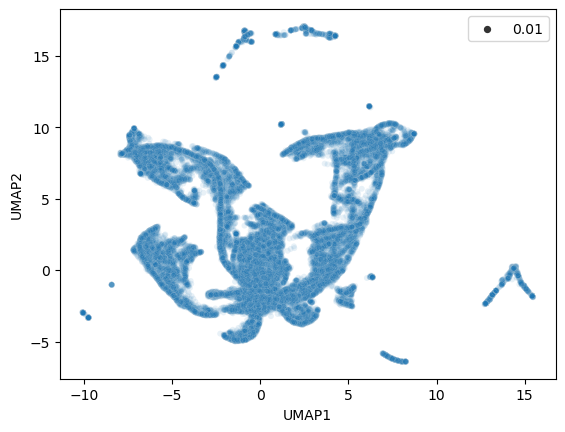

In [16]:
# Scatter plot of UMAP1 vs UMAP2

sns.scatterplot(data=Umap, x="UMAP1", y="UMAP2", size=0.01, alpha = 0.1)

# save the plot

plt.savefig(f"{output_dir}/UMAPTest.png")


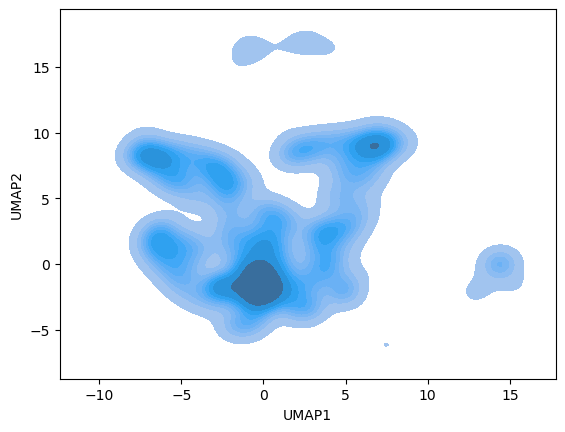

In [17]:
# Density plot of UMAP1 vs UMAP2

sns.kdeplot(data=Umap, x="UMAP1", y="UMAP2", fill=True)

# save the plot

plt.savefig(f"{output_dir}/UMAPTest_density.png")

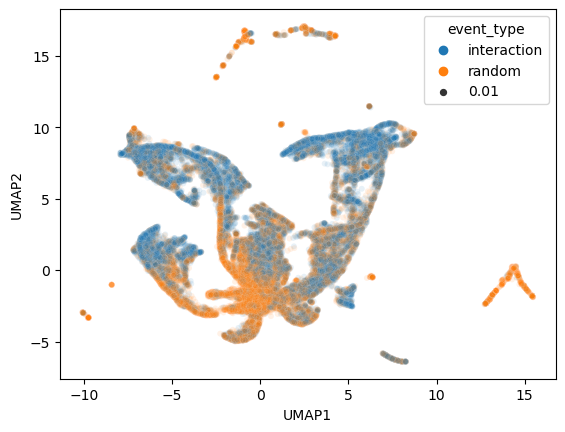

In [18]:
# Color code by event_type

sns.scatterplot(data=Umap, x="UMAP1", y="UMAP2", size=0.01, alpha = 0.1, hue="event_type")

# Save the plot

plt.savefig(f"{output_dir}/UMAP_event_types.png")

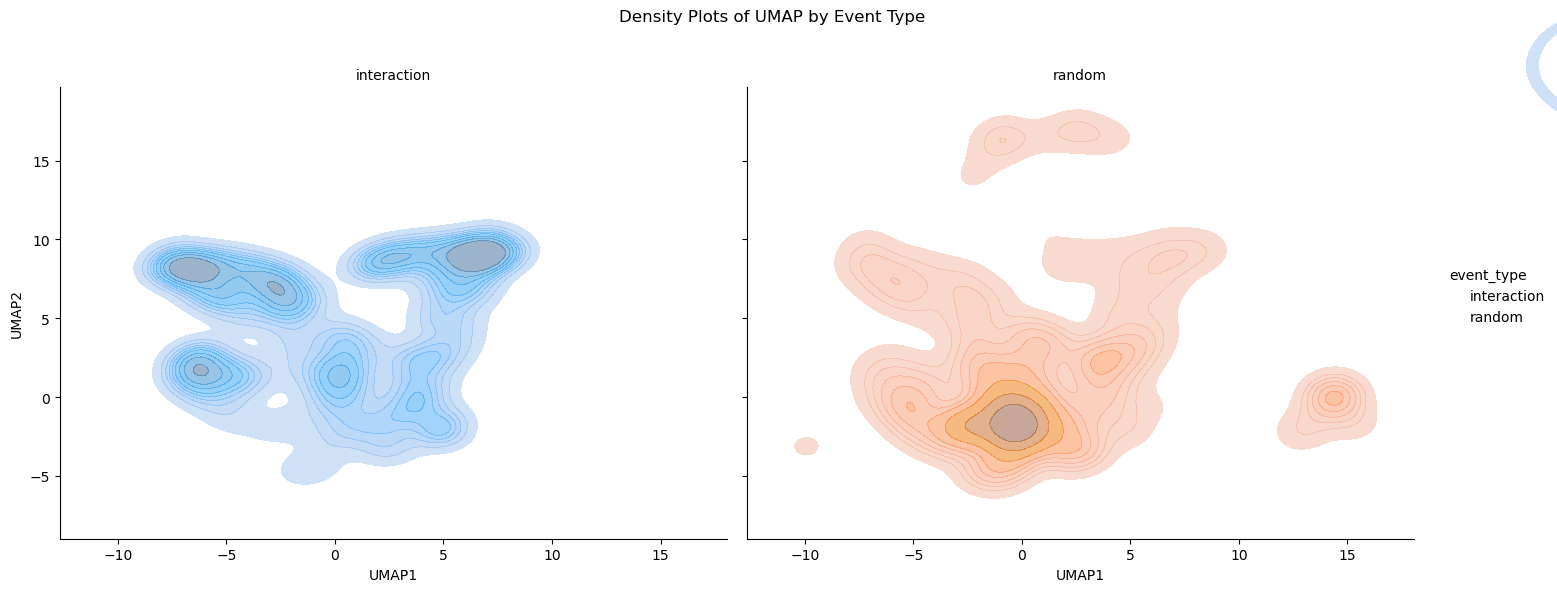

In [19]:
# Create a FacetGrid with two columns, one for each event_type
g = sns.FacetGrid(Umap, col="event_type", hue="event_type", sharex=True, sharey=True, height=6, aspect=1.2)

# Map the kdeplot to the FacetGrid
g.map(sns.kdeplot, "UMAP1", "UMAP2", fill=True, alpha=0.5)

# Add titles and adjust layout
g.set_titles(col_template="{col_name}")
g.add_legend()
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Density Plots of UMAP by Event Type")

# Save the plot
plt.savefig(f"{output_dir}/UMAP_event_types_density.png")
plt.show()
plt.close()

# Clustering

In [6]:
# Identify clusters based on KMeans

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=8, random_state=0).fit(Umap[["UMAP1", "UMAP2"]])

Umap["cluster"] = kmeans.labels_


In [7]:
Umap["cluster"].unique()

array([3, 5, 1, 6, 2, 0, 7, 4], dtype=int32)

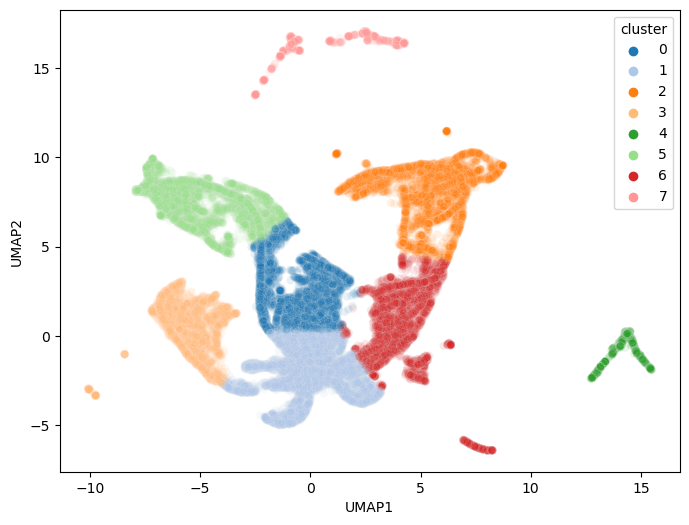

In [22]:

plt.figure(figsize=(8, 6))

sns.scatterplot(data=Umap, x="UMAP1", y="UMAP2", alpha = 0.1, hue="cluster", palette="tab20")

# Save the plot

plt.savefig(f"{output_dir}/UMAP_Clusters.png")

In [ ]:
# Same with density

plt.figure(figsize=(8, 6))

sns.kdeplot(data=Umap, x="UMAP1", y="UMAP2", fill=True, alpha=0.5, hue="cluster", palette="tab10")

plt.savefig(f"{output_dir}/UMAP_Clusters_density.png")

In [ ]:
# Get columns that do not have "centre" in their name

Umap.columns[~Umap.columns.str.contains("centre")]

# Looking into particular conditions

## Light

In [23]:
# Check Light values: 

Umap["Light"].unique()

# Check how many values for each light level

Umap["Light"].value_counts()

Light
on     36823
off     9733
        3414
Name: count, dtype: int64

In [117]:
# Make a subset of the data with only "on" and "off" light values

Umap_light = Umap[Umap["Light"].isin(["off", "on"])]



<Axes: xlabel='UMAP1', ylabel='UMAP2'>

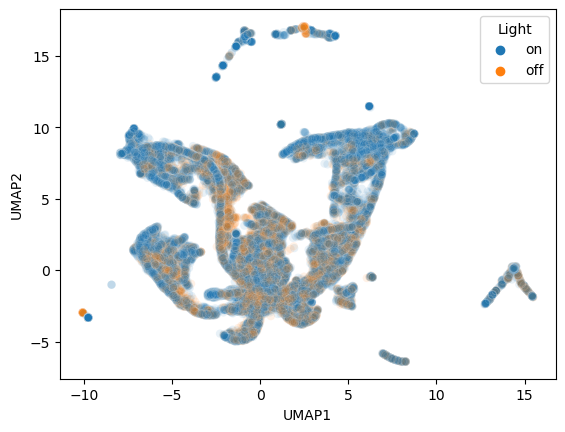

In [25]:
sns.scatterplot(
    data=Umap_light, x="UMAP1", y="UMAP2", alpha=0.1, hue="Light", palette="tab10"
)

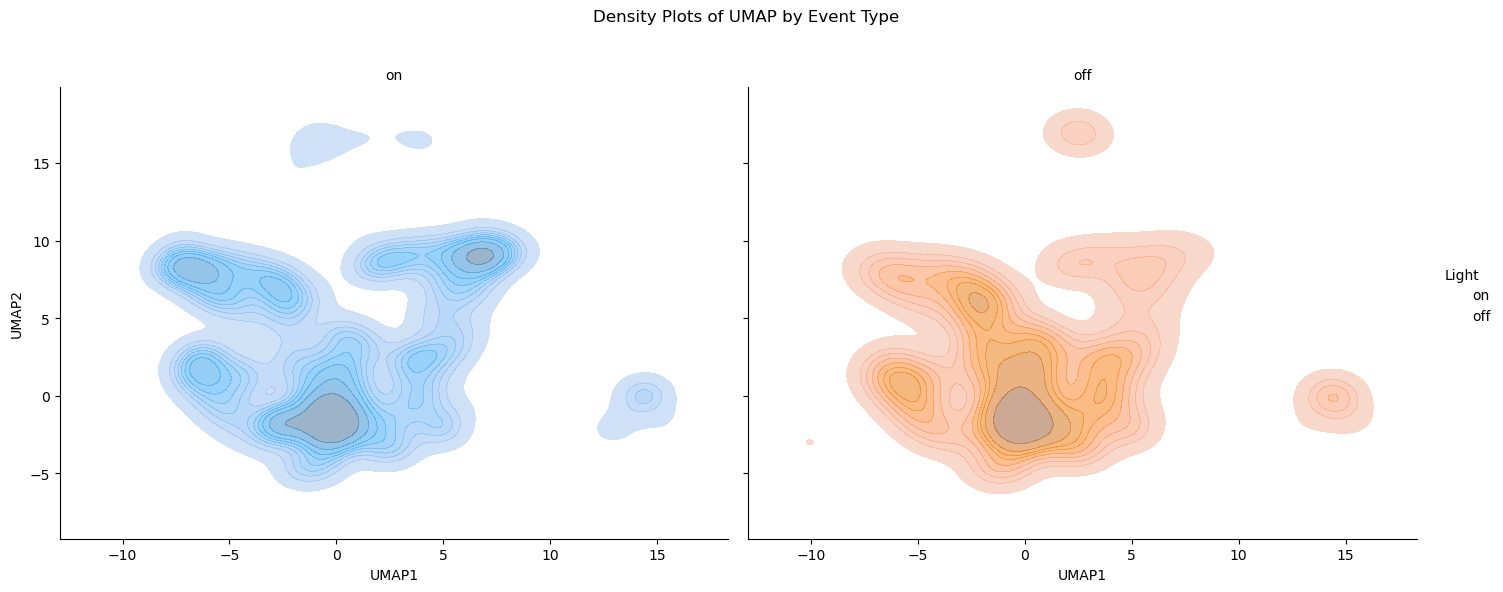

In [26]:
# Create a FacetGrid with two columns, one for each event_type
g = sns.FacetGrid(
    Umap_light, col="Light", hue="Light", sharex=True, sharey=True, height=6, aspect=1.2
)

# Map the kdeplot to the FacetGrid
g.map(sns.kdeplot, "UMAP1", "UMAP2", fill=True, alpha=0.5)

# Add titles and adjust layout
g.set_titles(col_template="{col_name}")
g.add_legend()
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Density Plots of UMAP by Event Type")

# Save the plot
plt.savefig(f"{output_dir}/UMAP_LightConditions_Density.png")
plt.show()
plt.close()

## Feeding State

In [27]:
# Check FeedingState values:

Umap["FeedingState"].unique()

# Check how many values for each light level

Umap["FeedingState"].value_counts()

FeedingState
starved            17705
starved_noWater    12780
fed                12387
Fed                 3684
                    3414
Name: count, dtype: int64

In [28]:
# Rename the feedingstate that are "Fed" to "fed" and make a subset of the data with only "starved", "fed" and "starved_noWater"

Umap["FeedingState"] = Umap["FeedingState"].replace("Fed", "fed")

Umap_feeding = Umap[Umap["FeedingState"].isin(["starved", "fed", "starved_noWater"])]
Umap_feeding["FeedingState"].unique()

array(['starved', 'starved_noWater', 'fed'], dtype=object)

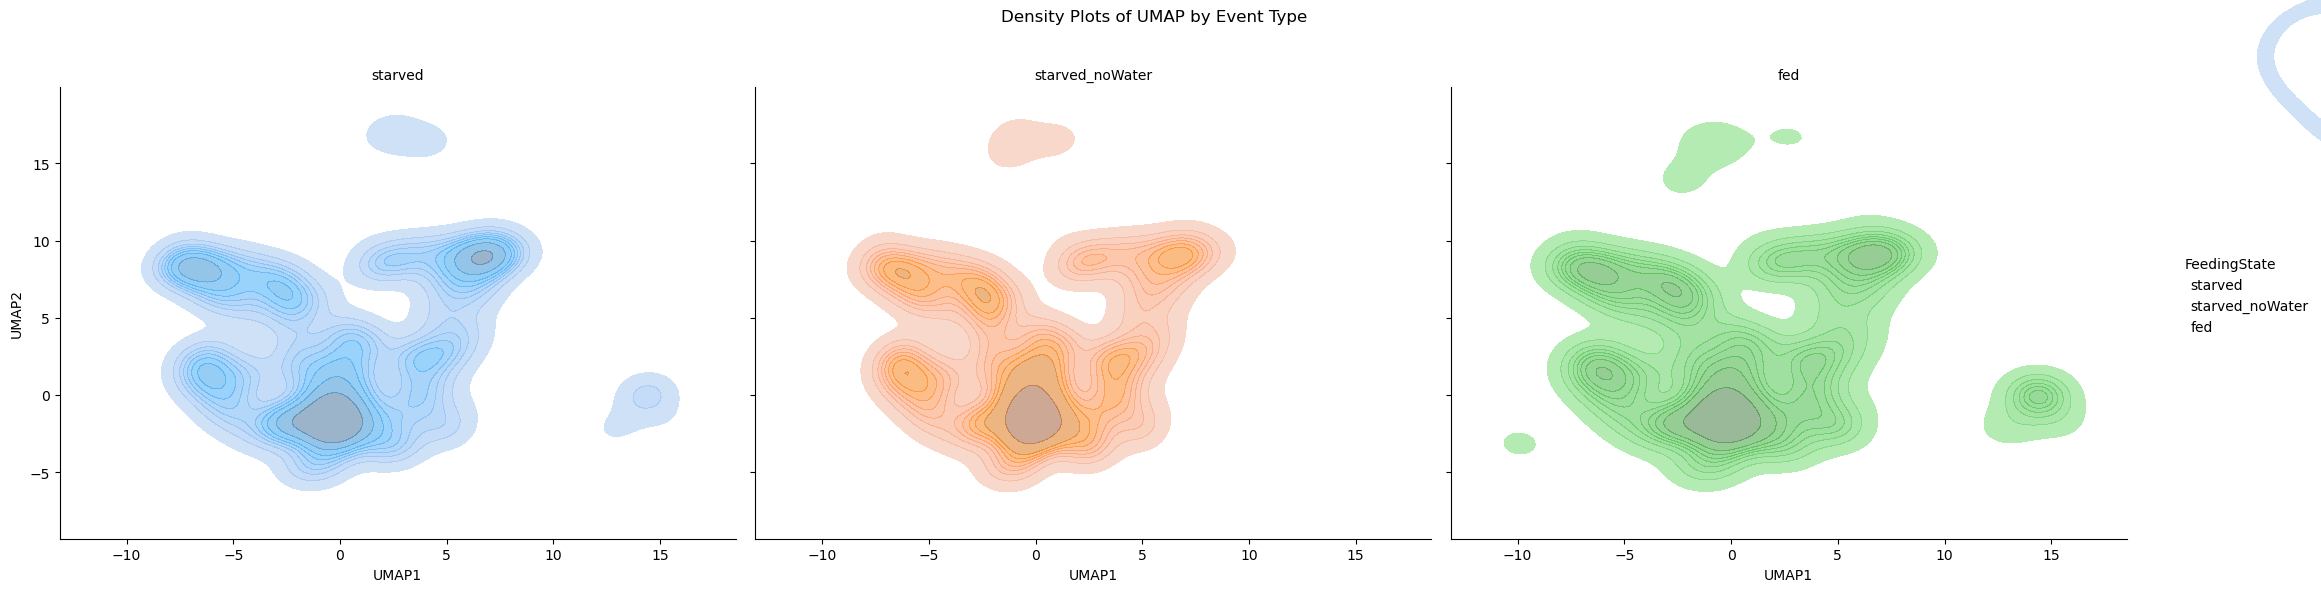

In [29]:
# Create a FacetGrid with two columns, one for each event_type
g = sns.FacetGrid(
    Umap_feeding,
    col="FeedingState",
    hue="FeedingState",
    sharex=True,
    sharey=True,
    height=6,
    aspect=1.2,
)

# Map the kdeplot to the FacetGrid
g.map(sns.kdeplot, "UMAP1", "UMAP2", fill=True, alpha=0.5)

# Add titles and adjust layout
g.set_titles(col_template="{col_name}")
g.add_legend()
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Density Plots of UMAP by Event Type")

# Save the plot
plt.savefig(f"{output_dir}/UMAP_FeedingStateConditions_Density.png")
plt.show()
plt.close()

# Mapping clusters to interaction events and videos chunks

In [8]:
# Load the source data

interaction_data = pd.read_feather(
    "/mnt/upramdya_data/MD/Ballpushing_Exploration/Datasets/250313_StdContacts_Ctrl_cutoff_300frames_Data/standardized_contacts/250313_pooled_standardized_contacts.feather"
)

In [9]:
interaction_data.head()

index  frame       time object     x_Head      y_Head   x_Thorax  \
0      0   1071  36.931034  fly_1  75.710632  240.353424  75.440628   
1      1   1072  36.965517  fly_1  75.812958  240.381378  75.516953   
2      2   1073  37.000000  fly_1  75.792000  240.267883  75.472809   
3      3   1074  37.034483  fly_1  75.984436  240.330215  75.542435   
4      4   1075  37.068966  fly_1  76.052086  240.229660  75.573708   

     y_Thorax  x_Abdomen   y_Abdomen  ...  Genotype  Period  FeedingState  \
0  251.809906  67.591927  264.505920  ...        PR      PM           fed   
1  251.901382  67.485046  267.341705  ...        PR      PM           fed   
2  251.762573  64.422112  264.439514  ...        PR      PM           fed   
3  251.807129  64.420174  264.344635  ...        PR      PM           fed   
4  251.706802  64.398346  264.272858  ...        PR      PM           fed   

   Orientation  Light  Crossing  BallType  Peak  Used_to   Magnet  
0          std    off      None      None   NaN       NaN     NaN  
1          std    off      None      None   NaN       NaN     NaN  
2          std    off      None      None   NaN       NaN     NaN  
3          std    off      None      None   NaN       NaN     NaN  
4          std    off      None      None   NaN       NaN     NaN  

[5 rows x 77 columns]

In [10]:
interaction_data.columns

Index(['index', 'frame', 'time', 'object', 'x_Head', 'y_Head', 'x_Thorax',
       'y_Thorax', 'x_Abdomen', 'y_Abdomen', 'x_Rfront', 'y_Rfront',
       'x_Lfront', 'y_Lfront', 'x_Rmid', 'y_Rmid', 'x_Lmid', 'y_Lmid',
       'x_Rhind', 'y_Rhind', 'x_Lhind', 'y_Lhind', 'x_Rwing', 'y_Rwing',
       'x_Lwing', 'y_Lwing', 'x_centre_preprocessed', 'y_centre_preprocessed',
       'x_Head_fly', 'y_Head_fly', 'x_Thorax_fly', 'y_Thorax_fly',
       'x_Abdomen_fly', 'y_Abdomen_fly', 'x_Rfront_fly', 'y_Rfront_fly',
       'x_Lfront_fly', 'y_Lfront_fly', 'x_Rmid_fly', 'y_Rmid_fly',
       'x_Lmid_fly', 'y_Lmid_fly', 'x_Rhind_fly', 'y_Rhind_fly', 'x_Lhind_fly',
       'y_Lhind_fly', 'x_Rwing_fly', 'y_Rwing_fly', 'x_Lwing_fly',
       'y_Lwing_fly', 'x_centre_preprocessed_fly', 'y_centre_preprocessed_fly',
       'event_id', 'time_rel_onset', 'fly_idx', 'ball_idx', 'adjusted_frame',
       'event_type', 'ball_displacement', 'fly', 'flypath', 'experiment',
       'Nickname', 'Brain region', 'Simplified 

In [11]:
# Make a unique identifier as combination of fly, event_type and event_id

Umap["unique_id"] = Umap["fly"].astype(str) + "_" + Umap["event_type"] + "_" + Umap["event_id"].astype(str)

interaction_data["unique_id"] = interaction_data["fly"].astype(str) + "_" + interaction_data["event_type"] + "_" + interaction_data["event_id"].astype(str)

In [ ]:
# As example get the cluster 0 and make a subset of interaction data that contains all unique_ids in cluster 0

cluster_0 = Umap[Umap["cluster"] == 0]

cluster_0_interactions = interaction_data[interaction_data["unique_id"].isin(cluster_0["unique_id"])]
cluster_0_interactions.head()

# Looping over all clusters

In [34]:
# Configuration parameters
MAX_CELL_WIDTH = 96   # Maximum width for grid cells
MAX_CELL_HEIGHT = 516  # Maximum height for grid cells
MAX_OUTPUT_WIDTH = 3840
MAX_OUTPUT_HEIGHT = 2160
FPS = 5
CODEC = "mp4v"
OUTPUT_DIR = output_dir

def resize_with_padding(frame, target_w, target_h):
    """Resize frame while maintaining aspect ratio with padding"""
    h, w = frame.shape[:2]
    scale = min(target_w/w, target_h/h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    
    resized = cv2.resize(frame, (new_w, new_h))
    pad_w = target_w - new_w
    pad_h = target_h - new_h
    
    # Add equal padding on both sides
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left
    
    return cv2.copyMakeBorder(resized, top, bottom, left, right, 
                            cv2.BORDER_CONSTANT, value=(0,0,0))

def process_cluster(cluster_id, Umap, interaction_data, best_disp=False):
    cluster_data = Umap[Umap["cluster"] == cluster_id]
    cluster_interactions = interaction_data[interaction_data["unique_id"].isin(cluster_data["unique_id"])]
    
    # Calculate frame ranges for each unique_id
    frame_ranges = (cluster_interactions
                    .groupby('unique_id')['frame']
                    .agg(frame_start=('min'), frame_end=('max'))
                    .reset_index())

    # Merge with path information
    event_metadata = (cluster_interactions[['unique_id', 'flypath']]
                      .drop_duplicates()
                      .merge(frame_ranges, on='unique_id'))

    # Add raw_displacement from Umap to event_metadata
    event_metadata = event_metadata.merge(
        Umap[['unique_id', 'raw_displacement']],
        on='unique_id',
        how='left'
    )

    # Calculate grid layout based on max output dimensions
    cols = MAX_OUTPUT_WIDTH // MAX_CELL_HEIGHT  # Note the swapped dimensions
    rows = MAX_OUTPUT_HEIGHT // MAX_CELL_WIDTH  # Note the swapped dimensions
    max_events = cols * rows

    # Select events based on the best_disp argument
    if len(event_metadata) > max_events:
        if best_disp:
            # Sort by raw_displacement in descending order and pick the top events
            event_metadata = event_metadata.sort_values(by='raw_displacement', ascending=False).head(max_events)
        else:
            # Randomly sample events
            event_metadata = event_metadata.sample(max_events, random_state=42)

    # Initialize frame storage and video metadata
    frames_dict = {}
    max_duration = 0
    valid_events = 0

    # Process videos in optimized groups
    for flypath, group in event_metadata.groupby('flypath'):
        video_files = list(Path(flypath).glob("*.mp4"))
        video_file = next((vf for vf in video_files if "_preprocessed" not in vf.stem), None)
        
        if not video_file:
            print(f"Skipping {flypath} - no suitable MP4 found")
            continue

        cap = cv2.VideoCapture(str(video_file))
        if not cap.isOpened():
            print(f"Couldn't open {video_file}")
            continue

        # Process all events from this video
        for _, event in group.iterrows():
            try:
                start = int(event['frame_start'])
                end = int(event['frame_end'])
                if start > end:
                    print(f"Invalid frames for {event['unique_id']}")
                    continue
                    
                # Read event frames with boundary checks
                cap.set(cv2.CAP_PROP_POS_FRAMES, start)
                frames = []
                for _ in range(end - start + 1):
                    ret, frame = cap.read()
                    if not ret:
                        break
                    # Rotate frame 90° clockwise
                    frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
                    # Convert color space and resize with padding
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame = resize_with_padding(frame, MAX_CELL_HEIGHT, MAX_CELL_WIDTH)  # Note the swapped dimensions
                    frames.append(frame)
                
                if frames:
                    frames_dict[event['unique_id']] = frames
                    max_duration = max(max_duration, len(frames))
                    valid_events += 1

            except Exception as e:
                print(f"Error processing {event['unique_id']}: {str(e)}")
        
        cap.release()

    # Early exit if no valid events
    if valid_events == 0:
        raise ValueError(f"No processable events found for cluster {cluster_id}")

    # Pad all clips to max duration with black frames
    for uid in frames_dict:
        frames = frames_dict[uid]
        if len(frames) < max_duration:
            padding = [np.zeros((MAX_CELL_WIDTH, MAX_CELL_HEIGHT, 3), dtype=np.uint8)] * (max_duration - len(frames))  # Note the swapped dimensions
            frames_dict[uid] = frames + padding

    # Final output dimensions
    output_size = (cols * MAX_CELL_HEIGHT, rows * MAX_CELL_WIDTH)  # Note the swapped dimensions

    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*CODEC)
    if best_disp:
        output_path = Path(OUTPUT_DIR) / f"cluster_{cluster_id}_video_best_disp.mp4"
    else:
        output_path = Path(OUTPUT_DIR) / f"cluster_{cluster_id}_video.mp4"
    out = cv2.VideoWriter(str(output_path), fourcc, FPS, output_size)

    # Generate grid frames
    for frame_idx in range(max_duration):
        grid = np.zeros((output_size[1], output_size[0], 3), dtype=np.uint8)
        
        for idx, (uid, frames) in enumerate(frames_dict.items()):
            if frame_idx >= len(frames):
                continue
                
            row = idx // cols
            col = idx % cols
            
            # Calculate position
            x = col * MAX_CELL_HEIGHT  # Note the swapped dimensions
            y = row * MAX_CELL_WIDTH  # Note the swapped dimensions
            
            # Place frame in grid cell
            grid[y:y+MAX_CELL_WIDTH, x:x+MAX_CELL_HEIGHT] = frames[frame_idx]  # Note the swapped dimensions

        out.write(cv2.cvtColor(grid, cv2.COLOR_RGB2BGR))

    out.release()
    print(f"Successfully created grid video for cluster {cluster_id} at {output_path}")

In [35]:
# Get unique clusters
unique_clusters = Umap["cluster"].unique()

# Create output directory if it doesn't exist
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Process each cluster
for cluster_id in unique_clusters:
    try:
        process_cluster(cluster_id, Umap, interaction_data, best_disp=True)
    except Exception as e:
        print(f"Error processing cluster {cluster_id}: {str(e)}")


Successfully created grid video for cluster 3 at /mnt/upramdya_data/MD/Ballpushing_Exploration/Behavior_classification/UMAP/250327_StdContacts_Ctrl_noOverlap_Data_cutoff_300Frames_multiclusters/cluster_3_video_best_disp.mp4
Successfully created grid video for cluster 5 at /mnt/upramdya_data/MD/Ballpushing_Exploration/Behavior_classification/UMAP/250327_StdContacts_Ctrl_noOverlap_Data_cutoff_300Frames_multiclusters/cluster_5_video_best_disp.mp4
Successfully created grid video for cluster 1 at /mnt/upramdya_data/MD/Ballpushing_Exploration/Behavior_classification/UMAP/250327_StdContacts_Ctrl_noOverlap_Data_cutoff_300Frames_multiclusters/cluster_1_video_best_disp.mp4
Successfully created grid video for cluster 6 at /mnt/upramdya_data/MD/Ballpushing_Exploration/Behavior_classification/UMAP/250327_StdContacts_Ctrl_noOverlap_Data_cutoff_300Frames_multiclusters/cluster_6_video_best_disp.mp4
Successfully created grid video for cluster 2 at /mnt/upramdya_data/MD/Ballpushing_Exploration/Behavior_

# Cluster proportions

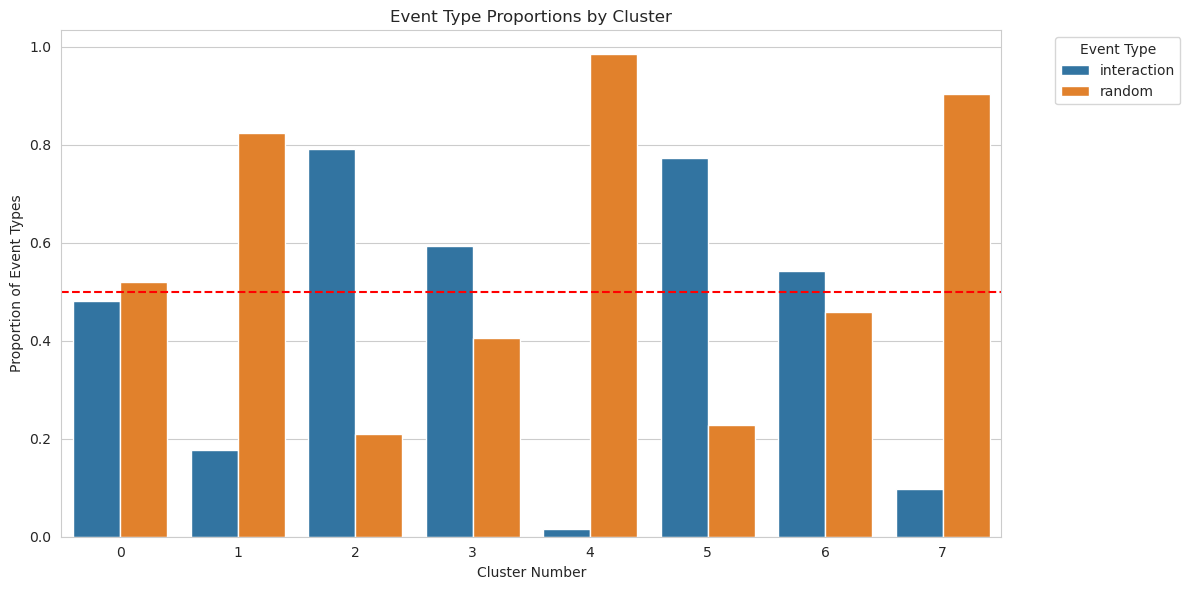

In [38]:
# Get unique clusters
unique_clusters = Umap["cluster"].unique()

# Initialize a DataFrame to store the proportions
proportions_df = pd.DataFrame()

# Process each cluster
for cluster_id in unique_clusters:
    cluster_data = Umap[Umap["cluster"] == cluster_id]
    
    # Count event types and calculate proportions
    event_counts = cluster_data["event_type"].value_counts(normalize=True).reset_index()
    event_counts.columns = ["event_type", "proportion"]
    event_counts["cluster"] = cluster_id
    
    # Append to the proportions DataFrame
    proportions_df = pd.concat([proportions_df, event_counts], ignore_index=True)

# Plot event type proportions as bar plots
plt.figure(figsize=(12, 6))
sns.barplot(data=proportions_df, x="cluster", y="proportion", hue="event_type")
plt.axhline(0.5, color='red', linestyle='--')
plt.title("Event Type Proportions by Cluster")
plt.xlabel("Cluster Number")
plt.ylabel("Proportion of Event Types")
plt.legend(title="Event Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot
plt.savefig(f"{output_dir}/event_type_proportions_by_cluster.png")
plt.show()
plt.close()

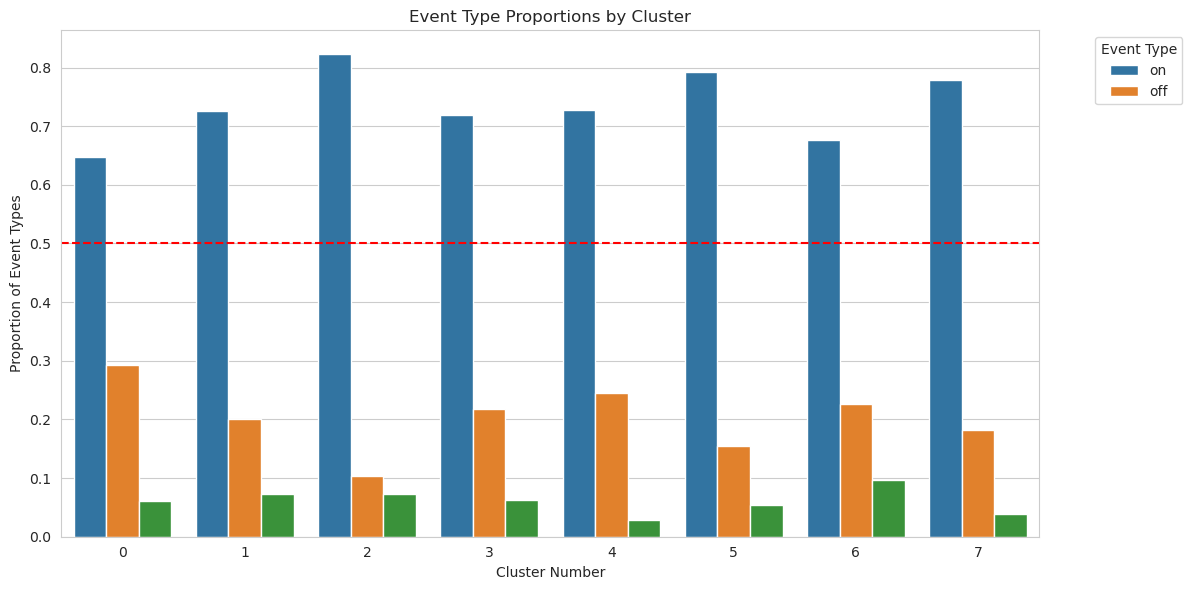

In [111]:
# Get unique clusters
unique_clusters = Umap["cluster"].unique()

# Initialize a DataFrame to store the proportions
proportions_df = pd.DataFrame()

# Process each cluster
for cluster_id in unique_clusters:
    cluster_data = Umap[Umap["cluster"] == cluster_id]

    # Count event types and calculate proportions
    event_counts = cluster_data["Light"].value_counts(normalize=True).reset_index()
    event_counts.columns = ["Light", "proportion"]
    event_counts["cluster"] = cluster_id

    # Append to the proportions DataFrame
    proportions_df = pd.concat([proportions_df, event_counts], ignore_index=True)

# Plot event type proportions as bar plots
plt.figure(figsize=(12, 6))
sns.barplot(data=proportions_df, x="cluster", y="proportion", hue="Light")
plt.axhline(0.5, color="red", linestyle="--")
plt.title("Event Type Proportions by Cluster")
plt.xlabel("Cluster Number")
plt.ylabel("Proportion of Event Types")
plt.legend(title="Event Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# Save the plot
plt.savefig(f"{output_dir}/light_proportions_by_cluster.png")
plt.show()
plt.close()

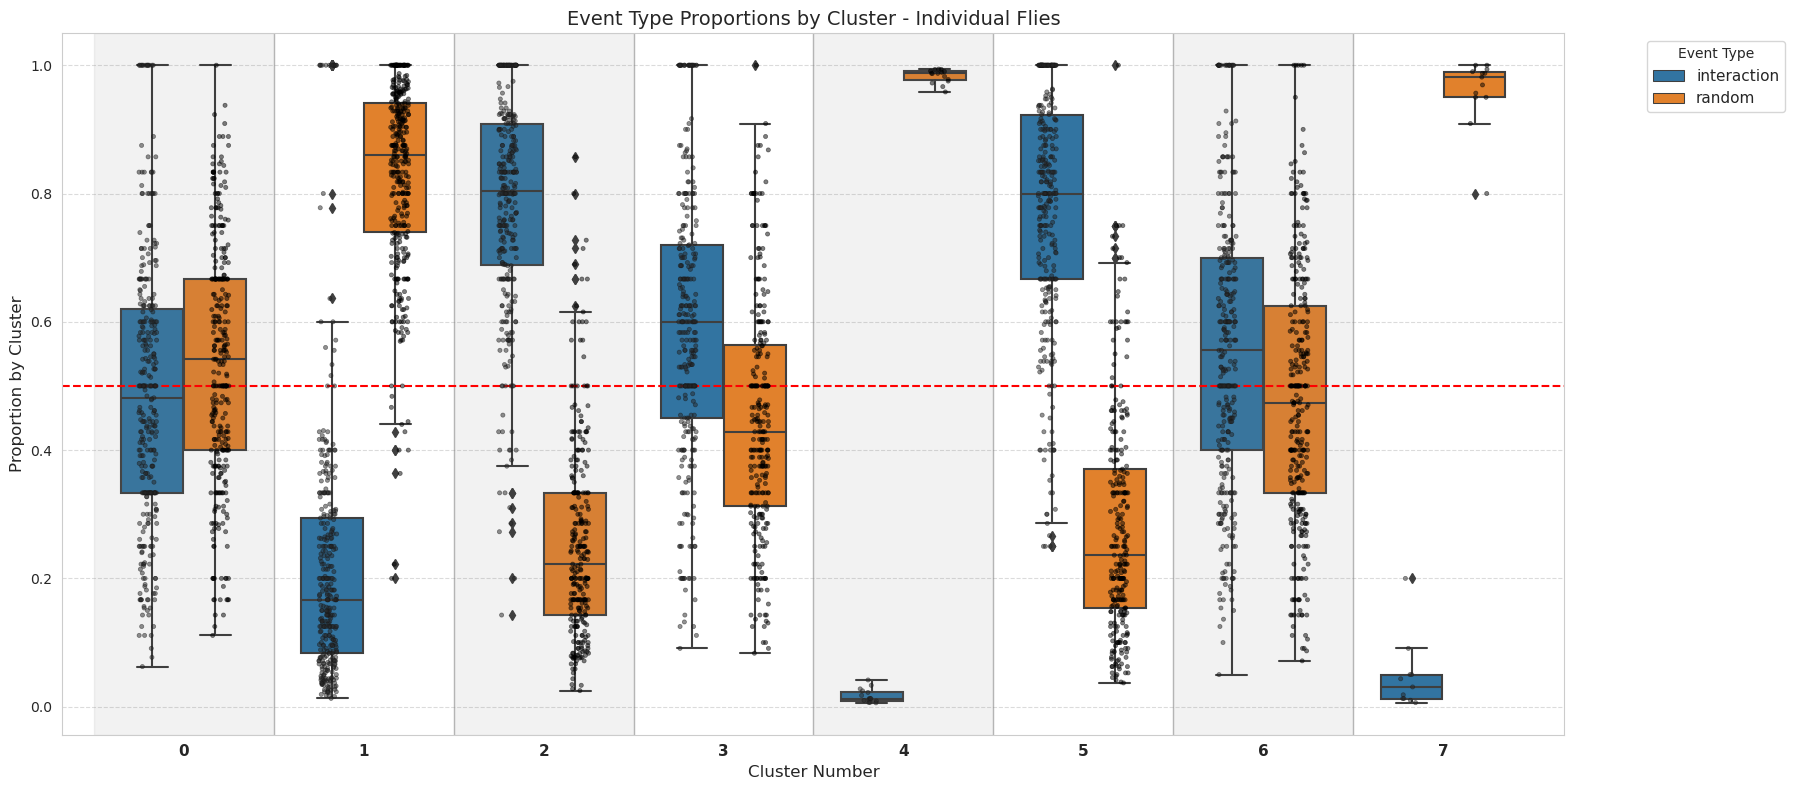

In [37]:
# Get unique clusters
unique_clusters = Umap["cluster"].unique()

# Initialize a DataFrame to store the individual fly proportions
fly_proportions_df = pd.DataFrame()

# Process each cluster and fly combination
for cluster_id in unique_clusters:
    cluster_data = Umap[Umap["cluster"] == cluster_id]
    
    # Get unique flies in this cluster
    unique_flies = cluster_data["fly"].unique()
    
    for fly_id in unique_flies:
        # Get data for this specific fly and cluster
        fly_cluster_data = cluster_data[cluster_data["fly"] == fly_id]
        
        # Only process if we have enough data points for this fly
        if len(fly_cluster_data) >= 5:  # Minimum threshold to calculate meaningful proportion
            # Count direction types and calculate proportions
            event_type_counts = fly_cluster_data["event_type"].value_counts(normalize=True).reset_index()
            event_type_counts.columns = ["event_type", "proportion"]
            event_type_counts["cluster"] = cluster_id
            event_type_counts["fly"] = fly_id
            
            # Append to the proportions DataFrame
            fly_proportions_df = pd.concat([fly_proportions_df, event_type_counts], ignore_index=True)

# Get unique event types and specify their order
event_types = sorted(fly_proportions_df["event_type"].unique())
clusters = sorted(fly_proportions_df["cluster"].unique())

# Create figure with more width to accommodate separations
plt.figure(figsize=(18, 8))  # Increased width

# Set style for better grid visibility
sns.set_style("whitegrid")

# Add boxplot with explicit order
ax = sns.boxplot(
    data=fly_proportions_df, 
    x="cluster", 
    y="proportion", 
    hue="event_type",
    hue_order=event_types,
    width=0.7  # Slightly narrower boxes
)

# Add stripplot with the SAME order
sns.stripplot(
    data=fly_proportions_df, 
    x="cluster", 
    y="proportion", 
    hue="event_type",
    hue_order=event_types,
    color='black',
    dodge=True, 
    size=3, 
    alpha=0.5,
    edgecolor='gray',
    linewidth=0.5
)

# Add vertical lines between cluster groups
for i in range(len(clusters)-1):
    plt.axvline(x=i+0.5, color='gray', linestyle='-', alpha=0.5, linewidth=1)

# Add alternating background for easier visual grouping
for i in range(len(clusters)):
    if i % 2 == 0:  # Every other cluster gets a light background
        plt.axvspan(i-0.5, i+0.5, alpha=0.1, color='gray')

# Set proper grid
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(axis='x', visible=False)  # Remove default x grid

plt.axhline(0.5, color='red', linestyle='--', label="Equal proportion")
plt.title("Event Type Proportions by Cluster - Individual Flies", fontsize=14)
plt.xlabel("Cluster Number", fontsize=12)
plt.ylabel("Proportion by Cluster", fontsize=12)

# Improve x-axis labels
plt.xticks(range(len(clusters)), [str(c) for c in clusters], fontsize=11, fontweight='bold')

# Create a better legend (only keep one set)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:len(event_types)], labels[:len(event_types)], 
           title="Event Type", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11)

plt.tight_layout()
# Save the plot
plt.savefig(f"{output_dir}/proportions_by_cluster_individual_flies.png")
plt.show()
plt.close()

## By light conditions

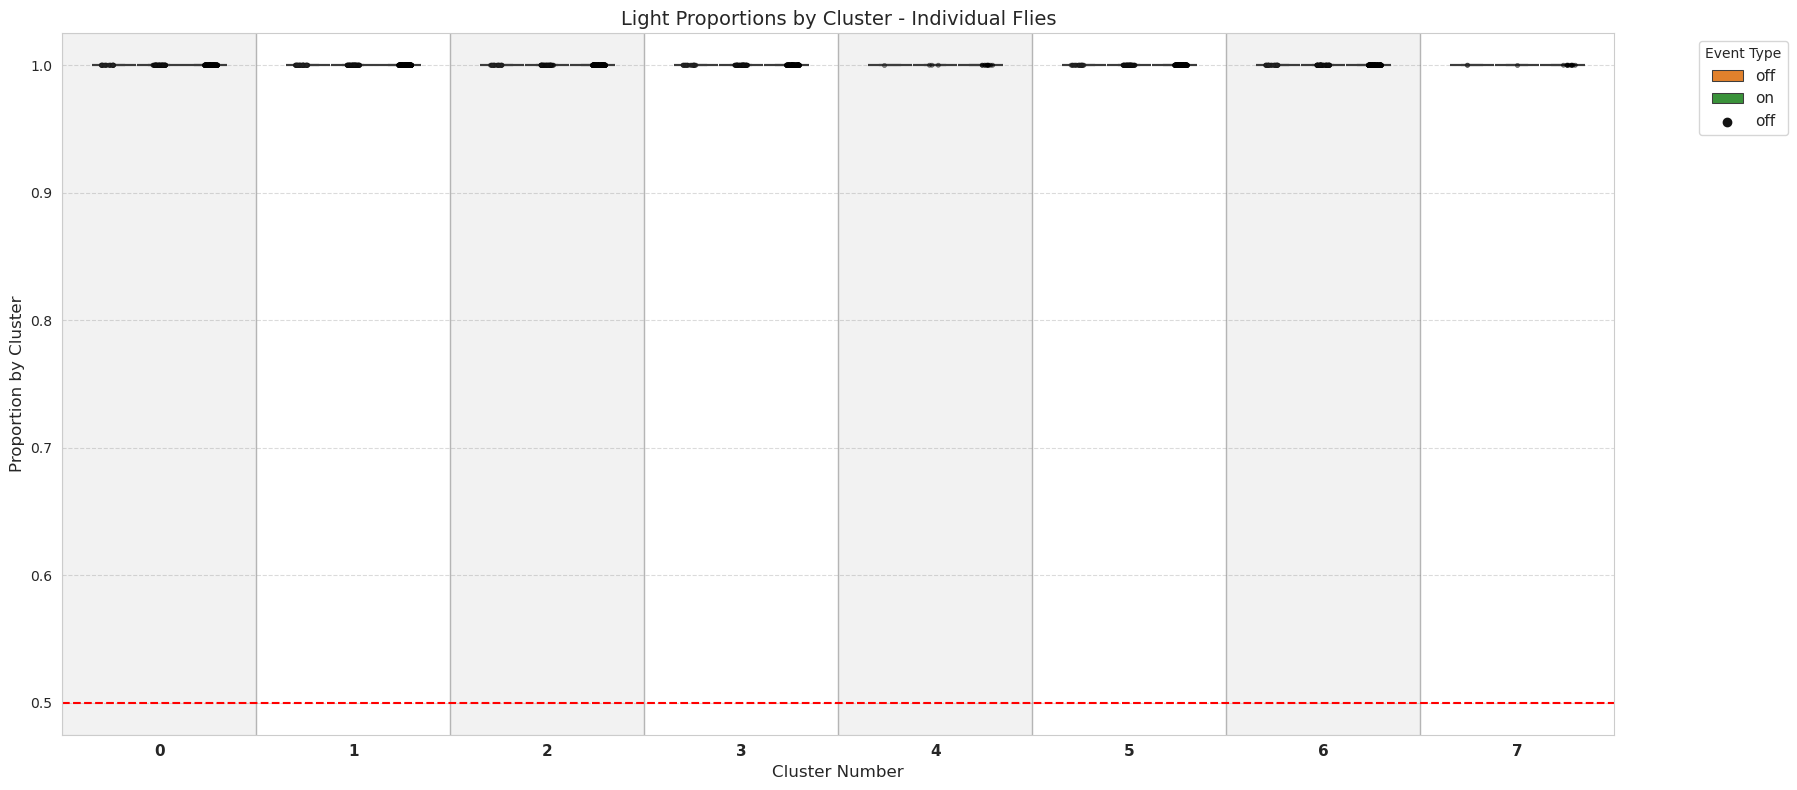

In [109]:
# Get unique clusters
unique_clusters = Umap["cluster"].unique()

# Initialize a DataFrame to store the individual fly proportions
fly_proportions_df = pd.DataFrame()

# Process each cluster and fly combination
for cluster_id in unique_clusters:
    cluster_data = Umap[Umap["cluster"] == cluster_id]

    # Get unique flies in this cluster
    unique_flies = cluster_data["fly"].unique()

    for fly_id in unique_flies:
        # Get data for this specific fly and cluster
        fly_cluster_data = cluster_data[cluster_data["fly"] == fly_id]

        # Only process if we have enough data points for this fly
        if (
            len(fly_cluster_data) >= 5
        ):  # Minimum threshold to calculate meaningful proportion
            # Count direction types and calculate proportions
            event_type_counts = (
                fly_cluster_data["Light"]
                .value_counts(normalize=True)
                .reset_index()
            )
            event_type_counts.columns = ["Light", "proportion"]
            event_type_counts["cluster"] = cluster_id
            event_type_counts["fly"] = fly_id

            # Append to the proportions DataFrame
            fly_proportions_df = pd.concat(
                [fly_proportions_df, event_type_counts], ignore_index=True
            )

# Get unique event types and specify their order
event_types = sorted(fly_proportions_df["Light"].unique())
clusters = sorted(fly_proportions_df["cluster"].unique())

# Create figure with more width to accommodate separations
plt.figure(figsize=(18, 8))  # Increased width

# Set style for better grid visibility
sns.set_style("whitegrid")

# Add boxplot with explicit order
ax = sns.boxplot(
    data=fly_proportions_df,
    x="cluster",
    y="proportion",
    hue="Light",
    hue_order=event_types,
    width=0.7,  # Slightly narrower boxes
)

# Add stripplot with the SAME order
sns.stripplot(
    data=fly_proportions_df,
    x="cluster",
    y="proportion",
    hue="Light",
    hue_order=event_types,
    color="black",
    dodge=True,
    size=3,
    alpha=0.5,
    edgecolor="gray",
    linewidth=0.5,
)

# Add vertical lines between cluster groups
for i in range(len(clusters) - 1):
    plt.axvline(x=i + 0.5, color="gray", linestyle="-", alpha=0.5, linewidth=1)

# Add alternating background for easier visual grouping
for i in range(len(clusters)):
    if i % 2 == 0:  # Every other cluster gets a light background
        plt.axvspan(i - 0.5, i + 0.5, alpha=0.1, color="gray")

# Set proper grid
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.grid(axis="x", visible=False)  # Remove default x grid

plt.axhline(0.5, color="red", linestyle="--", label="Equal proportion")
plt.title("Light Proportions by Cluster - Individual Flies", fontsize=14)
plt.xlabel("Cluster Number", fontsize=12)
plt.ylabel("Proportion by Cluster", fontsize=12)

# Improve x-axis labels
plt.xticks(
    range(len(clusters)), [str(c) for c in clusters], fontsize=11, fontweight="bold"
)

# Create a better legend (only keep one set)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(
    handles[: len(event_types)],
    labels[: len(event_types)],
    title="Event Type",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=11,
)

plt.tight_layout()
# Save the plot
plt.savefig(f"{output_dir}/proportions_by_light_individual_flies.png")
plt.show()
plt.close()

# Check clusters composition for ligh conditions

In [ ]:
# With the Light subset, compare the event type proportions between light on and light off conditions

# Get unique clusters
unique_clusters = Umap_light["cluster"].unique()

# Initialize a DataFrame to store the proportions
proportions_df_Light = pd.DataFrame()

# Process each cluster
for cluster_id in unique_clusters:
    cluster_data = Umap_light[Umap_light["cluster"] == cluster_id]

    # Count event types and calculate proportions
    event_counts = (
        cluster_data.groupby("Light")["event_type"]
        .value_counts(normalize=True)
        .reset_index(name="proportion")
    )
    event_counts["cluster"] = cluster_id

    # Append to the proportions DataFrame
    proportions_df_Light = pd.concat(
        [proportions_df_Light, event_counts], ignore_index=True
    )

# Plot event type proportions as bar plots
plt.figure(figsize=(12, 6))
sns.barplot(data=proportions_df_Light, x="cluster", y="proportion", hue="Light")
plt.axhline(0.5, color="red", linestyle="--")
plt.title("Event Type Proportions by Cluster")
plt.xlabel("Cluster Number")
plt.ylabel("Proportion of Event Types")
plt.legend(title="Light Condition", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# Save the plot
# plt.savefig(f"{output_dir}/event_type_proportions_by_cluster.png")
plt.show()
plt.close()

# Individual features plotting

Let's check which features might be dominant in pulling apart the events

In [40]:
# Load the transformed data 

Transformed = pd.read_feather("/mnt/upramdya_data/MD/MultiMazeRecorder/Datasets/250220_StdContacts_Ctrl_Data/Transformed/230704_FeedingState_1_AM_Videos_Tracked_standardized_contacts_Transformed.feather")

In [41]:
Transformed["unique_id"] = Transformed["fly"].astype(str) + "_" + Transformed["event_type"] + "_" + Transformed["event_id"].astype(str)

In [ ]:
# Get one cluster and the corresponding transformed data

cluster_0 = Umap[Umap["cluster"] == 0]

cluster_0_transformed = Transformed[Transformed["unique_id"].isin(cluster_0["unique_id"])]
cluster_0_transformed.head()

In [ ]:
# Replace Nans with 9999

cluster_0_transformed = cluster_0_transformed.fillna(9999)

In [ ]:
# Get the list of features

feature_groups=['tracking', 'frame']

# Feature selection configuration
feature_config = {
    'tracking': [r'_frame\d+_x$', r'_frame\d+_y$'],
    'frame': [r'_frame\d+_velocity$', r'_frame\d+_angle$']
}


print("Excluding ball features...")

# Remove features that have "centre" in their name
feature_config['tracking'] = [f for f in feature_config['tracking'] if 'centre' not in f]
feature_config['frame'] = [f for f in feature_config['frame'] if 'centre' not in f]

# Create combined regex pattern
regex_parts = []
for group in feature_groups:
    regex_parts.extend(feature_config.get(group, []))
feature_pattern = '|'.join(regex_parts)

# Extract features and metadata
feature_columns = cluster_0_transformed.filter(regex=feature_pattern).columns
if len(feature_columns) == 0:
    raise ValueError("No features found matching the selected feature groups")
    
features = cluster_0_transformed[feature_columns].values
event_indices = cluster_0_transformed['event_id'] if 'event_id' in cluster_0_transformed.columns else pd.Series([None]*len(cluster_0_transformed))
metadata = cluster_0_transformed.drop(columns=feature_columns).drop(columns=['event_id'], errors='ignore')

In [ ]:
x_fly_pattern = r"^x_.*_fly$"
y_fly_pattern = r"^y_.*_fly$"


In [ ]:
# Now using cluster 0 interaction data we could plot each keypoint position over time, which are x_bodypart and y_bodypart columns in the interaction data
keypoints = cluster_0_interactions.filter(regex=f"{x_fly_pattern}|{y_fly_pattern}")
keypoints.head()

In [ ]:
# Add the adjusted frame column

keypoints["adjusted_frame"] = cluster_0_interactions["adjusted_frame"]

In [ ]:
keypoints

In [ ]:
# Now for each column plot average value over adjusted_frame

# For instance, get the x_Abdomen_fly

sns.lineplot(data=keypoints, x="adjusted_frame", y="x_Lfront_fly", estimator="mean")

# Clusters over time and interaction 

First we're gonna select one condition of starvation and light to minimise variability

In [9]:
Umap["Light"].unique()

array(['on', 'off', ''], dtype=object)

In [10]:
Umap["FeedingState"].unique()

array(['starved', 'starved_noWater', 'fed', 'Fed', ''], dtype=object)

In [13]:
Subset = Umap[Umap["Light"].isin(["on"]) & Umap["FeedingState"].isin(["starved_noWater"])]


In [14]:
bin_metric(Subset, "start", 30)

UMAP1     UMAP2  duration  \
438    0.565710 -1.273178       300   
439   -4.622505  6.439818       300   
440    1.349943 -1.439613       300   
441    3.407645  9.195754       300   
442   -5.211839  1.224313       300   
...         ...       ...       ...   
49525 -0.744041 -1.045398       300   
49526 -6.480713  2.545859       300   
49527 -2.451590 -1.517644       300   
49528 -5.996283  0.511616       300   
49529  5.249425  3.050026       300   

                                                     fly   event_type  \
438    230704_FeedingState_1_PM_Videos_Tracked_arena3...       random   
439    230704_FeedingState_1_PM_Videos_Tracked_arena3...  interaction   
440    230704_FeedingState_1_PM_Videos_Tracked_arena3...       random   
441    230704_FeedingState_1_PM_Videos_Tracked_arena3...  interaction   
442    230704_FeedingState_1_PM_Videos_Tracked_arena3...       random   
...                                                  ...          ...   
49525  230705_FeedingState_2_PM_Videos_Tracked_arena1...       random   
49526  230705_FeedingState_2_PM_Videos_Tracked_arena1...  interaction   
49527  230705_FeedingState_2_PM_Videos_Tracked_arena1...       random   
49528  230705_FeedingState_2_PM_Videos_Tracked_arena1...  interaction   
49529  230705_FeedingState_2_PM_Videos_Tracked_arena1...       random   

             start          end  start_frame  end_frame  \
438    4683.172414  4693.482759       135812     136111   
439     668.793103   679.103448        19395      19694   
440     425.275862   435.586207        12333      12632   
441     453.827586   464.137931        13161      13460   
442    2260.275862  2270.586207        65548      65847   
...            ...          ...          ...        ...   
49525  1758.379310  1768.689655        50993      51292   
49526  7258.517241  7268.827586       210497     210796   
49527  6818.931034  6829.241379       197749     198048   
49528  7313.517241  7323.827586       212092     212391   
49529   282.172414   292.482759         8183       8482   

       x_centre_preprocessed_fly_vel_mean  ...  Genotype  Period  \
438                             -0.042959  ...        PR      PM   
439                             -0.092989  ...        PR      PM   
440                              0.086275  ...        PR      PM   
441                              0.475864  ...        PR      PM   
442                              0.422351  ...        PR      PM   
...                                   ...  ...       ...     ...   
49525                            0.505289  ...        PR      PM   
49526                            0.367943  ...        PR      PM   
49527                           -0.003069  ...        PR      PM   
49528                           -0.153039  ...        PR      PM   
49529                            0.180652  ...        PR      PM   

          FeedingState  Orientation  Light  Crossing  event_id  cluster  \
438    starved_noWater          std     on      None         3        1   
439    starved_noWater          std     on      None         3        5   
440    starved_noWater          std     on      None         1        1   
441    starved_noWater          std     on      None         2        2   
442    starved_noWater          std     on      None         2        3   
...                ...          ...    ...       ...       ...      ...   
49525  starved_noWater          std     on      None        32        1   
49526  starved_noWater          std     on      None        33        3   
49527  starved_noWater          std     on      None        33        1   
49528  starved_noWater          std     on      None        34        3   
49529  starved_noWater          std     on      None        34        6   

                                               unique_id  binned_start  
438    230704_FeedingState_1_PM_Videos_Tracked_arena3...            18  
439    230704_FeedingState_1_PM_Videos_Tracked_arena3...             2  
440    230704_Feed

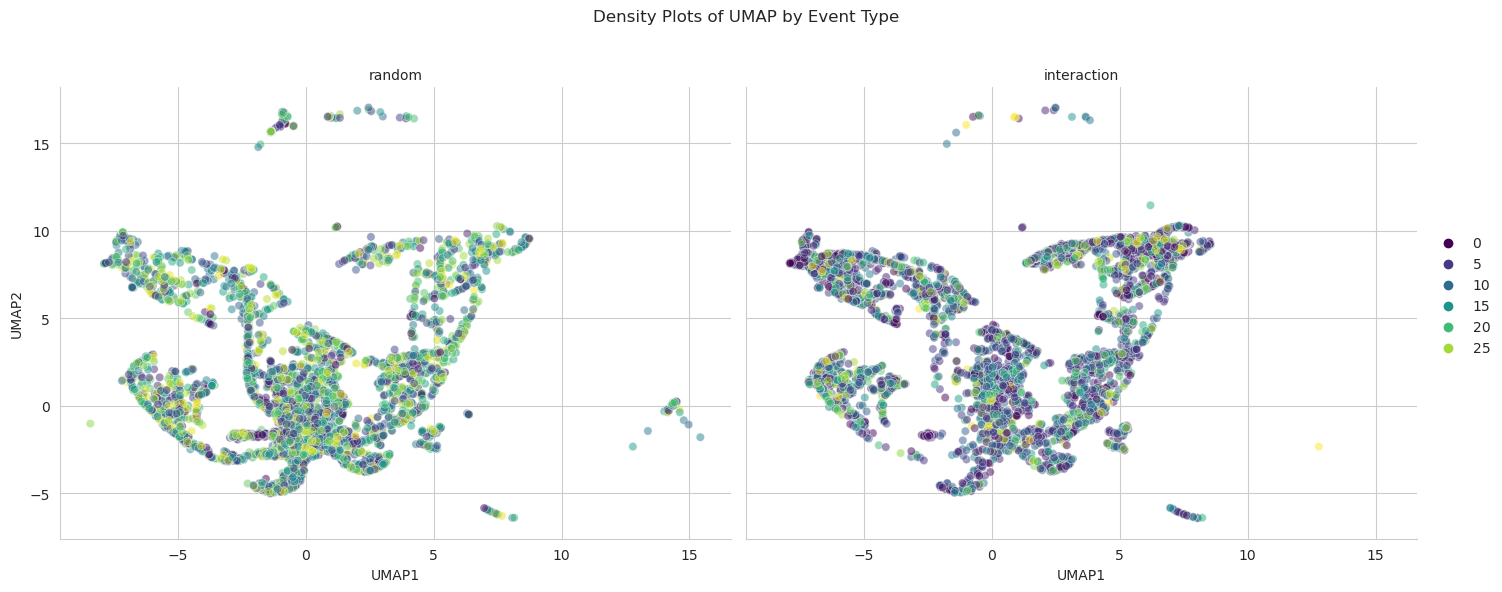

In [44]:
# Plot side by side the umap values of event_type interaction and random with hue being the binned_end_distance
# Create a FacetGrid with two columns, one for each event_type
g = sns.FacetGrid(
    Subset,
    col="event_type",
    sharex=True,
    sharey=True,
    height=6,
    aspect=1.2,
)

# Map the scatterplot to the FacetGrid
g.map_dataframe(
    sns.scatterplot,
    x="UMAP1",
    y="UMAP2",
    hue="binned_start",
    alpha=0.5,
    palette="viridis",
)

# Add titles and adjust layout
g.set_titles(col_template="{col_name}")
g.add_legend()
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Density Plots of UMAP by Event Type")

# Save the plot
plt.savefig(f"{output_dir}/UMAP_event_types_overtime_starttime.png")
plt.show()
plt.close()

In [45]:
# Calculate cluster proportions over time by event type
cluster_proportions = (Subset
                      .groupby(['event_type', 'binned_start', 'cluster'])
                      .size()
                      .reset_index(name='count'))

# Calculate totals for proportions
totals = (cluster_proportions
         .groupby(['event_type', 'binned_start'])['count']
         .sum()
         .reset_index(name='total'))

# Merge and calculate proportions
cluster_proportions = cluster_proportions.merge(
    totals, on=['event_type', 'binned_start'])
cluster_proportions['proportion'] = cluster_proportions['count'] / cluster_proportions['total']

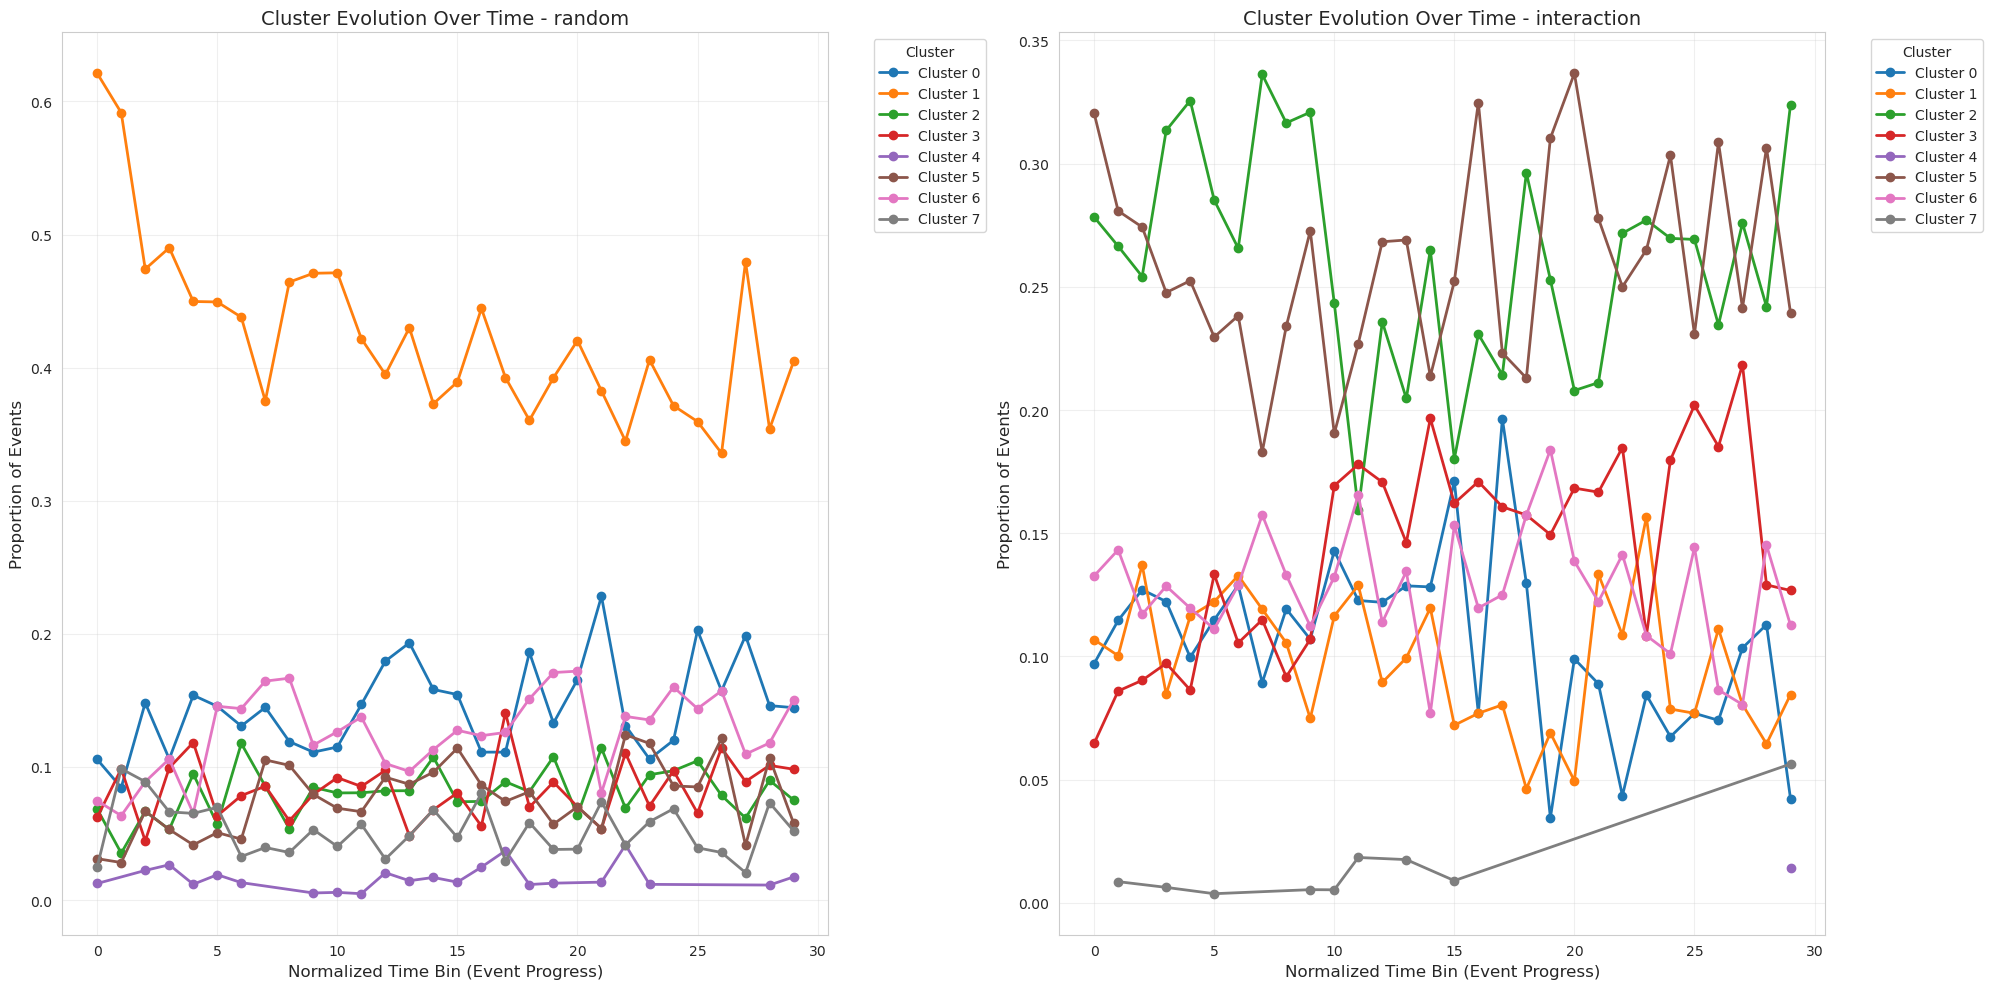

In [46]:
plt.figure(figsize=(20, 10))

for i, event_type in enumerate(Subset["event_type"].unique()):
    plt.subplot(1, 2, i + 1)

    # Filter to just this event type
    event_data = cluster_proportions[cluster_proportions["event_type"] == event_type]

    # Plot a line for each cluster
    for cluster in sorted(Subset["cluster"].unique()):
        cluster_data = event_data[event_data["cluster"] == cluster]
        if not cluster_data.empty:
            plt.plot(
                cluster_data["binned_start"],
                cluster_data["proportion"],
                marker="o",
                linewidth=2,
                label=f"Cluster {cluster}",
            )

    plt.title(f"Cluster Evolution Over Time - {event_type}", fontsize=14)
    plt.xlabel("Normalized Time Bin (Event Progress)", fontsize=12)
    plt.ylabel("Proportion of Events", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.savefig(f"{output_dir}/cluster_evolution_line_plots.png")
plt.show()

In [47]:
# Calculate cluster proportions over time by event type AND fly
fly_cluster_proportions = (
    Subset.groupby(["fly", "event_type", "binned_start", "cluster"])
    .size()
    .reset_index(name="count")
)

# Calculate totals for proportions (per fly and time bin)
fly_totals = (
    fly_cluster_proportions.groupby(["fly", "event_type", "binned_start"])["count"]
    .sum()
    .reset_index(name="total")
)

# Merge and calculate proportions
fly_cluster_proportions = fly_cluster_proportions.merge(
    fly_totals, on=["fly", "event_type", "binned_start"]
)
fly_cluster_proportions["proportion"] = (
    fly_cluster_proportions["count"] / fly_cluster_proportions["total"]
)

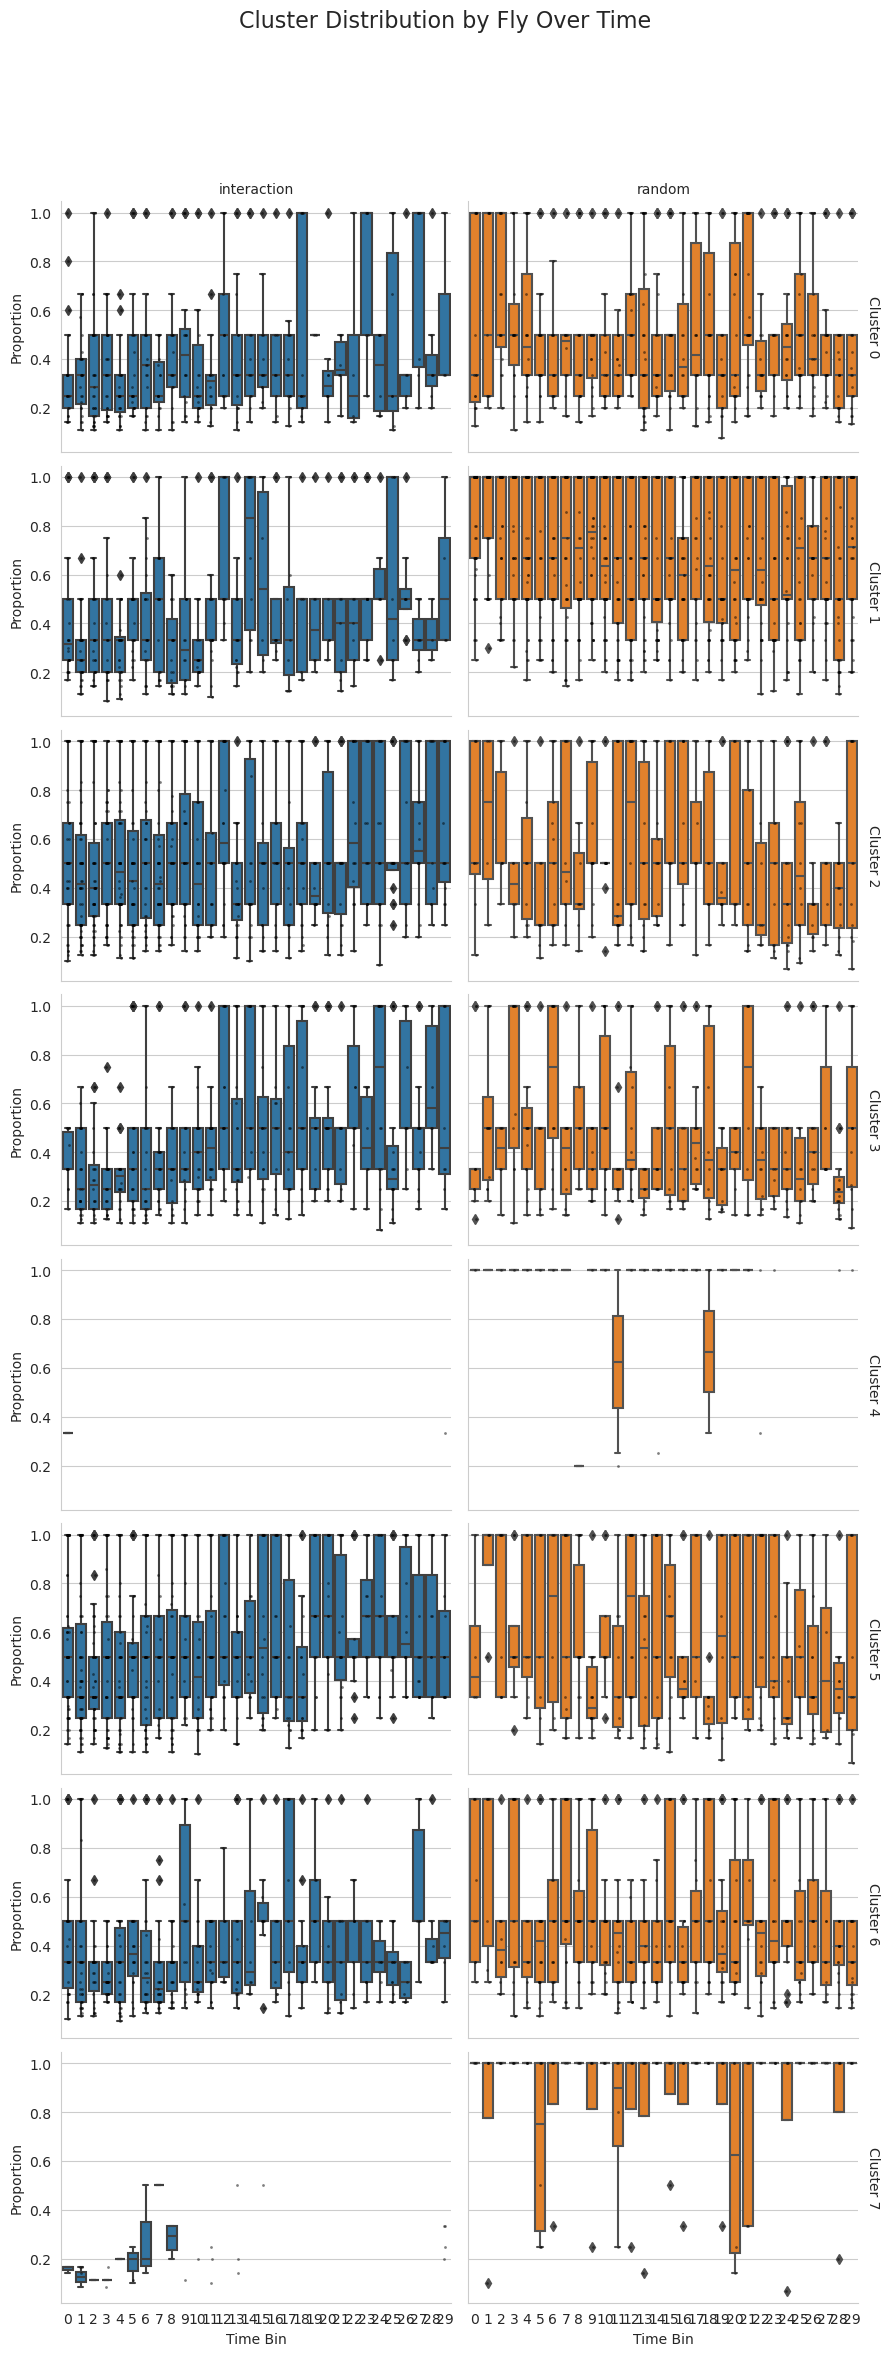

In [48]:
# Create a facet grid of box plots
g = sns.FacetGrid(
    fly_cluster_proportions,
    col="event_type",
    hue="event_type",
    row="cluster",
    margin_titles=True,
    height=3,
    aspect=1.5,
    palette="tab10",
)

# Map the box plot
g.map_dataframe(sns.boxplot, x="binned_start", y="proportion")

# Add strip plot to show individual fly points
g.map_dataframe(
    sns.stripplot,
    x="binned_start",
    y="proportion",
    color="black",
    size=2,
    alpha=0.5,
    jitter=True,
)

# Add titles and labels
g.set_axis_labels("Time Bin", "Proportion")
g.set_titles(col_template="{col_name}", row_template="Cluster {row_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Cluster Distribution by Fly Over Time", fontsize=16)

plt.savefig(f"{output_dir}/cluster_evolution_by_fly_box_plots.png")
plt.show()

Text(94.44444444444444, 0.5, '')

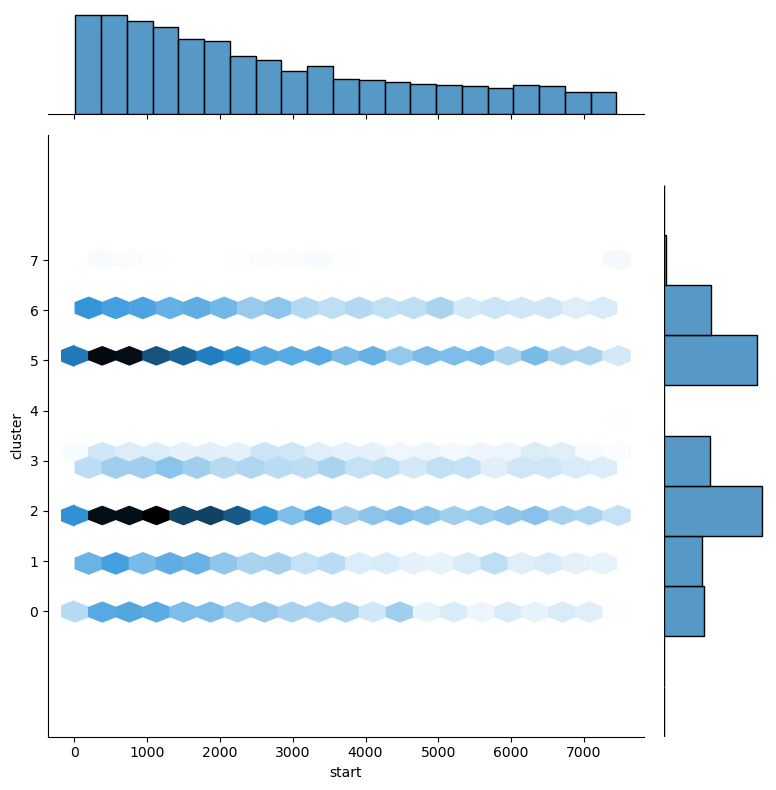

In [ ]:
Subset_interaction = Subset[Subset["event_type"] == "interaction"]


# Create the jointplot and save the grid object
g = sns.jointplot(data=Subset_interaction, x="start", y="cluster", kind="hex", height=8)

# Find min and max cluster values for proper range setting
cluster_min = Subset_interaction["cluster"].min()
cluster_max = Subset_interaction["cluster"].max()

# Clear and recreate the y-marginal histogram with precise bins
g.ax_marg_y.clear()
clusters = sorted(Subset_interaction["cluster"].unique())

bins = np.arange(cluster_min-2.5, cluster_max+2.5, 1)  # This creates exact bin edges

# Use sns.histplot for better styling
sns.histplot(y=Subset_interaction["cluster"], bins=bins, ax=g.ax_marg_y,
             kde=False, edgecolor='black', linewidth=1)

g.ax_joint.set_ylim(cluster_min-2.5, cluster_max+2.5)

# Set the y-ticks on main plot
g.ax_joint.set_yticks(range(cluster_min, cluster_max+1))
g.ax_joint.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}"))

# Completely disable ticks on the marginal plot
g.ax_marg_y.tick_params(axis='both', which='both', length=0, width=0, 
                        labelleft=False, left=False, 
                        labelbottom=False, bottom=False)

# Remove the spines for a cleaner look on the marginal plot
for spine in g.ax_marg_y.spines.values():
    spine.set_visible(False)

# Remove axis labels from the marginal plot
g.ax_marg_y.set_xlabel('')
g.ax_marg_y.set_ylabel('')

# Do the same for the top histogram
g.ax_marg_x.set_xlabel('')
g.ax_marg_x.set_ylabel('')

#plt.savefig(f"{output_dir}/cluster_evolution_jointplot_Interaction_MoreBins.png")

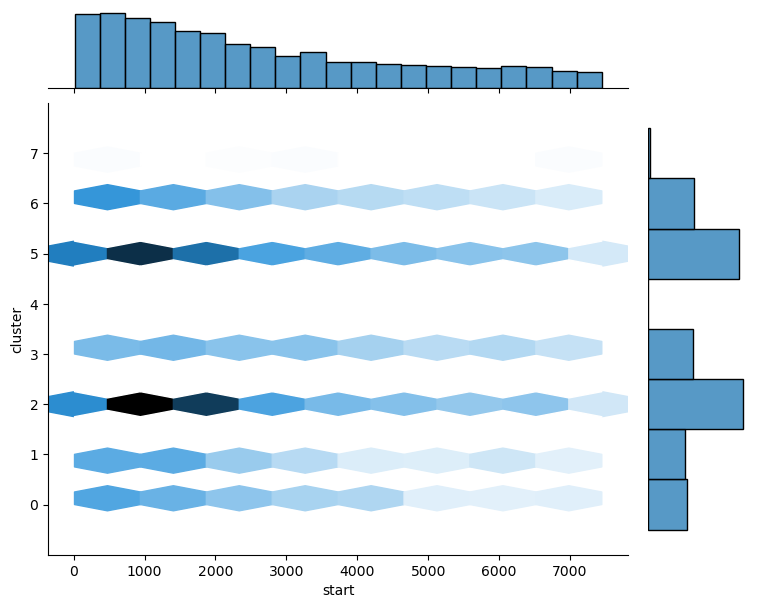

In [87]:
margin_start = 4
margin_end = 4

Subset_interaction = Subset[Subset["event_type"] == "interaction"]

# Convert cluster to categorical for better plotting

Subset_interaction["cluster"] = Subset_interaction["cluster"].astype("category")

# Remove 'aspect' from joint_kws and set it separately
joint_kws = {
    "gridsize": (8, 20),
    "extent": [
        Subset_interaction["start"].min(),
        Subset_interaction["start"].max(),
        0 - margin_start,
        7 + margin_end,
    ],
}

g = sns.jointplot(
    data=Subset_interaction,
    x="start",
    y="cluster",
    kind="hex",
    height=8,
    joint_kws=joint_kws,
)

# Set aspect ratio AFTER plot creation
g.ax_joint.set_aspect("equal")
g.fig.subplots_adjust(left=0.15, right=0.85)  # Compensate for aspect ratio


# Find min and max cluster values for proper range setting
# cluster_min = Subset_interaction["cluster"].min()
# cluster_max = Subset_interaction["cluster"].max()

# Clear and recreate the y-marginal histogram with precise bins
g.ax_marg_y.clear()
clusters = sorted(Subset_interaction["cluster"].unique())

# Calculate the number of bins based on the range of cluster values
# num_bins = int((cluster_max - cluster_min) * 1) + 1  # Double the number of bins

# Create bins with half-step intervals
bins = np.arange(0 - margin_start, 7 + margin_end, 1)  # This creates exact bin edges

# Use sns.histplot with the new bins
sns.histplot(
    y=Subset_interaction["cluster"],
    bins=bins,
    ax=g.ax_marg_y,
    kde=False,
    edgecolor="black",
    linewidth=1,
)

# Set y-axis limits
g.ax_joint.set_ylim(cluster_min - 1, cluster_max + 1)

# Set y-ticks to match cluster values
g.ax_joint.set_yticks(np.arange(cluster_min, cluster_max + 1))

g.ax_joint.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}"))

# Completely disable ticks on the marginal plot
g.ax_marg_y.tick_params(
    axis="both",
    which="both",
    length=0,
    width=0,
    labelleft=False,
    left=False,
    labelbottom=False,
    bottom=False,
)

# Remove the spines for a cleaner look on the marginal plot
for spine in g.ax_marg_y.spines.values():
    spine.set_visible(False)

# Remove axis labels from the marginal plot
g.ax_marg_y.set_xlabel("")
g.ax_marg_y.set_ylabel("")

# Do the same for the top histogram
g.ax_marg_x.set_xlabel("")
g.ax_marg_x.set_ylabel("")

# Adjust the aspect ratio of the joint plot
g.ax_joint.set_aspect('auto')  # This allows the plot to adjust based on the data

# Optional: Fine-tune the figure size if needed
g.fig.set_size_inches(10, 6)  # Adjust these values as needed

# plt.savefig(f"{output_dir}/cluster_evolution_jointplot_Interaction_MoreBins.png")

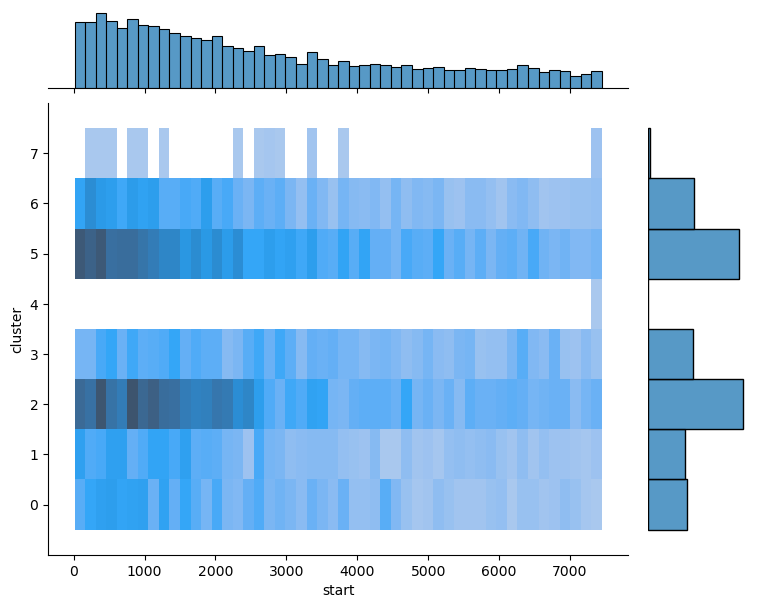

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

margin_start = 4
margin_end = 4

# Filter the subset for interaction events
Subset_interaction = Subset[Subset["event_type"] == "interaction"]

# Convert cluster to categorical for better plotting
Subset_interaction["cluster"] = Subset_interaction["cluster"].astype("category")

# Define the number of bins for x and y axes
x_bins = 50  # Number of bins for the x-axis (start)
y_bins = 20  # Number of bins for the y-axis (cluster)

# Create the jointplot with kind="hist"
g = sns.jointplot(
    data=Subset_interaction,
    x="start",
    y="cluster",
    kind="hist",
    height=8,
    bins=(x_bins, y_bins),  # Set the number of bins for x and y axes
)

# Set aspect ratio AFTER plot creation
g.ax_joint.set_aspect("auto")
g.fig.subplots_adjust(left=0.15, right=0.85)  # Compensate for aspect ratio

# Find min and max cluster values for proper range setting
# cluster_min = Subset_interaction["cluster"].min()
# cluster_max = Subset_interaction["cluster"].max()

# Clear and recreate the y-marginal histogram with precise bins
g.ax_marg_y.clear()
bins = np.arange(0 - margin_start, 7 + margin_end, 1)  # This creates exact bin edges

# Use sns.histplot with the new bins
sns.histplot(
    y=Subset_interaction["cluster"],
    bins=bins,
    ax=g.ax_marg_y,
    kde=False,
    edgecolor="black",
    linewidth=1,
)

# Set y-axis limits
g.ax_joint.set_ylim(cluster_min - 1, cluster_max + 1)

# Set y-ticks to match cluster values
g.ax_joint.set_yticks(np.arange(cluster_min, cluster_max + 1))
g.ax_joint.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}"))

# Completely disable ticks on the marginal plot
g.ax_marg_y.tick_params(
    axis="both",
    which="both",
    length=0,
    width=0,
    labelleft=False,
    left=False,
    labelbottom=False,
    bottom=False,
)

# Remove the spines for a cleaner look on the marginal plot
for spine in g.ax_marg_y.spines.values():
    spine.set_visible(False)

# Remove axis labels from the marginal plot
g.ax_marg_y.set_xlabel("")
g.ax_marg_y.set_ylabel("")

# Do the same for the top histogram
g.ax_marg_x.set_xlabel("")
g.ax_marg_x.set_ylabel("")

# Optional: Fine-tune the figure size if needed
g.fig.set_size_inches(10, 6)  # Adjust these values as needed

# Save the plot
plt.savefig(f"{output_dir}/cluster_evolution_jointplot_Interaction_Hist.png")
plt.show()

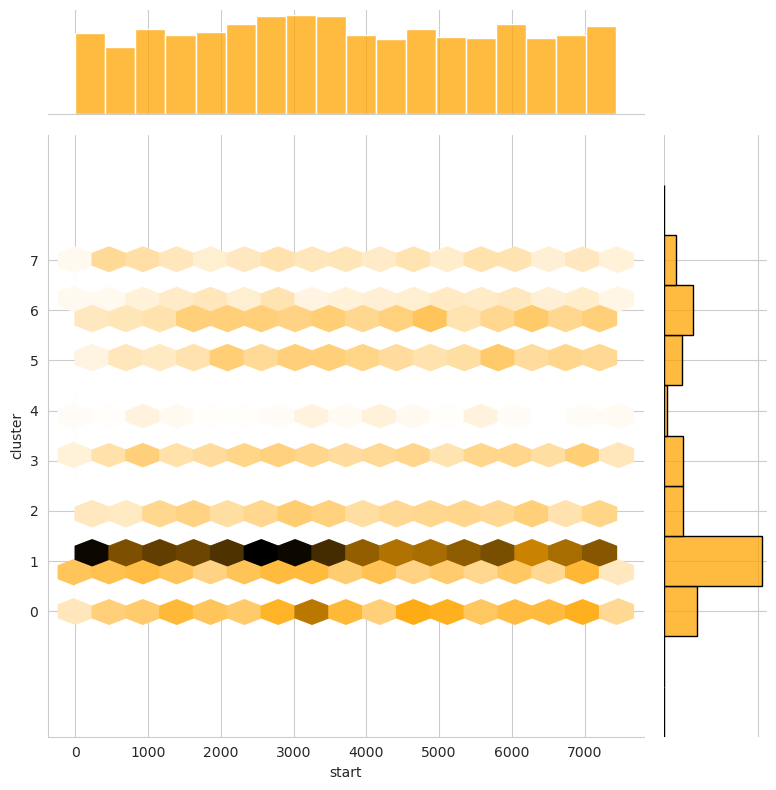

In [50]:
Subset_random = Subset[Subset["event_type"] == "random"]

# Create the jointplot and save the grid object
g = sns.jointplot(data=Subset_random, x="start", y="cluster", kind="hex", height=8, color="orange")

# Find min and max cluster values for proper range setting
cluster_min = Subset_random["cluster"].min()
cluster_max = Subset_random["cluster"].max()

# Clear and recreate the y-marginal histogram with precise bins
g.ax_marg_y.clear()
clusters = sorted(Subset_random["cluster"].unique())

bins = np.arange(cluster_min-2.5, cluster_max+2.5, 1)  # This creates exact bin edges

# Use sns.histplot for better styling
sns.histplot(y=Subset_random["cluster"], bins=bins, ax=g.ax_marg_y,
             kde=False, edgecolor='black', linewidth=1, color="orange")

g.ax_joint.set_ylim(cluster_min-2.5, cluster_max+2.5)

# Set the y-ticks on main plot
g.ax_joint.set_yticks(range(cluster_min, cluster_max+1))
g.ax_joint.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}"))

# Completely disable ticks on the marginal plot
g.ax_marg_y.tick_params(axis='both', which='both', length=0, width=0, 
                        labelleft=False, left=False, 
                        labelbottom=False, bottom=False)

# Remove the spines for a cleaner look on the marginal plot
for spine in g.ax_marg_y.spines.values():
    spine.set_visible(False)

# Remove axis labels from the marginal plot
g.ax_marg_y.set_xlabel('')
g.ax_marg_y.set_ylabel('')

# Do the same for the top histogram
g.ax_marg_x.set_xlabel('')
g.ax_marg_x.set_ylabel('')

plt.savefig(f"{output_dir}/cluster_evolution_jointplot_Random_MoreBins.png")

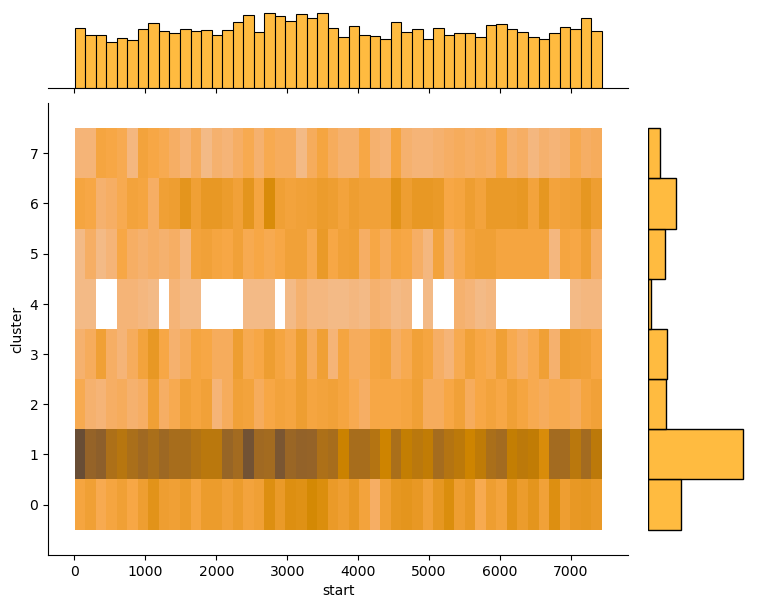

In [93]:
margin_start = 4
margin_end = 4

# Filter the subset for interaction events
Subset_random = Subset[Subset["event_type"] == "random"]

# Convert cluster to categorical for better plotting
Subset_random["cluster"] = Subset_random["cluster"].astype("category")

# Define the number of bins for x and y axes
x_bins = 50  # Number of bins for the x-axis (start)
y_bins = 20  # Number of bins for the y-axis (cluster)

# Create the jointplot with kind="hist"
g = sns.jointplot(
    data=Subset_random,
    x="start",
    y="cluster",
    kind="hist",
    height=8,
    bins=(x_bins, y_bins),  # Set the number of bins for x and y axes
    color="orange"
)

# Set aspect ratio AFTER plot creation
g.ax_joint.set_aspect("auto")
g.fig.subplots_adjust(left=0.15, right=0.85)  # Compensate for aspect ratio

# Find min and max cluster values for proper range setting
# cluster_min = Subset_interaction["cluster"].min()
# cluster_max = Subset_interaction["cluster"].max()

# Clear and recreate the y-marginal histogram with precise bins
g.ax_marg_y.clear()
bins = np.arange(0 - margin_start, 7 + margin_end, 1)  # This creates exact bin edges

# Use sns.histplot with the new bins
sns.histplot(
    y=Subset_random["cluster"],
    bins=bins,
    ax=g.ax_marg_y,
    kde=False,
    edgecolor="black",
    linewidth=1,
    color="orange"
)

# Set y-axis limits
g.ax_joint.set_ylim(cluster_min - 1, cluster_max + 1)

# Set y-ticks to match cluster values
g.ax_joint.set_yticks(np.arange(cluster_min, cluster_max + 1))
g.ax_joint.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}"))

# Completely disable ticks on the marginal plot
g.ax_marg_y.tick_params(
    axis="both",
    which="both",
    length=0,
    width=0,
    labelleft=False,
    left=False,
    labelbottom=False,
    bottom=False,
)

# Remove the spines for a cleaner look on the marginal plot
for spine in g.ax_marg_y.spines.values():
    spine.set_visible(False)

# Remove axis labels from the marginal plot
g.ax_marg_y.set_xlabel("")
g.ax_marg_y.set_ylabel("")

# Do the same for the top histogram
g.ax_marg_x.set_xlabel("")
g.ax_marg_x.set_ylabel("")

# Optional: Fine-tune the figure size if needed
g.fig.set_size_inches(10, 6)  # Adjust these values as needed

# Save the plot
plt.savefig(f"{output_dir}/cluster_evolution_jointplot_Random_Hist.png")
plt.show()

Text(0.5, 0.98, 'Distribution of Clusters Across start times by Event Type')

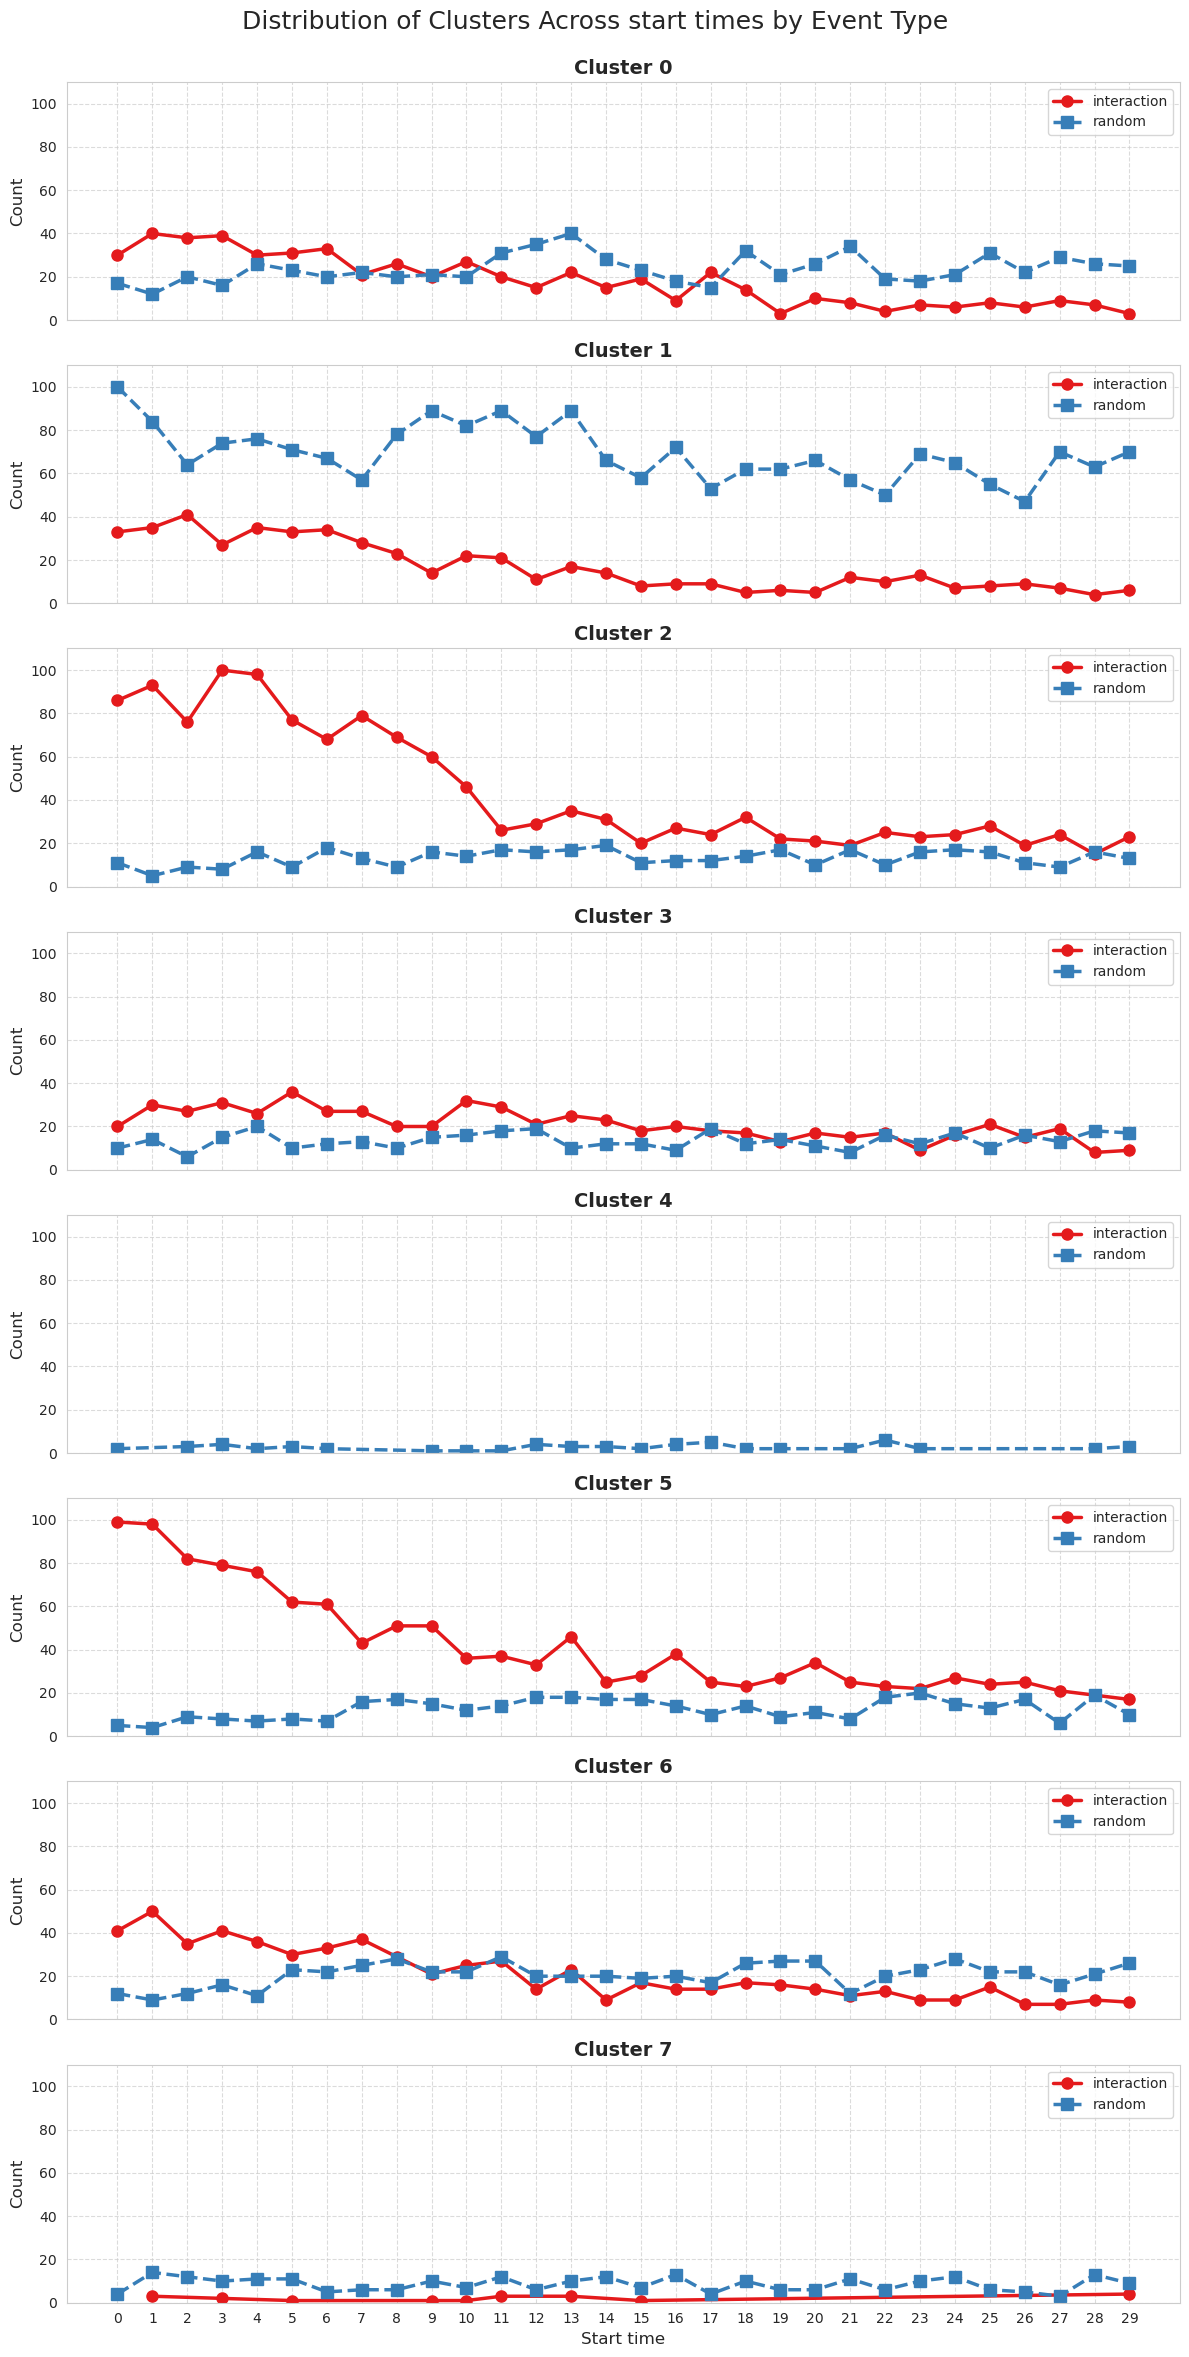

In [51]:
# Get all unique values from your dataset
clusters = sorted(Subset['cluster'].unique())
event_types = sorted(Subset['event_type'].unique())

# Count occurrences for each cluster, event_type, event_id combination
counts = Subset.groupby(['cluster', 'event_type', 'binned_start']).size().reset_index(name='count')

# Find global maximum count for consistent y-axis scaling
max_count = counts['count'].max()

# Create a color palette for event types
colors = sns.color_palette("Set1", len(event_types))
event_type_colors = dict(zip(event_types, colors))

# Additional styling options for better differentiation
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D', '*', 'p', 'h']

# Ensure we have enough styles 
if len(event_types) > len(line_styles):
    line_styles = line_styles * (len(event_types) // len(line_styles) + 1)
if len(event_types) > len(markers):
    markers = markers * (len(event_types) // len(markers) + 1)

# Create mappings
event_type_styles = dict(zip(event_types, line_styles[:len(event_types)]))
event_type_markers = dict(zip(event_types, markers[:len(event_types)]))

# Create the figure and axes grid - one subplot per cluster
fig, axes = plt.subplots(len(clusters), 1, 
                       figsize=(12, 3 * len(clusters)),
                       sharex=True, sharey=True)  # Share both axes

# Ensure axes is always an array
if len(clusters) == 1:
    axes = np.array([axes])

# Get all unique event_ids across all event types
all_event_ids = sorted(Subset['binned_start'].unique())

# Plot each cluster
for i, cluster in enumerate(clusters):
    ax = axes[i]
    
    # Loop through each event type and plot on the same axes with different colors and styles
    for j, event_type in enumerate(event_types):
        # Get data for this cluster and event type
        facet_data = counts[(counts['cluster'] == cluster) & 
                         (counts['event_type'] == event_type)]
        
        # Sort by event_id for proper plotting
        facet_data = facet_data.sort_values('binned_start')
        
        # Plot if there's data
        if len(facet_data) > 0:
            # Use line plot with markers to show evolution
            ax.plot(facet_data['binned_start'], facet_data['count'], 
                   marker=event_type_markers[event_type], markersize=8, 
                   linestyle=event_type_styles[event_type], linewidth=2.5, 
                   color=event_type_colors[event_type],
                   label=f"{event_type}")
    
    # Set labels and title for subplot
    ax.set_title(f"Cluster {cluster}", fontsize=14, fontweight='bold')
    ax.set_ylabel("Count", fontsize=12)
    if i == len(clusters) - 1:
        ax.set_xlabel("Start time", fontsize=12)
        
    # Add grid for readability
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Set y-axis limits to be the same for all subplots
    ax.set_ylim(0, max(1, max_count * 1.1))  # Add 10% padding
    
    # Set x-axis to include all event IDs
    ax.set_xticks(all_event_ids)
    
    # Add legend to each subplot
    ax.legend(loc='upper right')

# Adjust layout
plt.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle('Distribution of Clusters Across start times by Event Type', fontsize=18)

Text(0.5, 0.98, 'Proportion of Clusters over time (% of total events)')

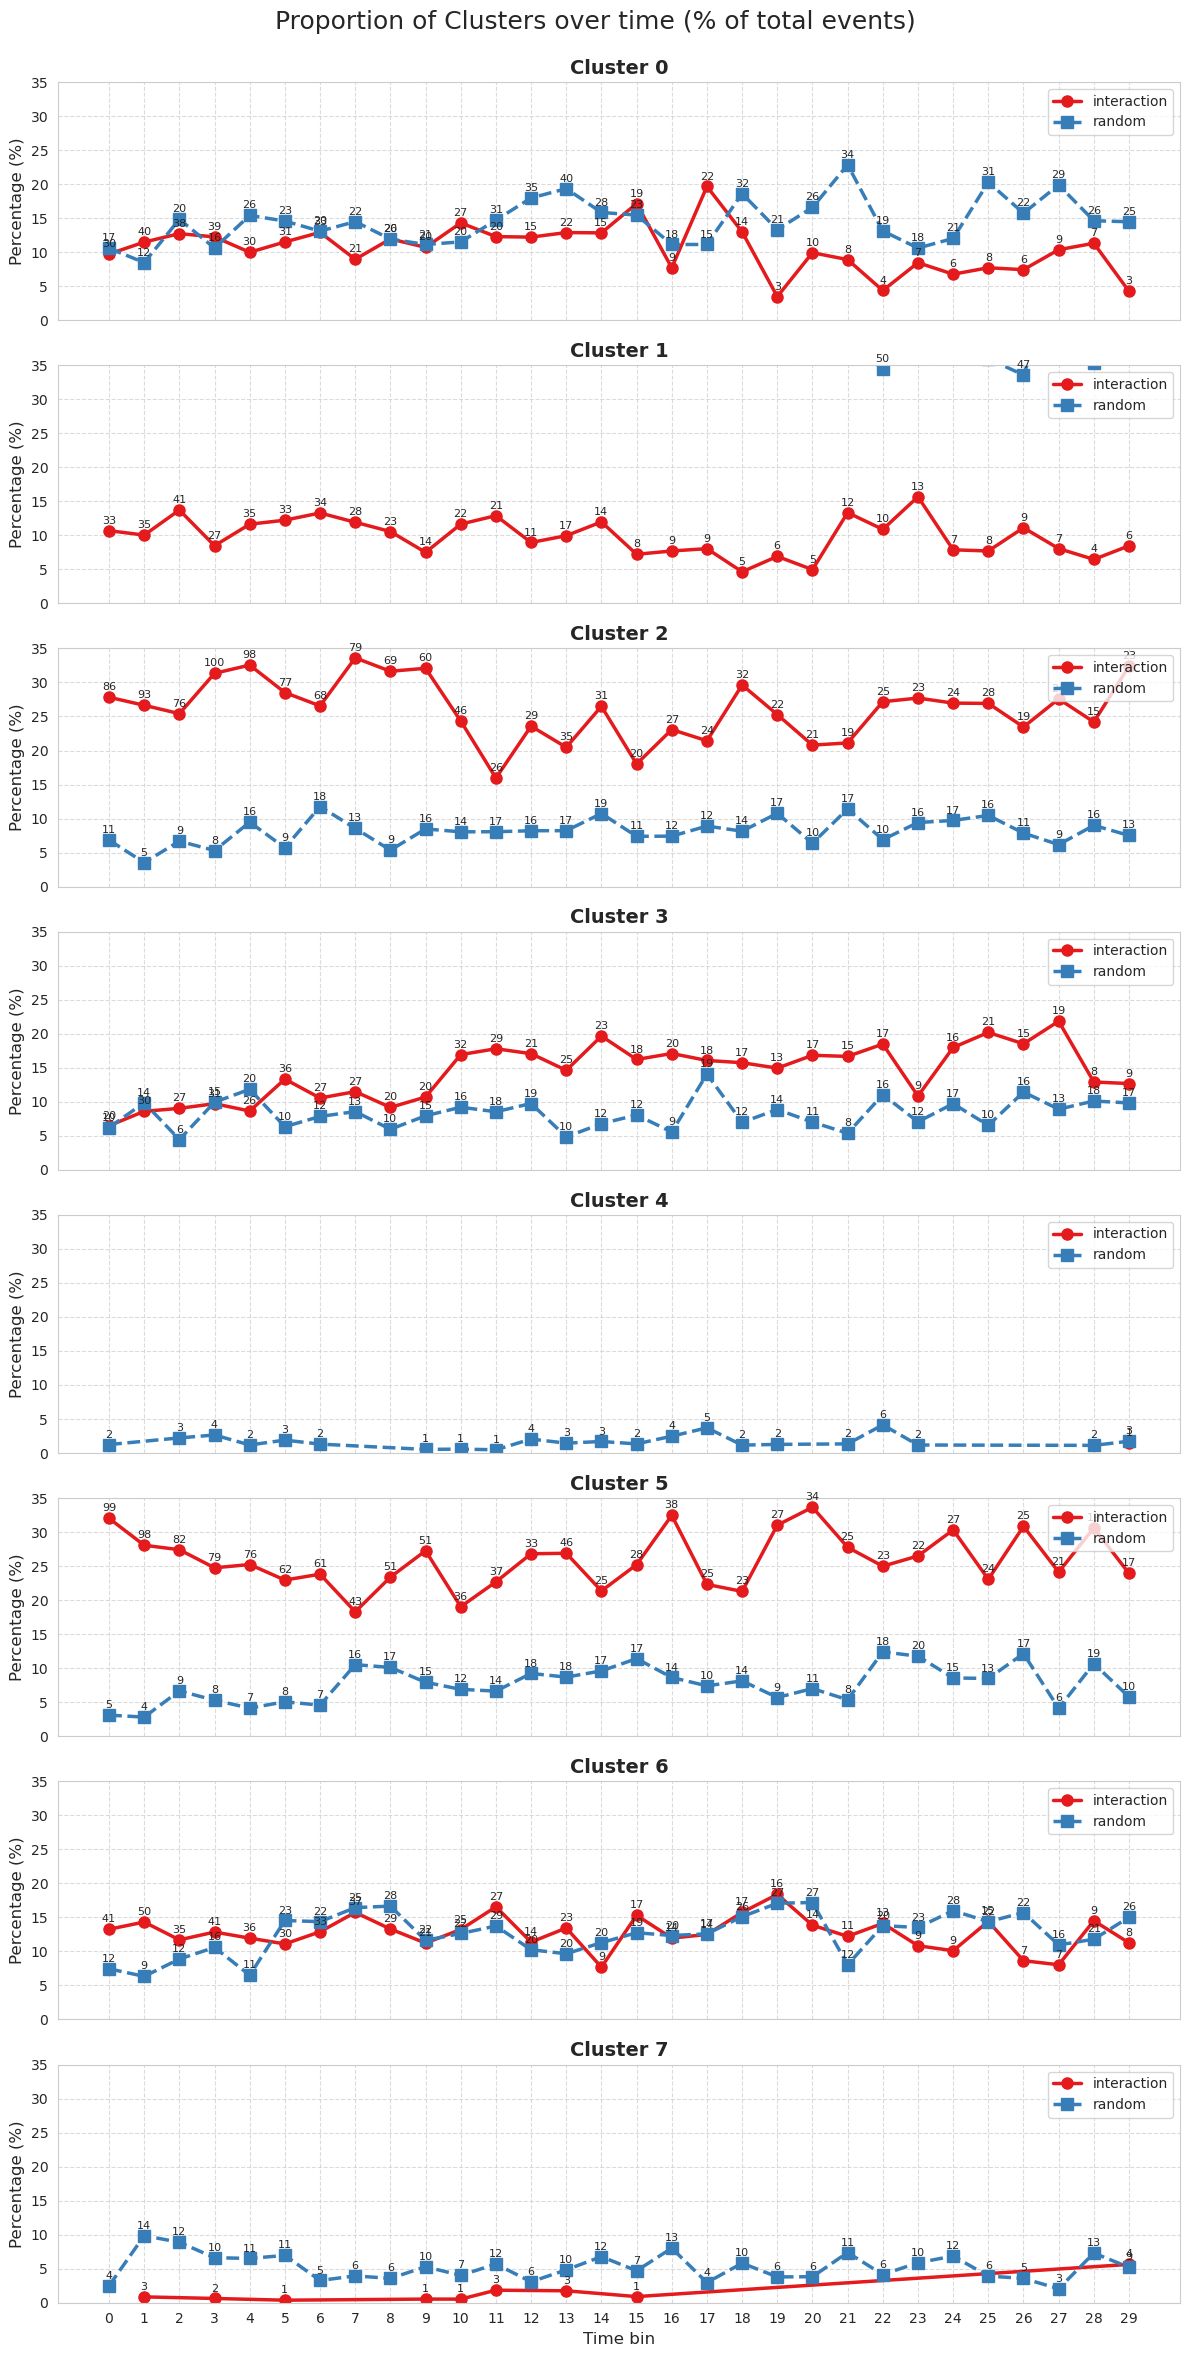

In [53]:
# Get all unique values from your dataset
clusters = sorted(Subset['cluster'].unique())

# IMPORTANT FIX: Use the correct column for event_types
# If you have an actual event_type column:
event_types = sorted(Subset['event_type'].unique())
# OR if you want to just use the time bins as your "event types":
# event_types = sorted(Subset['binned_start'].unique())

# Count occurrences for each cluster, event_type, binned_start combination
counts = Subset.groupby(['cluster', 'event_type', 'binned_start']).size().reset_index(name='count')

# Calculate total events for each binned_start and event_type combination
totals = Subset.groupby(['event_type', 'binned_start']).size().reset_index(name='total')

# Merge totals with counts to calculate proportions
counts = counts.merge(totals, on=['event_type', 'binned_start'], how='left')
counts['proportion'] = counts['count'] / counts['total'] * 100  # Convert to percentage

# Create a color palette for event types
colors = sns.color_palette("Set1", len(event_types))
event_type_colors = dict(zip(event_types, colors))

# Additional styling options for better differentiation
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D', '*', 'p', 'h']

# Ensure we have enough styles 
if len(event_types) > len(line_styles):
    line_styles = line_styles * (len(event_types) // len(line_styles) + 1)
if len(event_types) > len(markers):
    markers = markers * (len(event_types) // len(markers) + 1)

# Create mappings
event_type_styles = dict(zip(event_types, line_styles[:len(event_types)]))
event_type_markers = dict(zip(event_types, markers[:len(event_types)]))

# Create the figure and axes grid - one subplot per cluster
fig, axes = plt.subplots(len(clusters), 1, 
                       figsize=(12, 3 * len(clusters)),
                       sharex=True, sharey=True)  # Share both axes

# Ensure axes is always an array
if len(clusters) == 1:
    axes = np.array([axes])

# Get all unique binned_start values
all_bins = sorted(Subset['binned_start'].unique())

# Plot each cluster
for i, cluster in enumerate(clusters):
    ax = axes[i]
    legend_handles = []  # Track if we actually add any plots
    
    # Loop through each event type and plot on the same axes with different colors and styles
    for j, event_type in enumerate(event_types):
        # Get data for this cluster and event type
        facet_data = counts[(counts['cluster'] == cluster) & 
                         (counts['event_type'] == event_type)]
        
        # Sort by binned_start for proper plotting
        facet_data = facet_data.sort_values('binned_start')
        
        # Plot if there's data
        if len(facet_data) > 0:
            # Use line plot with markers to show evolution, using the proportion
            line, = ax.plot(facet_data['binned_start'], facet_data['proportion'], 
                   marker=event_type_markers[event_type], markersize=8, 
                   linestyle=event_type_styles[event_type], linewidth=2.5, 
                   color=event_type_colors[event_type],
                   label=f"{event_type}")
            
            legend_handles.append(line)
            
            # Option: Add text labels showing the raw counts for context
            for idx, row in facet_data.iterrows():
                ax.annotate(f"{int(row['count'])}", 
                          (row['binned_start'], row['proportion']),
                          textcoords="offset points", 
                          xytext=(0,5), 
                          ha='center',
                          fontsize=8)
    
    # Set labels and title for subplot
    ax.set_title(f"Cluster {cluster}", fontsize=14, fontweight='bold')
    ax.set_ylabel("Percentage (%)", fontsize=12)
    if i == len(clusters) - 1:
        ax.set_xlabel("Time bin", fontsize=12)
        
    # Add grid for readability
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Set y-axis limits to 0-30%
    ax.set_ylim(0, 35)  
    
    # Set x-axis to include all bins
    ax.set_xticks(all_bins)
    
    # Only add legend if we have plotted data
    if legend_handles:
        ax.legend(loc='upper right')

# Adjust layout
plt.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle('Proportion of Clusters over time (% of total events)', fontsize=18)


Text(0.5, 0.98, 'Proportion of Clusters over time (% of total events) by light')

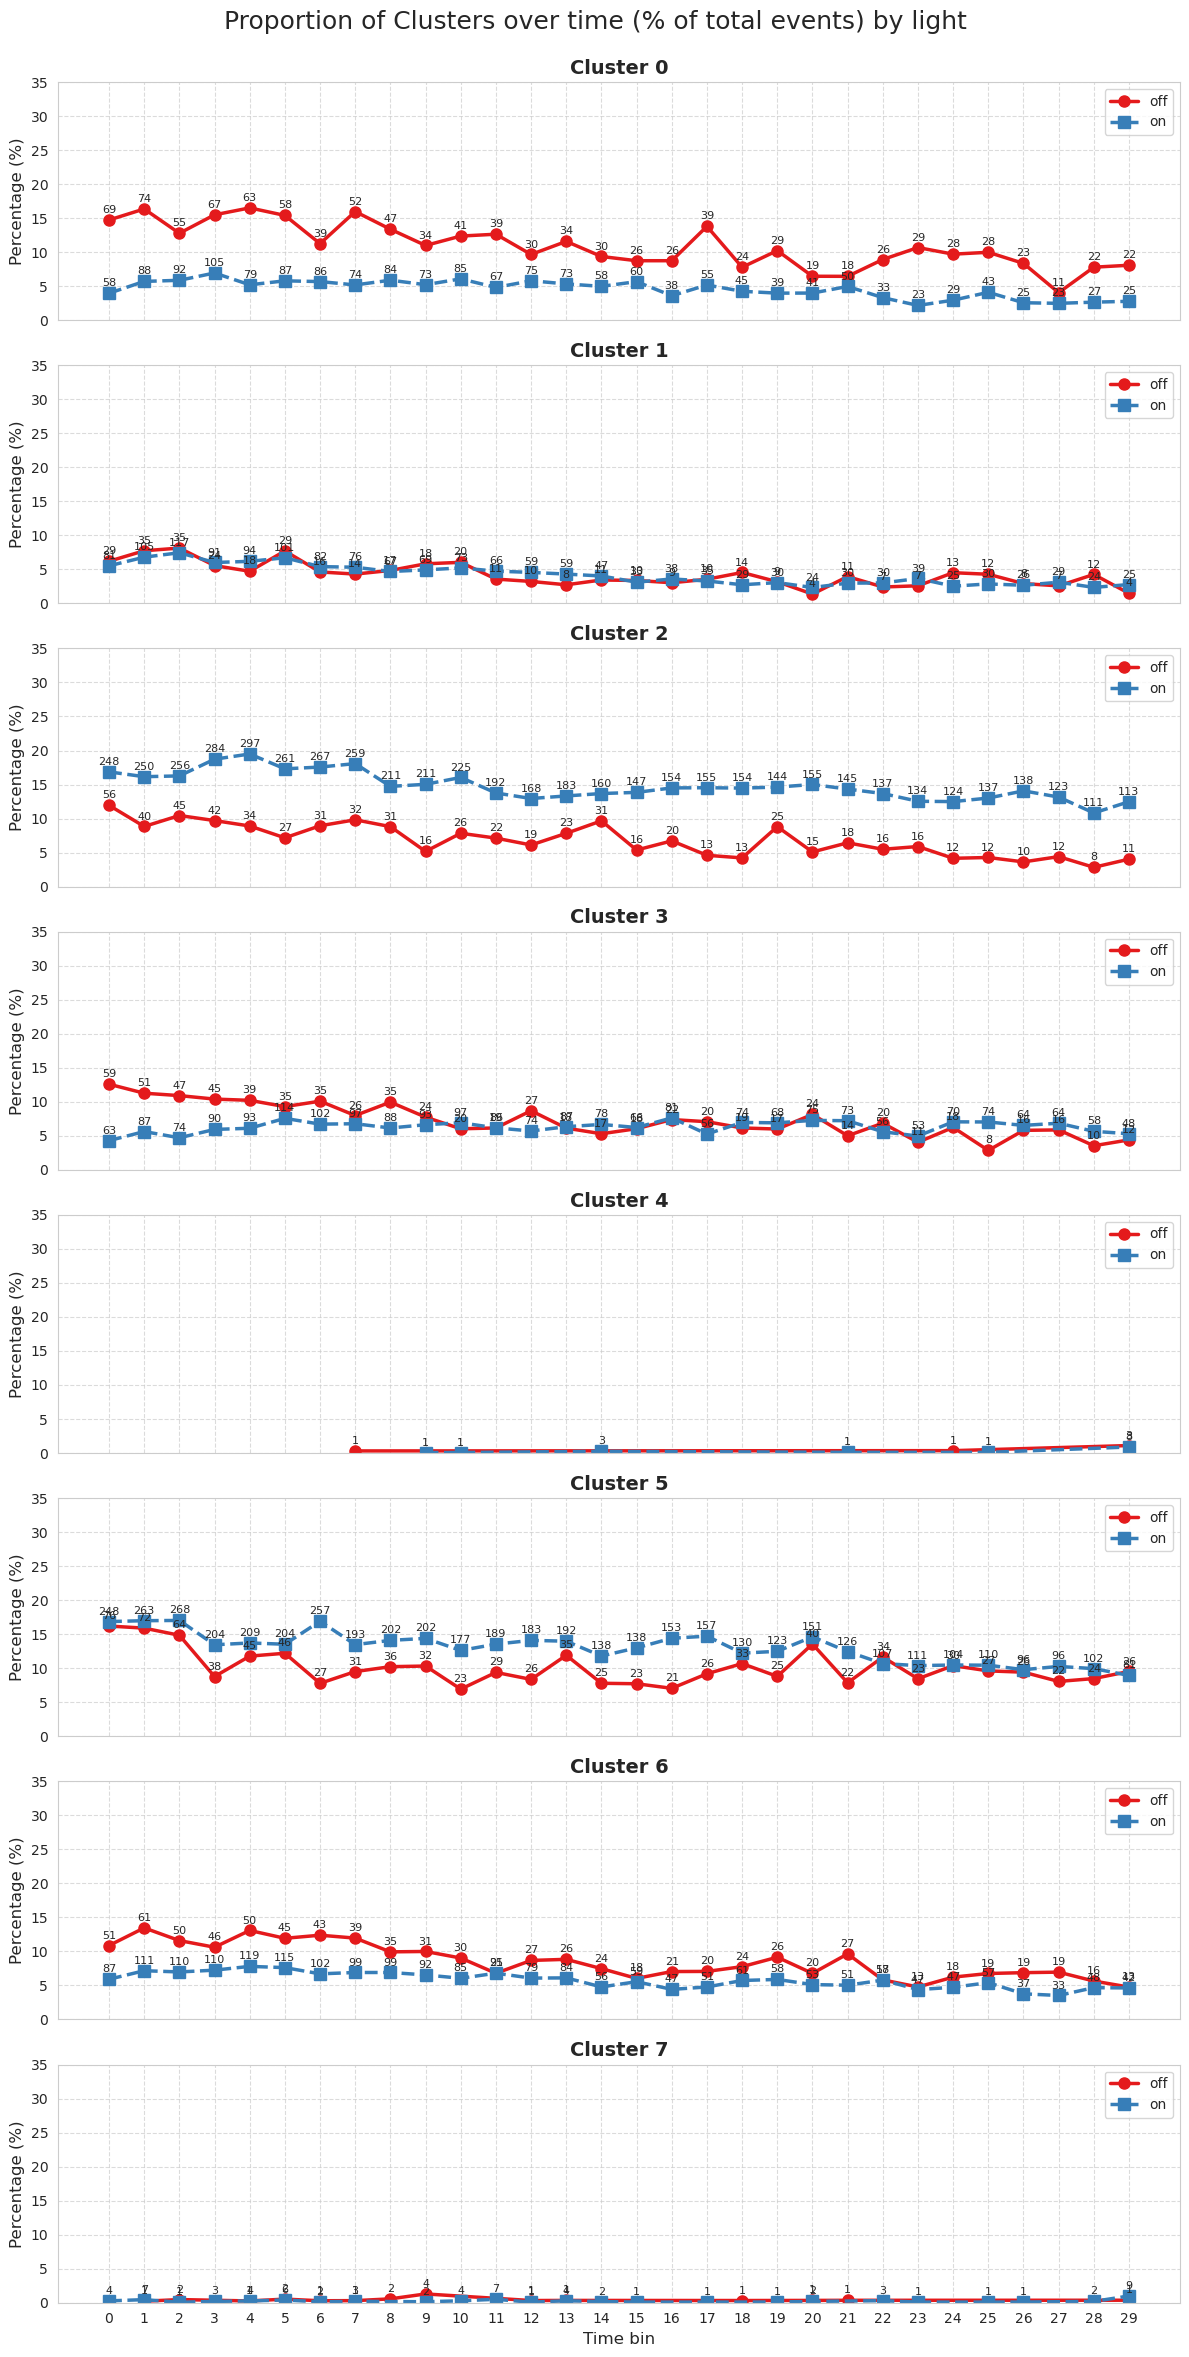

In [119]:
bin_metric(Umap_light, "start", 30)

Subset_light_interaction = Umap_light[Umap_light["event_type"] == "interaction"]

# Get all unique values from your dataset
clusters = sorted(Subset_light_interaction["cluster"].unique())

# IMPORTANT FIX: Use the correct column for event_types
# If you have an actual event_type column:
event_types = sorted(Subset_light_interaction["Light"].unique())
# OR if you want to just use the time bins as your "event types":
# event_types = sorted(Subset['binned_start'].unique())

# Count occurrences for each cluster, event_type, binned_start combination
counts = (
    Subset_light_interaction.groupby(["cluster", "Light", "binned_start"])
    .size()
    .reset_index(name="count")
)

# Calculate total events for each binned_start and event_type combination
totals = Umap.groupby(["Light", "binned_start"]).size().reset_index(name="total")

# Merge totals with counts to calculate proportions
counts = counts.merge(totals, on=["Light", "binned_start"], how="left")
counts["proportion"] = counts["count"] / counts["total"] * 100  # Convert to percentage

# Create a color palette for event types
colors = sns.color_palette("Set1", len(event_types))
event_type_colors = dict(zip(event_types, colors))

# Additional styling options for better differentiation
line_styles = ["-", "--", "-.", ":"]
markers = ["o", "s", "^", "D", "*", "p", "h"]

# Ensure we have enough styles
if len(event_types) > len(line_styles):
    line_styles = line_styles * (len(event_types) // len(line_styles) + 1)
if len(event_types) > len(markers):
    markers = markers * (len(event_types) // len(markers) + 1)

# Create mappings
event_type_styles = dict(zip(event_types, line_styles[: len(event_types)]))
event_type_markers = dict(zip(event_types, markers[: len(event_types)]))

# Create the figure and axes grid - one subplot per cluster
fig, axes = plt.subplots(
    len(clusters), 1, figsize=(12, 3 * len(clusters)), sharex=True, sharey=True
)  # Share both axes

# Ensure axes is always an array
if len(clusters) == 1:
    axes = np.array([axes])

# Get all unique binned_start values
all_bins = sorted(Subset["binned_start"].unique())

# Plot each cluster
for i, cluster in enumerate(clusters):
    ax = axes[i]
    legend_handles = []  # Track if we actually add any plots

    # Loop through each event type and plot on the same axes with different colors and styles
    for j, event_type in enumerate(event_types):
        # Get data for this cluster and event type
        facet_data = counts[
            (counts["cluster"] == cluster) & (counts["Light"] == event_type)
        ]

        # Sort by binned_start for proper plotting
        facet_data = facet_data.sort_values("binned_start")

        # Plot if there's data
        if len(facet_data) > 0:
            # Use line plot with markers to show evolution, using the proportion
            (line,) = ax.plot(
                facet_data["binned_start"],
                facet_data["proportion"],
                marker=event_type_markers[event_type],
                markersize=8,
                linestyle=event_type_styles[event_type],
                linewidth=2.5,
                color=event_type_colors[event_type],
                label=f"{event_type}",
            )

            legend_handles.append(line)

            # Option: Add text labels showing the raw counts for context
            for idx, row in facet_data.iterrows():
                ax.annotate(
                    f"{int(row['count'])}",
                    (row["binned_start"], row["proportion"]),
                    textcoords="offset points",
                    xytext=(0, 5),
                    ha="center",
                    fontsize=8,
                )

    # Set labels and title for subplot
    ax.set_title(f"Cluster {cluster}", fontsize=14, fontweight="bold")
    ax.set_ylabel("Percentage (%)", fontsize=12)
    if i == len(clusters) - 1:
        ax.set_xlabel("Time bin", fontsize=12)

    # Add grid for readability
    ax.grid(True, linestyle="--", alpha=0.7)

    # Set y-axis limits to 0-30%
    ax.set_ylim(0, 35)

    # Set x-axis to include all bins
    ax.set_xticks(all_bins)

    # Only add legend if we have plotted data
    if legend_handles:
        ax.legend(loc="upper right")

# Adjust layout
plt.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle("Proportion of Clusters over time (% of total events) by light", fontsize=18)

## Checking clusters "efficiency"

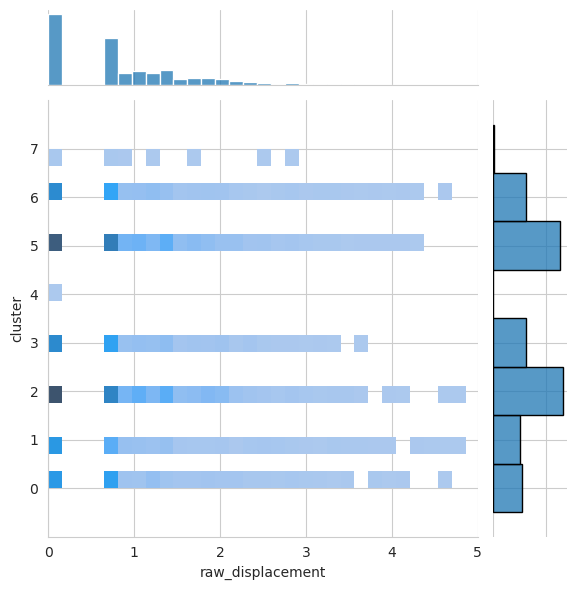

In [54]:
Subset_interaction = Subset[Subset["event_type"] == "interaction"]

# Create the jointplot and save the grid object
g = sns.jointplot(data=Subset_interaction, x=np.log1p(Subset_interaction["raw_displacement"]), y="cluster", kind="hist")

# Find min and max cluster values for proper range setting
cluster_min = Subset_interaction["cluster"].min()
cluster_max = Subset_interaction["cluster"].max()

# Clear and recreate the y-marginal histogram with precise bins
g.ax_marg_y.clear()
clusters = sorted(Subset_interaction["cluster"].unique())
bins = np.arange(min(clusters)-0.5, max(clusters)+1.5, 1)

# Use sns.histplot for better styling
sns.histplot(y=Subset_interaction["cluster"], bins=bins, ax=g.ax_marg_y,
             kde=False, edgecolor='black', linewidth=1)

# Set the y-axis limits on main plot
g.ax_joint.set_ylim(cluster_min-1, cluster_max+1)

# Set the y-ticks on main plot
g.ax_joint.set_xlim(0, 5)

# Set the y-ticks on main plot
g.ax_joint.set_yticks(range(cluster_min, cluster_max+1))
g.ax_joint.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}"))

# Completely disable ticks on the marginal plot
g.ax_marg_y.tick_params(axis='both', which='both', length=0, width=0, 
                        labelleft=False, left=False, 
                        labelbottom=False, bottom=False)

# Remove the spines for a cleaner look on the marginal plot
for spine in g.ax_marg_y.spines.values():
    spine.set_visible(False)

# Remove axis labels from the marginal plot
g.ax_marg_y.set_xlabel('')
g.ax_marg_y.set_ylabel('')

# Do the same for the top histogram
g.ax_marg_x.set_xlabel('')
g.ax_marg_x.set_ylabel('')

plt.savefig(f"{output_dir}/cluster_efficiency_jointplot_Interaction.png")

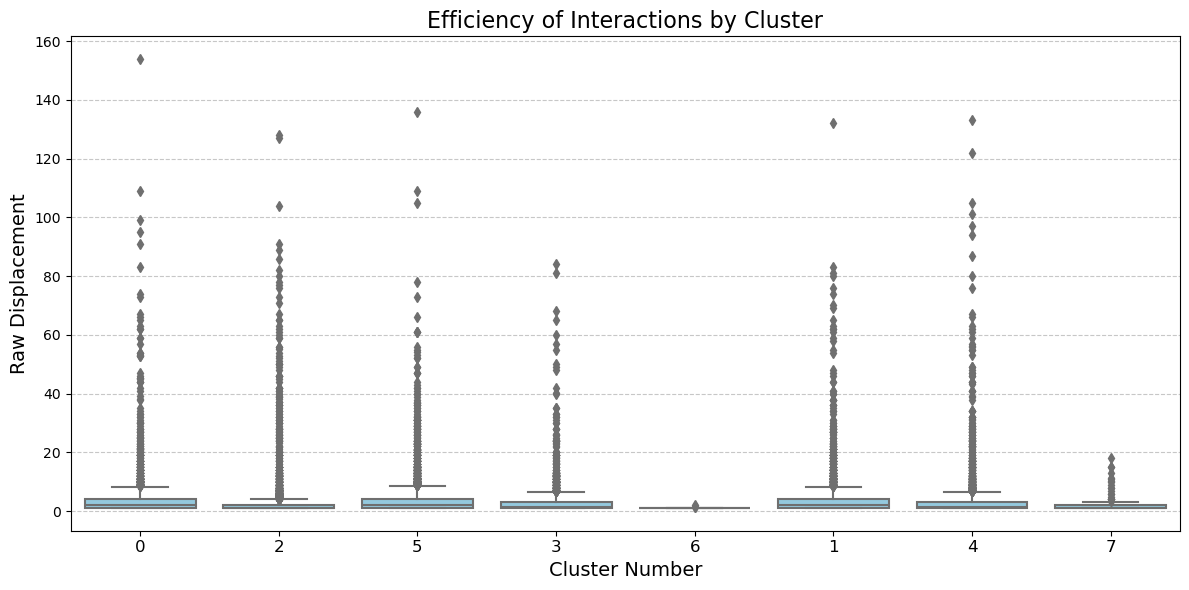

In [95]:
# Let's rank the clusters by the median efficiency of interactions

Subset_positive = Umap[Umap["raw_displacement"] > 0]

# Rank the clusters by median efficiency

cluster_ranking = Subset_positive.groupby("cluster")["raw_displacement"].median().sort_values(ascending=False)

# Get the order of the clusters

cluster_order = cluster_ranking.index

# Make a boxplot of the raw_displacement by cluster
plt.figure(figsize=(12, 6))

sns.boxplot(data=Subset_positive, x="cluster", y="raw_displacement", color="skyblue")

plt.title("Efficiency of Interactions by Cluster", fontsize=16)
plt.xlabel("Cluster Number", fontsize=14)
plt.ylabel("Raw Displacement", fontsize=14)

plt.xticks(range(len(cluster_order)), cluster_order, fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

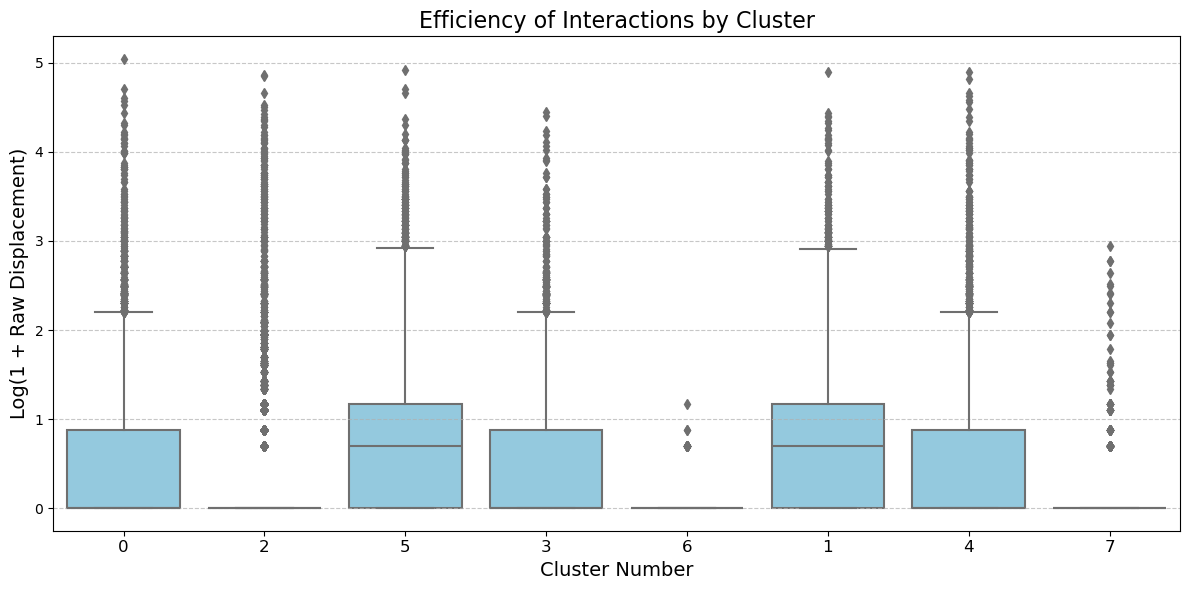

In [96]:
# Log version

Umap["log_displacement"] = np.log1p(Umap["raw_displacement"])

# Make a boxplot of the log_displacement by cluster

plt.figure(figsize=(12, 6))

sns.boxplot(data=Umap, x="cluster", y="log_displacement", color="skyblue")

plt.title("Efficiency of Interactions by Cluster", fontsize=16)

plt.xlabel("Cluster Number", fontsize=14)

plt.ylabel("Log(1 + Raw Displacement)", fontsize=14)

plt.xticks(range(len(cluster_order)), cluster_order, fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

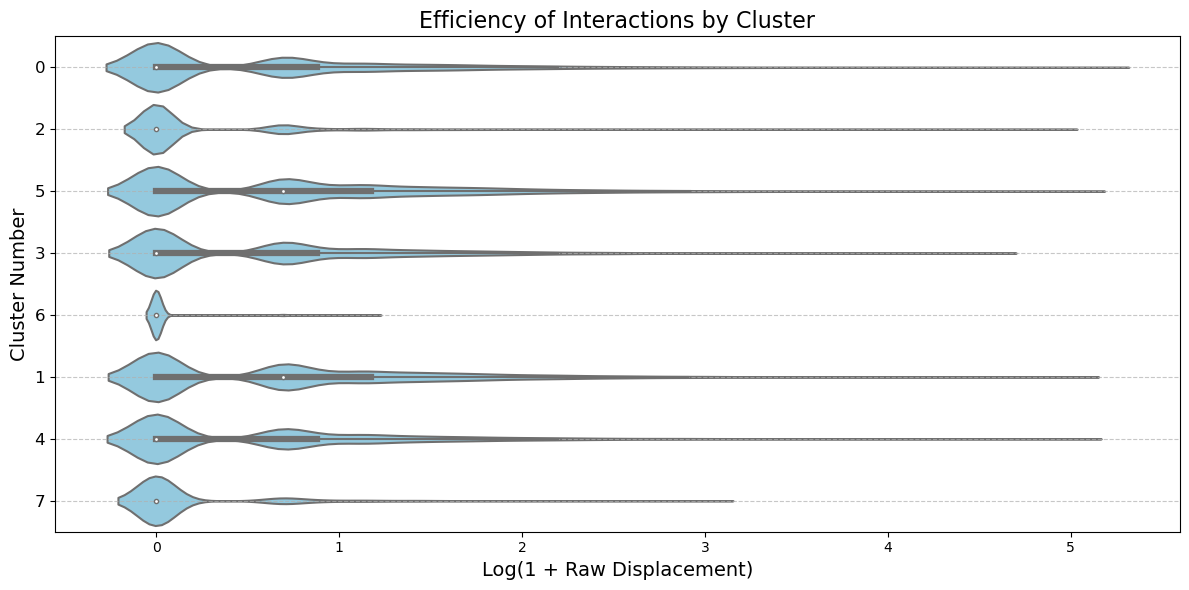

In [105]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=Umap, x="log_displacement", y="cluster", color="skyblue", orient="h", scale="width", width=0.8)
plt.title("Efficiency of Interactions by Cluster", fontsize=16)
plt.ylabel("Cluster Number", fontsize=14)
plt.xlabel("Log(1 + Raw Displacement)", fontsize=14)
plt.yticks(range(len(cluster_order)), cluster_order, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

Cluster 1: [0.89261115 1.33197261]
Cluster 5: [2.29329819 2.80636755]
Cluster 2: [2.38010361 2.93947778]
Cluster 3: [1.36975246 1.77117728]
Cluster 6: [1.82300315 2.5796986 ]
Cluster 0: [1.70702089 2.33807683]
Cluster 7: [0.5564752  0.94879685]
Cluster 4: [0. 0.]


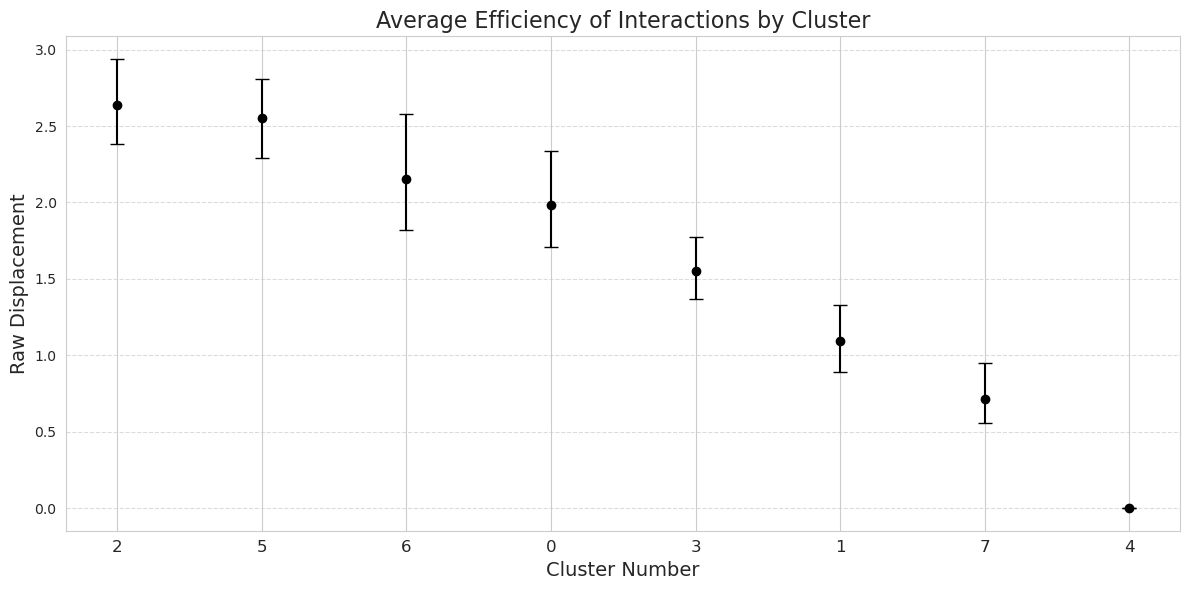

In [57]:
# Let's compute bootstrapped confidence intervals for average efficiency of interactions per cluster

clusters_bs_ci = {}

for cluster in Subset["cluster"].unique():
    cluster_data = Subset[Subset["cluster"] == cluster]
    
    bs_ci = Processing.draw_bs_ci(cluster_data["raw_displacement"], np.mean)
    
    clusters_bs_ci[cluster] = bs_ci
    
    print(f"Cluster {cluster}: {bs_ci}")
    
# Rank the clusters by the average efficiency of interactions

cluster_ranking = {cluster: np.mean(ci) for cluster, ci in clusters_bs_ci.items()}

cluster_order = [cluster for cluster, _ in sorted(cluster_ranking.items(), key=lambda x: x[1], reverse=True)]
    
    
# Let's plot the average efficiency of interactions per cluster with bootstrapped confidence intervals

plt.figure(figsize=(12, 6))

# Plot the bootstrapped confidence intervals
for cluster in cluster_order:
    low, high = clusters_bs_ci[cluster]
    mean_value = Subset[Subset["cluster"] == cluster]["raw_displacement"].mean()
    plt.errorbar(cluster_order.index(cluster), mean_value, yerr=[[mean_value - low], [high - mean_value]], fmt='o', color='black', capsize=5)

plt.title("Average Efficiency of Interactions by Cluster", fontsize=16)
plt.xlabel("Cluster Number", fontsize=14)
plt.ylabel("Raw Displacement", fontsize=14)
plt.xticks(range(len(cluster_order)), cluster_order, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the plot
plt.savefig(f"{output_dir}/average_efficiency_interactions_by_cluster.png")
plt.show()
    

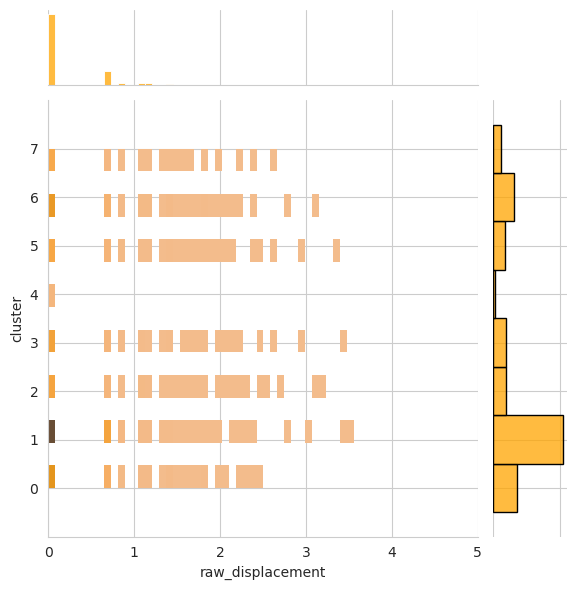

In [58]:
# Create the jointplot and save the grid object
g = sns.jointplot(data=Subset_random, x=np.log1p(Subset_random["raw_displacement"]), y="cluster", kind="hist", color="orange")

# Find min and max cluster values for proper range setting
cluster_min = Subset_random["cluster"].min()
cluster_max = Subset_random["cluster"].max()

# Clear and recreate the y-marginal histogram with precise bins
g.ax_marg_y.clear()
clusters = sorted(Subset_random["cluster"].unique())
bins = np.arange(min(clusters)-0.5, max(clusters)+1.5, 1)

# Use sns.histplot for better styling
sns.histplot(y=Subset_random["cluster"], bins=bins, ax=g.ax_marg_y,
             kde=False, edgecolor='black', linewidth=1, color="orange")

# Set the y-axis limits on main plot
g.ax_joint.set_ylim(cluster_min-1, cluster_max+1)

# Set the x-axis limits on main plot

g.ax_joint.set_xlim(0, 5)

# Set the y-ticks on main plot
g.ax_joint.set_yticks(range(cluster_min, cluster_max+1))
g.ax_joint.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}"))

# Completely disable ticks on the marginal plot
g.ax_marg_y.tick_params(axis='both', which='both', length=0, width=0, 
                        labelleft=False, left=False, 
                        labelbottom=False, bottom=False)

# Remove the spines for a cleaner look on the marginal plot
for spine in g.ax_marg_y.spines.values():
    spine.set_visible(False)

# Remove axis labels from the marginal plot
g.ax_marg_y.set_xlabel('')
g.ax_marg_y.set_ylabel('')

# Do the same for the top histogram
g.ax_marg_x.set_xlabel('')
g.ax_marg_x.set_ylabel('')

plt.savefig(f"{output_dir}/cluster_efficiency_jointplot_Random.png")

In [59]:
bin_metric(Umap, "start", 30)

UMAP1     UMAP2  duration  \
0      -6.622726  0.956308       300   
1      -2.230606  5.496466       300   
2      -0.917639 -0.644856       300   
3      -4.492699  6.422276       300   
4      -0.245321 -0.421481       300   
...          ...       ...       ...   
49965   0.413295 -1.512879       300   
49966   1.515192  0.043905       300   
49967  14.379137  0.139512        12   
49968   0.074706  0.162514       300   
49969  -0.527146  0.281462       300   

                                                     fly   event_type  \
0      230705_FeedingState_2_AM_Videos_Tracked_arena5...  interaction   
1      230705_FeedingState_2_AM_Videos_Tracked_arena5...  interaction   
2      230705_FeedingState_2_AM_Videos_Tracked_arena5...       random   
3      230705_FeedingState_2_AM_Videos_Tracked_arena5...  interaction   
4      230705_FeedingState_2_AM_Videos_Tracked_arena5...       random   
...                                                  ...          ...   
49965  230727_FeedingState_PM_Dark_Flip_Videos_Tracke...       random   
49966  230727_FeedingState_PM_Dark_Flip_Videos_Tracke...  interaction   
49967  230727_FeedingState_PM_Dark_Flip_Videos_Tracke...       random   
49968  230727_FeedingState_PM_Dark_Flip_Videos_Tracke...       random   
49969  230727_FeedingState_PM_Dark_Flip_Videos_Tracke...  interaction   

             start          end  start_frame  end_frame  \
0       142.034483   152.344828         4119       4418   
1        24.000000    34.310345          696        995   
2       722.965517   733.275862        20966      21265   
3       314.758621   325.068966         9128       9427   
4      3747.000000  3757.310345       108663     108962   
...            ...          ...          ...        ...   
49965  2469.379310  2479.689655        71612      71911   
49966  6396.034483  6406.344828       185485     185784   
49967  2080.896552  2081.275862        60346      60357   
49968  7282.379310  7292.689655       211189     211488   
49969  6433.655172  6443.965517       186576     186875   

       x_centre_preprocessed_fly_vel_mean  ...  Period  FeedingState  \
0                               -0.014037  ...      AM       starved   
1                               -0.346741  ...      AM       starved   
2                               -0.672787  ...      AM       starved   
3                                0.001867  ...      AM       starved   
4                                0.301309  ...      AM       starved   
...                                   ...  ...     ...           ...   
49965                           -0.242731  ...      PM       starved   
49966                            0.037456  ...      PM       starved   
49967                           -0.011585  ...      PM       starved   
49968                            0.113029  ...      PM       starved   
49969                           -0.012734  ...      PM       starved   

       Orientation  Light  Crossing  event_id  cluster  \
0              std     on      None         1        3   
1              std     on      None         0        5   
2              std     on      None         0        1   
3              std     on      None         3        5   
4              std     on      None         1        1   
...            ...    ...       ...       ...      ...   
49965      flipped    off      None       158        1   
49966      flipped    off      None       159        6   
49967      flipped    off      None       160        4   
49968      flipped    off      None       159        1   
49969      flipped    off      None       160        1   

                                               unique_id  log_displacement  \
0      230705_FeedingState_2_AM_Videos_Tracked_arena5...          0.000000   
1      230705_FeedingState_2_AM_Videos_Tracked_arena5...          1.791759   
2      230705_FeedingState_2_AM_Videos_Tracked_arena5...          0.693147   
3      230705_FeedingState_2_AM_Videos_Tracked_arena5...          1.09

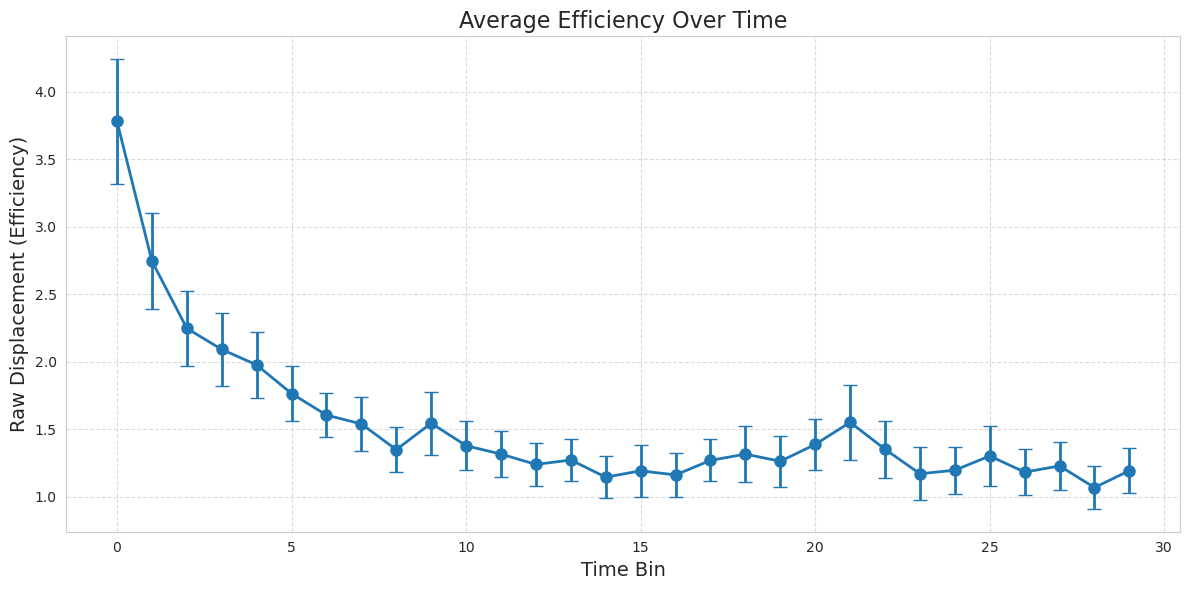

In [60]:
# Calculate average efficiency (raw_displacement) for each time bin
efficiency_over_time = Umap.groupby('binned_start')['raw_displacement'].agg(['mean', 'count', 'std']).reset_index()

# Calculate 95% confidence interval
efficiency_over_time['ci'] = 1.96 * efficiency_over_time['std'] / np.sqrt(efficiency_over_time['count'])

# Plot average efficiency over time with confidence intervals
plt.figure(figsize=(12, 6))
plt.errorbar(efficiency_over_time['binned_start'], 
             efficiency_over_time['mean'], 
             yerr=efficiency_over_time['ci'], 
             fmt='o-', 
             capsize=5, 
             linewidth=2, 
             markersize=8)

plt.title('Average Efficiency Over Time', fontsize=16)
plt.xlabel('Time Bin', fontsize=14)
plt.ylabel('Raw Displacement (Efficiency)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f"{output_dir}/average_efficiency_over_time_all.png")
plt.show()

Efficient clusters: [5, 2, 6, 0]
Inefficient clusters: [1, 3, 7, 4]


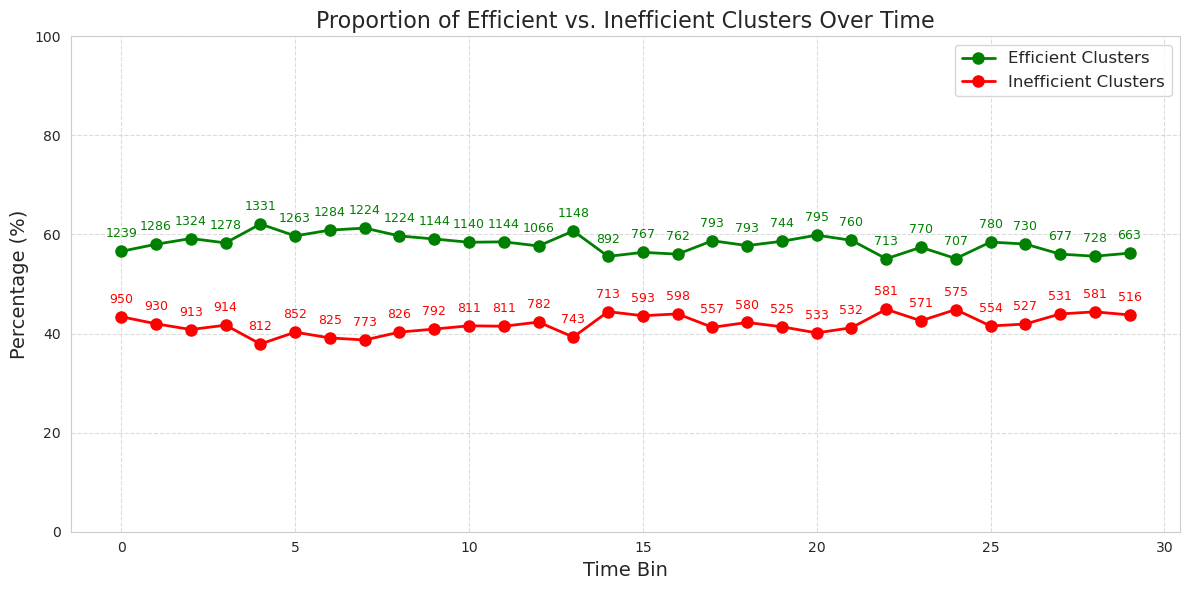

In [61]:
# Identify efficient vs. inefficient clusters (using median as cutoff)
median_efficiency = np.median(list(cluster_ranking.values()))

threshold = median_efficiency

efficient_clusters = [c for c, v in cluster_ranking.items() if v >= threshold]
inefficient_clusters = [c for c, v in cluster_ranking.items() if v < threshold]

print(f"Efficient clusters: {efficient_clusters}")
print(f"Inefficient clusters: {inefficient_clusters}")

# Calculate the proportion of efficient and inefficient clusters over time
efficiency_dist = []

for time_bin in sorted(Umap['binned_start'].unique()):
    bin_data = Umap[Umap['binned_start'] == time_bin]
    total_count = len(bin_data)
    
    if total_count > 0:
        efficient_count = len(bin_data[bin_data['cluster'].isin(efficient_clusters)])
        inefficient_count = len(bin_data[bin_data['cluster'].isin(inefficient_clusters)])
        
        efficiency_dist.append({
            'binned_start': time_bin,
            'efficient_prop': efficient_count / total_count * 100,
            'inefficient_prop': inefficient_count / total_count * 100,
            'efficient_count': efficient_count,
            'inefficient_count': inefficient_count,
            'total_count': total_count
        })

efficiency_dist_df = pd.DataFrame(efficiency_dist)

# Plot the proportion of efficient vs. inefficient clusters over time
plt.figure(figsize=(12, 6))

plt.plot(efficiency_dist_df['binned_start'], efficiency_dist_df['efficient_prop'], 
         'o-', color='green', linewidth=2, markersize=8, label='Efficient Clusters')
plt.plot(efficiency_dist_df['binned_start'], efficiency_dist_df['inefficient_prop'], 
         'o-', color='red', linewidth=2, markersize=8, label='Inefficient Clusters')

# Add counts as annotations
for i, row in efficiency_dist_df.iterrows():
    plt.annotate(f"{int(row['efficient_count'])}", 
               (row['binned_start'], row['efficient_prop']),
               textcoords="offset points", 
               xytext=(0,10), 
               ha='center',
               color='green',
               fontsize=9)
    plt.annotate(f"{int(row['inefficient_count'])}", 
               (row['binned_start'], row['inefficient_prop']),
               textcoords="offset points", 
               xytext=(0,10), 
               ha='center',
               color='red',
               fontsize=9)

plt.title('Proportion of Efficient vs. Inefficient Clusters Over Time', fontsize=16)
plt.xlabel('Time Bin', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig(f"{output_dir}/efficiency_proportion_over_time_all.png")
plt.show()


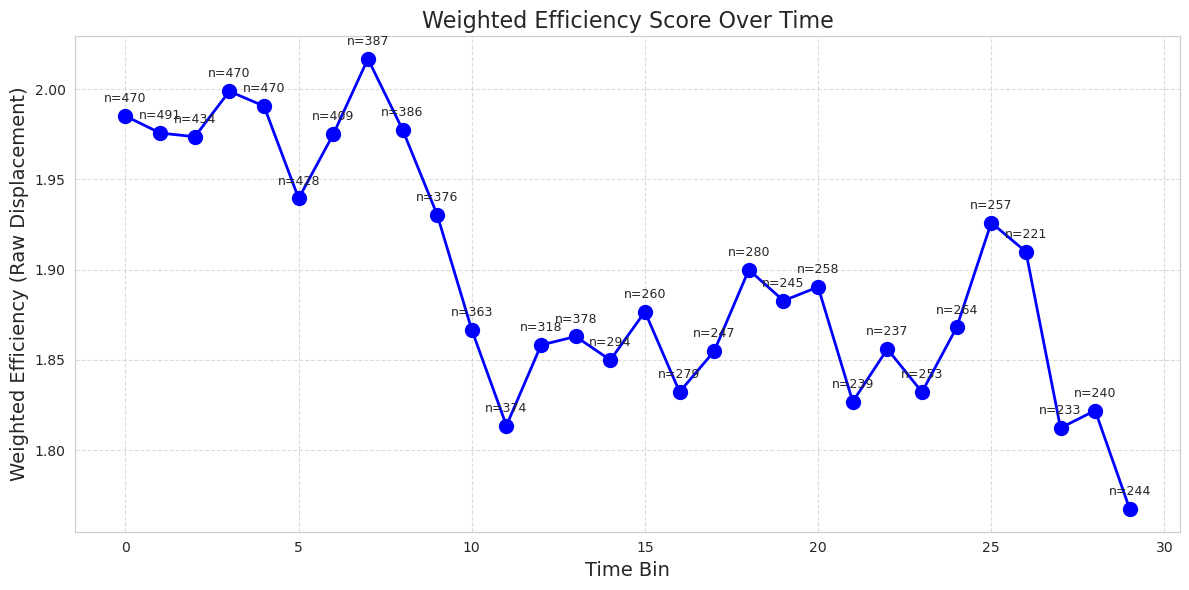

In [62]:
# Calculate weighted efficiency for each time bin
weighted_efficiency = []

for time_bin in sorted(Subset['binned_start'].unique()):
    bin_data = Subset[Subset['binned_start'] == time_bin]
    
    if len(bin_data) > 0:
        # Calculate proportion of each cluster in this time bin
        cluster_counts = bin_data['cluster'].value_counts()
        total_in_bin = cluster_counts.sum()
        
        # Calculate weighted efficiency
        weighted_eff = 0
        for cluster, count in cluster_counts.items():
            if cluster in cluster_ranking:
                cluster_eff = cluster_ranking[cluster]
                weighted_eff += (count / total_in_bin) * cluster_eff
        
        weighted_efficiency.append({
            'binned_start': time_bin,
            'weighted_efficiency': weighted_eff,
            'total_count': total_in_bin
        })

weighted_efficiency_df = pd.DataFrame(weighted_efficiency)

# Plot weighted efficiency over time
plt.figure(figsize=(12, 6))
plt.plot(weighted_efficiency_df['binned_start'], weighted_efficiency_df['weighted_efficiency'], 
         'o-', color='blue', linewidth=2, markersize=10)

# Add sample size as annotations
for i, row in weighted_efficiency_df.iterrows():
    plt.annotate(f"n={int(row['total_count'])}", 
               (row['binned_start'], row['weighted_efficiency']),
               textcoords="offset points", 
               xytext=(0,10), 
               ha='center',
               fontsize=9)

plt.title('Weighted Efficiency Score Over Time', fontsize=16)
plt.xlabel('Time Bin', fontsize=14)
plt.ylabel('Weighted Efficiency (Raw Displacement)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f"{output_dir}/weighted_efficiency_over_time.png")
plt.show()


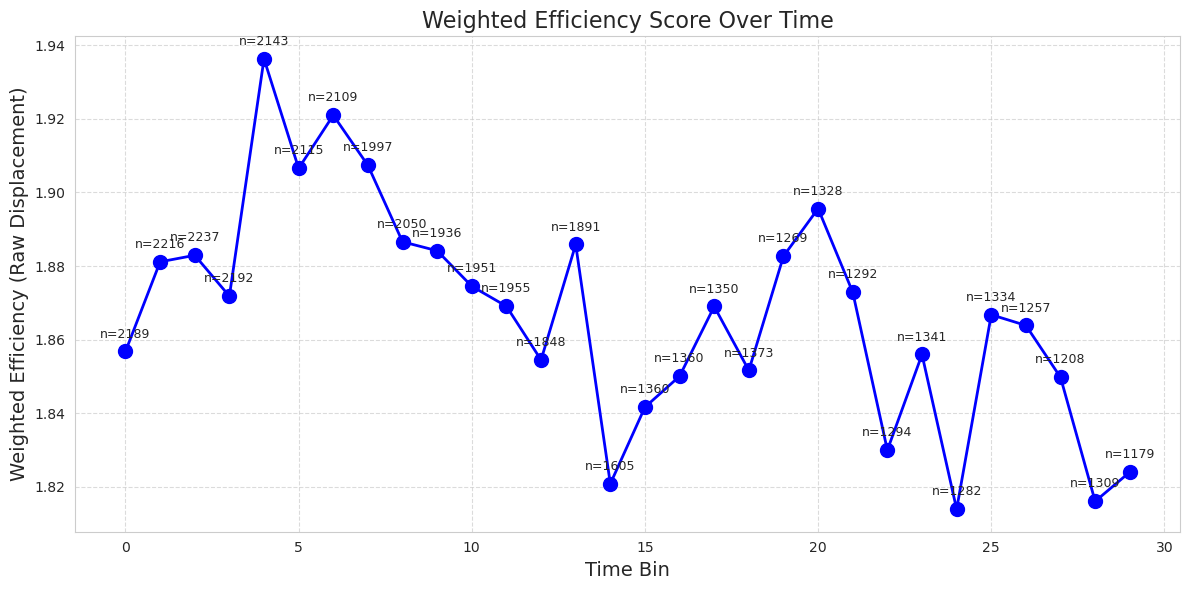

In [63]:
# Calculate weighted efficiency for each time bin
weighted_efficiency = []

for time_bin in sorted(Umap['binned_start'].unique()):
    bin_data = Umap[Umap['binned_start'] == time_bin]
    
    if len(bin_data) > 0:
        # Calculate proportion of each cluster in this time bin
        cluster_counts = bin_data['cluster'].value_counts()
        total_in_bin = cluster_counts.sum()
        
        # Calculate weighted efficiency
        weighted_eff = 0
        for cluster, count in cluster_counts.items():
            if cluster in cluster_ranking:
                cluster_eff = cluster_ranking[cluster]
                weighted_eff += (count / total_in_bin) * cluster_eff
        
        weighted_efficiency.append({
            'binned_start': time_bin,
            'weighted_efficiency': weighted_eff,
            'total_count': total_in_bin
        })

weighted_efficiency_df = pd.DataFrame(weighted_efficiency)

# Plot weighted efficiency over time
plt.figure(figsize=(12, 6))
plt.plot(weighted_efficiency_df['binned_start'], weighted_efficiency_df['weighted_efficiency'], 
         'o-', color='blue', linewidth=2, markersize=10)

# Add sample size as annotations
for i, row in weighted_efficiency_df.iterrows():
    plt.annotate(f"n={int(row['total_count'])}", 
               (row['binned_start'], row['weighted_efficiency']),
               textcoords="offset points", 
               xytext=(0,10), 
               ha='center',
               fontsize=9)

plt.title('Weighted Efficiency Score Over Time', fontsize=16)
plt.xlabel('Time Bin', fontsize=14)
plt.ylabel('Weighted Efficiency (Raw Displacement)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f"{output_dir}/weighted_efficiency_over_time_all.png")
plt.show()

# By event_index

In [64]:
bin_metric(Subset, "event_id", 10)

UMAP1     UMAP2  duration  \
438    0.565710 -1.273178       300   
439   -4.622505  6.439818       300   
440    1.349943 -1.439613       300   
441    3.407645  9.195754       300   
442   -5.211839  1.224313       300   
...         ...       ...       ...   
49525 -0.744041 -1.045398       300   
49526 -6.480713  2.545859       300   
49527 -2.451590 -1.517644       300   
49528 -5.996283  0.511616       300   
49529  5.249425  3.050026       300   

                                                     fly   event_type  \
438    230704_FeedingState_1_PM_Videos_Tracked_arena3...       random   
439    230704_FeedingState_1_PM_Videos_Tracked_arena3...  interaction   
440    230704_FeedingState_1_PM_Videos_Tracked_arena3...       random   
441    230704_FeedingState_1_PM_Videos_Tracked_arena3...  interaction   
442    230704_FeedingState_1_PM_Videos_Tracked_arena3...       random   
...                                                  ...          ...   
49525  230705_FeedingState_2_PM_Videos_Tracked_arena1...       random   
49526  230705_FeedingState_2_PM_Videos_Tracked_arena1...  interaction   
49527  230705_FeedingState_2_PM_Videos_Tracked_arena1...       random   
49528  230705_FeedingState_2_PM_Videos_Tracked_arena1...  interaction   
49529  230705_FeedingState_2_PM_Videos_Tracked_arena1...       random   

             start          end  start_frame  end_frame  \
438    4683.172414  4693.482759       135812     136111   
439     668.793103   679.103448        19395      19694   
440     425.275862   435.586207        12333      12632   
441     453.827586   464.137931        13161      13460   
442    2260.275862  2270.586207        65548      65847   
...            ...          ...          ...        ...   
49525  1758.379310  1768.689655        50993      51292   
49526  7258.517241  7268.827586       210497     210796   
49527  6818.931034  6829.241379       197749     198048   
49528  7313.517241  7323.827586       212092     212391   
49529   282.172414   292.482759         8183       8482   

       x_centre_preprocessed_fly_vel_mean  ...  Period     FeedingState  \
438                             -0.042959  ...      PM  starved_noWater   
439                             -0.092989  ...      PM  starved_noWater   
440                              0.086275  ...      PM  starved_noWater   
441                              0.475864  ...      PM  starved_noWater   
442                              0.422351  ...      PM  starved_noWater   
...                                   ...  ...     ...              ...   
49525                            0.505289  ...      PM  starved_noWater   
49526                            0.367943  ...      PM  starved_noWater   
49527                           -0.003069  ...      PM  starved_noWater   
49528                           -0.153039  ...      PM  starved_noWater   
49529                            0.180652  ...      PM  starved_noWater   

       Orientation  Light  Crossing  event_id  cluster  \
438            std     on      None         3        1   
439            std     on      None         3        5   
440            std     on      None         1        1   
441            std     on      None         2        2   
442            std     on      None         2        3   
...            ...    ...       ...       ...      ...   
49525          std     on      None        32        1   
49526          std     on      None        33        3   
49527          std     on      None        33        1   
49528          std     on      None        34        3   
49529          std     on      None        34        6   

                                               unique_id  binned_start  \
438    230704_FeedingState_1_PM_Videos_Tracked_arena3...            18   
439    230704_FeedingState_1_PM_Videos_Tracked_arena3...             2   
440    230704_FeedingState_1_PM_Videos_Tracked_arena3...             1   
441    230704_FeedingState_1_PM_Videos_Tracked_arena3...     

In [65]:
Subset_FirstContacts = Subset[Subset["event_id"] < 10]

In [66]:
Umap_FirstContacts = Umap[Umap["event_id"] < 10]

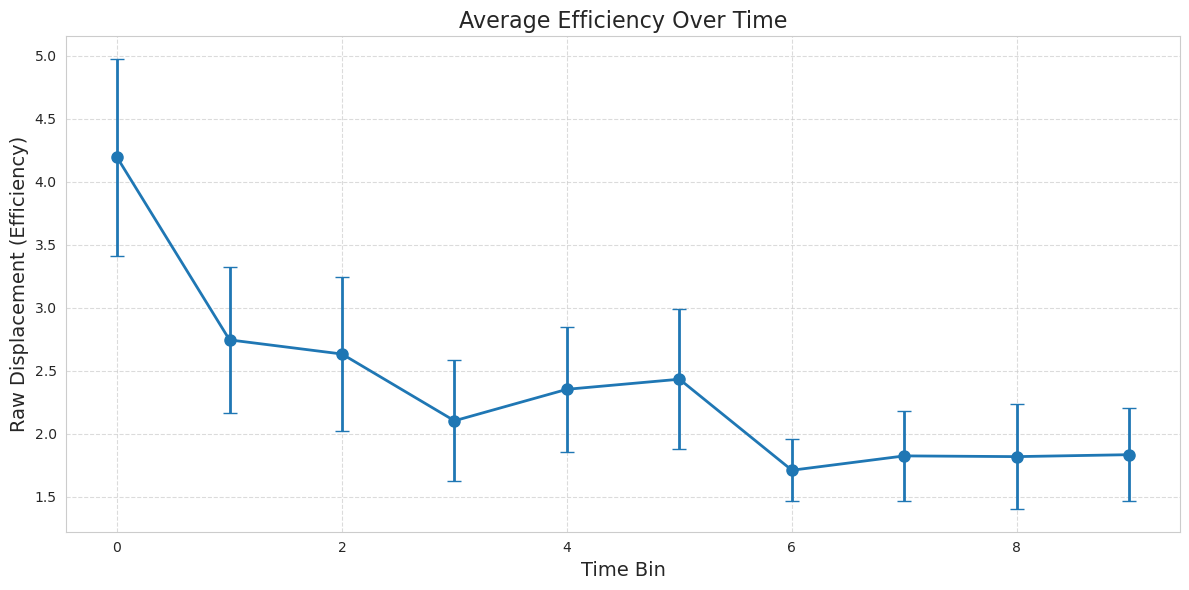

In [67]:
# Calculate average efficiency (raw_displacement) for each time bin
efficiency_over_time = Umap_FirstContacts.groupby('event_id')['raw_displacement'].agg(['mean', 'count', 'std']).reset_index()

# Calculate 95% confidence interval
efficiency_over_time['ci'] = 1.96 * efficiency_over_time['std'] / np.sqrt(efficiency_over_time['count'])

# Plot average efficiency over time with confidence intervals
plt.figure(figsize=(12, 6))
plt.errorbar(efficiency_over_time['event_id'], 
             efficiency_over_time['mean'], 
             yerr=efficiency_over_time['ci'], 
             fmt='o-', 
             capsize=5, 
             linewidth=2, 
             markersize=8)

plt.title('Average Efficiency Over Time', fontsize=16)
plt.xlabel('Time Bin', fontsize=14)
plt.ylabel('Raw Displacement (Efficiency)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f"{output_dir}/average_efficiency_over_events.png")
plt.show()

Efficient clusters: [5, 2, 6, 0]
Inefficient clusters: [1, 3, 7, 4]


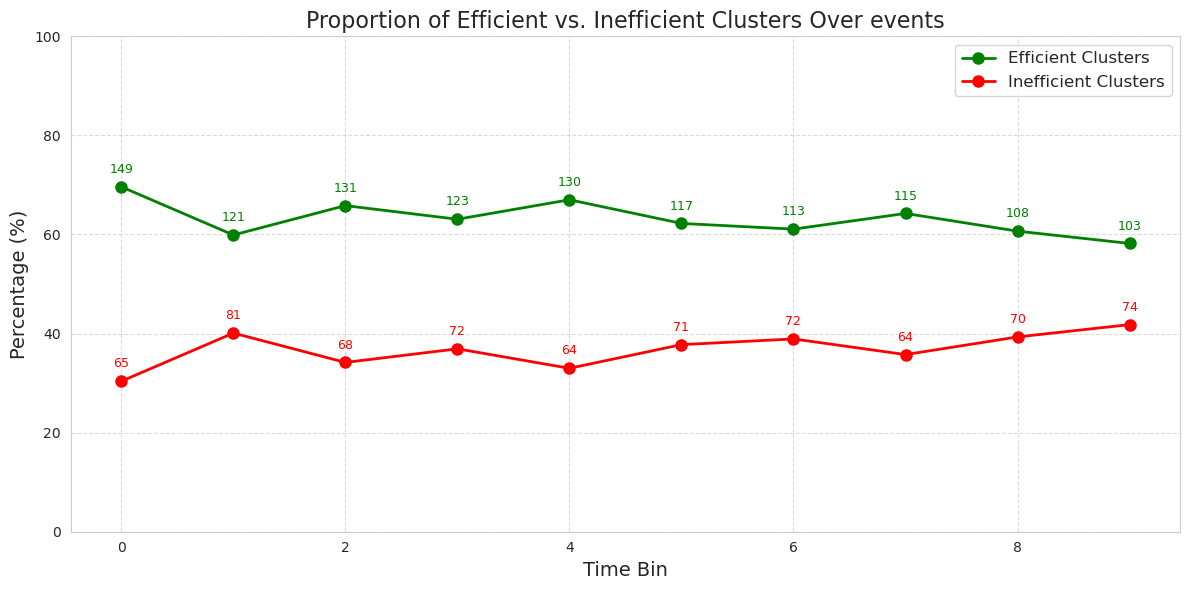

In [68]:
# Identify efficient vs. inefficient clusters (using median as cutoff)
median_efficiency = np.median(list(cluster_ranking.values()))

threshold = median_efficiency

efficient_clusters = [c for c, v in cluster_ranking.items() if v >= threshold]
inefficient_clusters = [c for c, v in cluster_ranking.items() if v < threshold]

print(f"Efficient clusters: {efficient_clusters}")
print(f"Inefficient clusters: {inefficient_clusters}")

# Calculate the proportion of efficient and inefficient clusters over time
efficiency_dist = []

for time_bin in sorted(Subset_FirstContacts['event_id'].unique()):
    bin_data = Subset_FirstContacts[Subset_FirstContacts['event_id'] == time_bin]
    total_count = len(bin_data)
    
    if total_count > 0:
        efficient_count = len(bin_data[bin_data['cluster'].isin(efficient_clusters)])
        inefficient_count = len(bin_data[bin_data['cluster'].isin(inefficient_clusters)])
        
        efficiency_dist.append({
            'event_id': time_bin,
            'efficient_prop': efficient_count / total_count * 100,
            'inefficient_prop': inefficient_count / total_count * 100,
            'efficient_count': efficient_count,
            'inefficient_count': inefficient_count,
            'total_count': total_count
        })

efficiency_dist_df = pd.DataFrame(efficiency_dist)

# Plot the proportion of efficient vs. inefficient clusters over time
plt.figure(figsize=(12, 6))

plt.plot(efficiency_dist_df['event_id'], efficiency_dist_df['efficient_prop'], 
         'o-', color='green', linewidth=2, markersize=8, label='Efficient Clusters')
plt.plot(efficiency_dist_df['event_id'], efficiency_dist_df['inefficient_prop'], 
         'o-', color='red', linewidth=2, markersize=8, label='Inefficient Clusters')

# Add counts as annotations
for i, row in efficiency_dist_df.iterrows():
    plt.annotate(f"{int(row['efficient_count'])}", 
               (row['event_id'], row['efficient_prop']),
               textcoords="offset points", 
               xytext=(0,10), 
               ha='center',
               color='green',
               fontsize=9)
    plt.annotate(f"{int(row['inefficient_count'])}", 
               (row['event_id'], row['inefficient_prop']),
               textcoords="offset points", 
               xytext=(0,10), 
               ha='center',
               color='red',
               fontsize=9)

plt.title('Proportion of Efficient vs. Inefficient Clusters Over events', fontsize=16)
plt.xlabel('Time Bin', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig(f"{output_dir}/efficiency_proportion_over_events.png")
plt.show()

Efficient clusters: [5, 2, 6, 0]
Inefficient clusters: [1, 3, 7, 4]


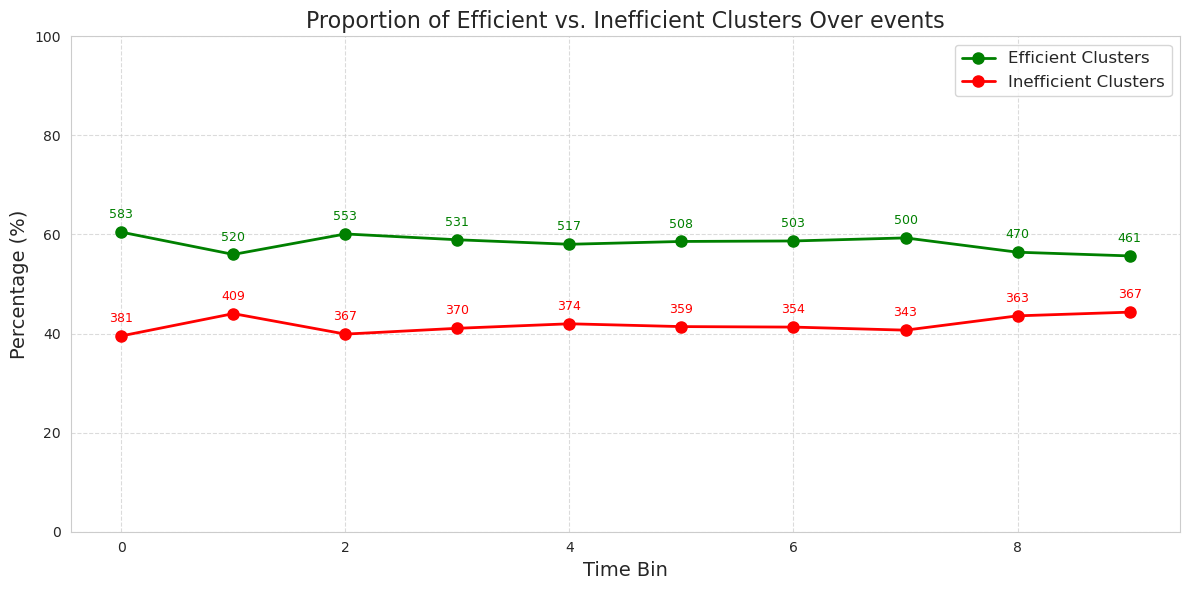

In [69]:
# Identify efficient vs. inefficient clusters (using median as cutoff)
median_efficiency = np.median(list(cluster_ranking.values()))

threshold = median_efficiency

efficient_clusters = [c for c, v in cluster_ranking.items() if v >= threshold]
inefficient_clusters = [c for c, v in cluster_ranking.items() if v < threshold]

print(f"Efficient clusters: {efficient_clusters}")
print(f"Inefficient clusters: {inefficient_clusters}")

# Calculate the proportion of efficient and inefficient clusters over time
efficiency_dist = []

for time_bin in sorted(Umap_FirstContacts['event_id'].unique()):
    bin_data = Umap_FirstContacts[Umap_FirstContacts['event_id'] == time_bin]
    total_count = len(bin_data)
    
    if total_count > 0:
        efficient_count = len(bin_data[bin_data['cluster'].isin(efficient_clusters)])
        inefficient_count = len(bin_data[bin_data['cluster'].isin(inefficient_clusters)])
        
        efficiency_dist.append({
            'event_id': time_bin,
            'efficient_prop': efficient_count / total_count * 100,
            'inefficient_prop': inefficient_count / total_count * 100,
            'efficient_count': efficient_count,
            'inefficient_count': inefficient_count,
            'total_count': total_count
        })

efficiency_dist_df = pd.DataFrame(efficiency_dist)

# Plot the proportion of efficient vs. inefficient clusters over time
plt.figure(figsize=(12, 6))

plt.plot(efficiency_dist_df['event_id'], efficiency_dist_df['efficient_prop'], 
         'o-', color='green', linewidth=2, markersize=8, label='Efficient Clusters')
plt.plot(efficiency_dist_df['event_id'], efficiency_dist_df['inefficient_prop'], 
         'o-', color='red', linewidth=2, markersize=8, label='Inefficient Clusters')

# Add counts as annotations
for i, row in efficiency_dist_df.iterrows():
    plt.annotate(f"{int(row['efficient_count'])}", 
               (row['event_id'], row['efficient_prop']),
               textcoords="offset points", 
               xytext=(0,10), 
               ha='center',
               color='green',
               fontsize=9)
    plt.annotate(f"{int(row['inefficient_count'])}", 
               (row['event_id'], row['inefficient_prop']),
               textcoords="offset points", 
               xytext=(0,10), 
               ha='center',
               color='red',
               fontsize=9)

plt.title('Proportion of Efficient vs. Inefficient Clusters Over events', fontsize=16)
plt.xlabel('Time Bin', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig(f"{output_dir}/efficiency_proportion_over_events_all.png")
plt.show()

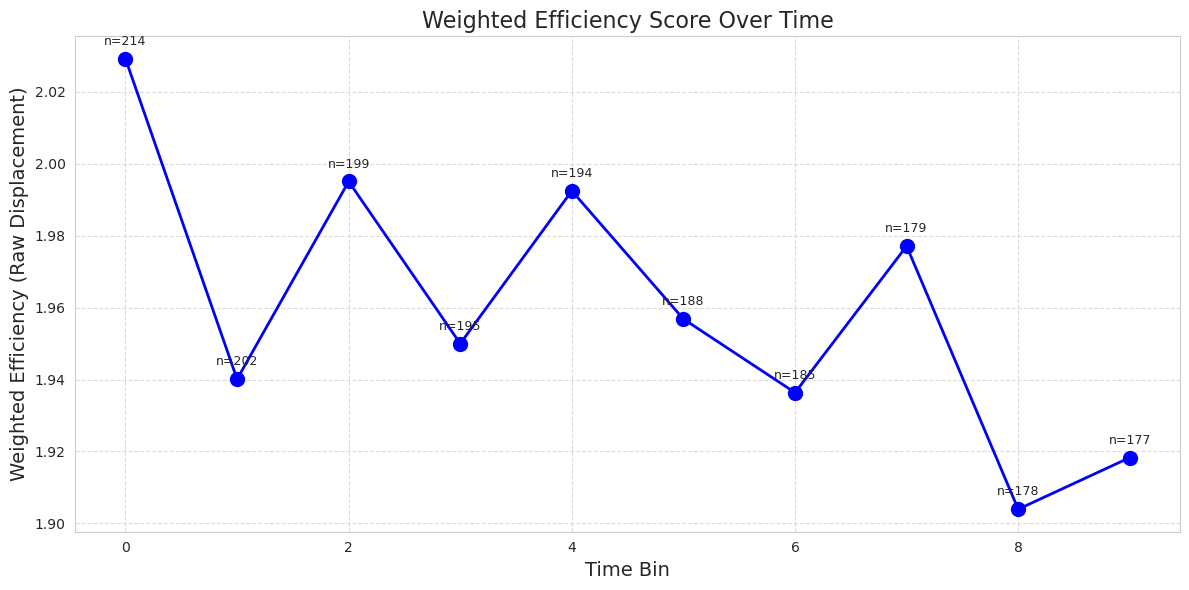

In [70]:
# Calculate weighted efficiency for each time bin
weighted_efficiency = []

for time_bin in sorted(Subset_FirstContacts['event_id'].unique()):
    bin_data = Subset_FirstContacts[Subset_FirstContacts['event_id'] == time_bin]
    
    if len(bin_data) > 0:
        # Calculate proportion of each cluster in this time bin
        cluster_counts = bin_data['cluster'].value_counts()
        total_in_bin = cluster_counts.sum()
        
        # Calculate weighted efficiency
        weighted_eff = 0
        for cluster, count in cluster_counts.items():
            if cluster in cluster_ranking:
                cluster_eff = cluster_ranking[cluster]
                weighted_eff += (count / total_in_bin) * cluster_eff
        
        weighted_efficiency.append({
            'event_id': time_bin,
            'weighted_efficiency': weighted_eff,
            'total_count': total_in_bin
        })

weighted_efficiency_df = pd.DataFrame(weighted_efficiency)

# Plot weighted efficiency over time
plt.figure(figsize=(12, 6))
plt.plot(weighted_efficiency_df['event_id'], weighted_efficiency_df['weighted_efficiency'], 
         'o-', color='blue', linewidth=2, markersize=10)

# Add sample size as annotations
for i, row in weighted_efficiency_df.iterrows():
    plt.annotate(f"n={int(row['total_count'])}", 
               (row['event_id'], row['weighted_efficiency']),
               textcoords="offset points", 
               xytext=(0,10), 
               ha='center',
               fontsize=9)

plt.title('Weighted Efficiency Score Over Time', fontsize=16)
plt.xlabel('Time Bin', fontsize=14)
plt.ylabel('Weighted Efficiency (Raw Displacement)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f"{output_dir}/weighted_efficiency_over_events.png")
plt.show()

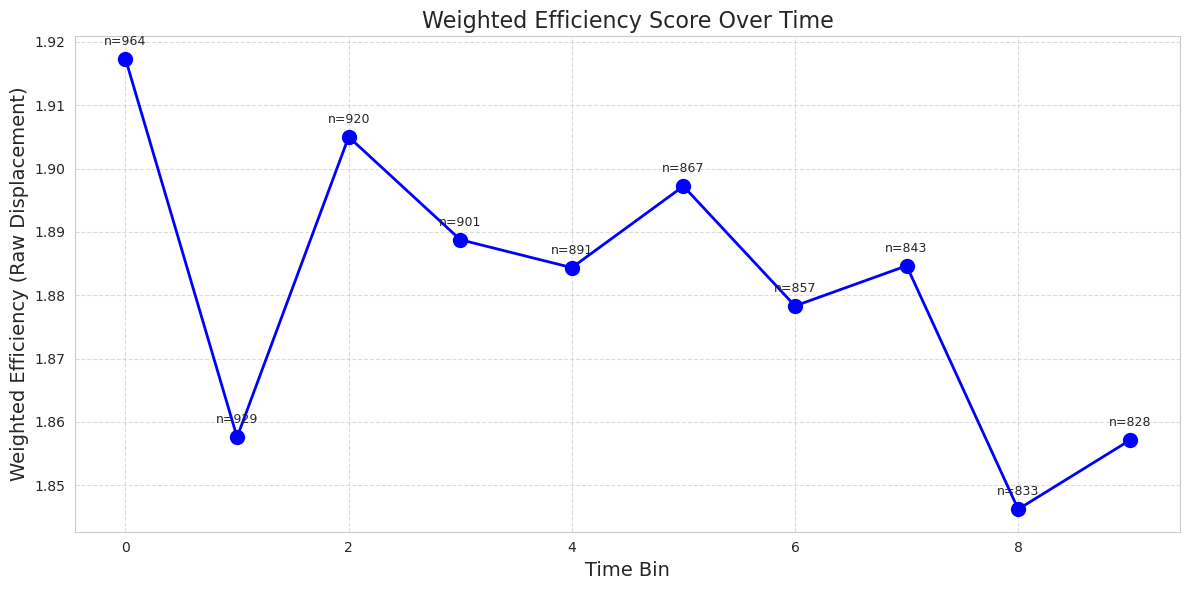

In [71]:
# Calculate weighted efficiency for each time bin
weighted_efficiency = []

for time_bin in sorted(Umap_FirstContacts['event_id'].unique()):
    bin_data = Umap_FirstContacts[Umap_FirstContacts['event_id'] == time_bin]
    
    if len(bin_data) > 0:
        # Calculate proportion of each cluster in this time bin
        cluster_counts = bin_data['cluster'].value_counts()
        total_in_bin = cluster_counts.sum()
        
        # Calculate weighted efficiency
        weighted_eff = 0
        for cluster, count in cluster_counts.items():
            if cluster in cluster_ranking:
                cluster_eff = cluster_ranking[cluster]
                weighted_eff += (count / total_in_bin) * cluster_eff
        
        weighted_efficiency.append({
            'event_id': time_bin,
            'weighted_efficiency': weighted_eff,
            'total_count': total_in_bin
        })

weighted_efficiency_df = pd.DataFrame(weighted_efficiency)

# Plot weighted efficiency over time
plt.figure(figsize=(12, 6))
plt.plot(weighted_efficiency_df['event_id'], weighted_efficiency_df['weighted_efficiency'], 
         'o-', color='blue', linewidth=2, markersize=10)

# Add sample size as annotations
for i, row in weighted_efficiency_df.iterrows():
    plt.annotate(f"n={int(row['total_count'])}", 
               (row['event_id'], row['weighted_efficiency']),
               textcoords="offset points", 
               xytext=(0,10), 
               ha='center',
               fontsize=9)

plt.title('Weighted Efficiency Score Over Time', fontsize=16)
plt.xlabel('Time Bin', fontsize=14)
plt.ylabel('Weighted Efficiency (Raw Displacement)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f"{output_dir}/weighted_efficiency_over_events_all.png")
plt.show()

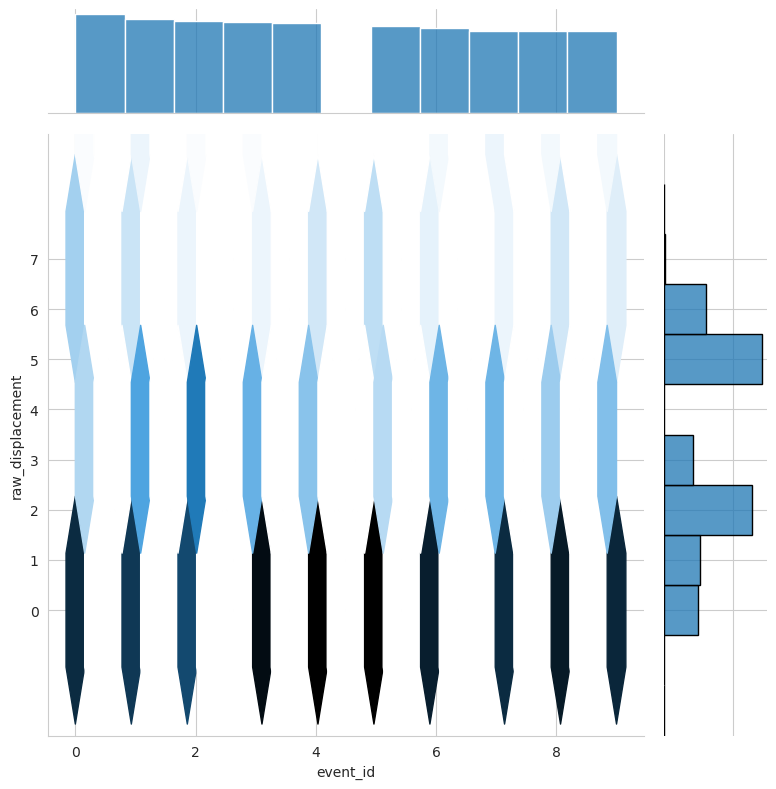

In [72]:
Subset_Subset_FirstContacts_interaction = Subset_FirstContacts[Subset_FirstContacts["event_type"] == "interaction"]


# Create the jointplot and save the grid object
g = sns.jointplot(data=Subset_Subset_FirstContacts_interaction, x="event_id", y="raw_displacement", kind="hex", height=8)

# Find min and max cluster values for proper range setting
cluster_min = Subset_Subset_FirstContacts_interaction["cluster"].min()
cluster_max = Subset_Subset_FirstContacts_interaction["cluster"].max()

# Clear and recreate the y-marginal histogram with precise bins
g.ax_marg_y.clear()
clusters = sorted(Subset_Subset_FirstContacts_interaction["cluster"].unique())

bins = np.arange(cluster_min-2.5, cluster_max+2.5, 1)  # This creates exact bin edges

# Use sns.histplot for better styling
sns.histplot(y=Subset_Subset_FirstContacts_interaction["cluster"], bins=bins, ax=g.ax_marg_y,
             kde=False, edgecolor='black', linewidth=1)

g.ax_joint.set_ylim(cluster_min-2.5, cluster_max+2.5)

# Set the y-ticks on main plot
g.ax_joint.set_yticks(range(cluster_min, cluster_max+1))
g.ax_joint.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}"))

# Completely disable ticks on the marginal plot
g.ax_marg_y.tick_params(axis='both', which='both', length=0, width=0, 
                        labelleft=False, left=False, 
                        labelbottom=False, bottom=False)

# Remove the spines for a cleaner look on the marginal plot
for spine in g.ax_marg_y.spines.values():
    spine.set_visible(False)

# Remove axis labels from the marginal plot
g.ax_marg_y.set_xlabel('')
g.ax_marg_y.set_ylabel('')

# Do the same for the top histogram
g.ax_marg_x.set_xlabel('')
g.ax_marg_x.set_ylabel('')

plt.savefig(f"{output_dir}/cluster_evolution_event_id_jointplot_Interaction.png")

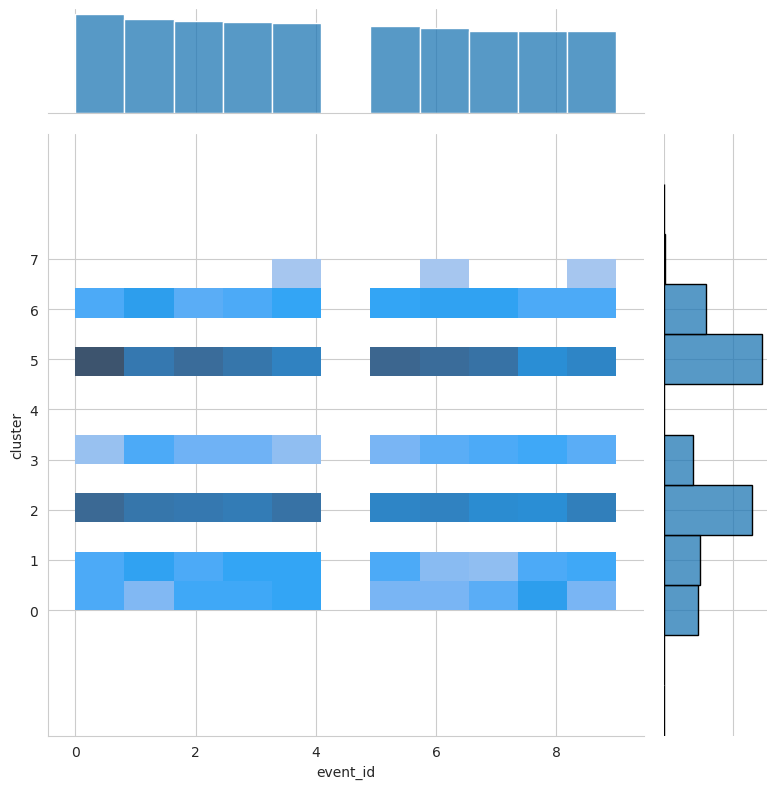

In [73]:
# Create the jointplot and save the grid object
g = sns.jointplot(data=Subset_Subset_FirstContacts_interaction, x="event_id", y="cluster", kind="hist", height=8)

# Find min and max cluster values for proper range setting
cluster_min = Subset_Subset_FirstContacts_interaction["cluster"].min()
cluster_max = Subset_Subset_FirstContacts_interaction["cluster"].max()

# Clear and recreate the y-marginal histogram with precise bins
g.ax_marg_y.clear()
clusters = sorted(Subset_Subset_FirstContacts_interaction["cluster"].unique())

bins = np.arange(cluster_min-2.5, cluster_max+2.5, 1)  # This creates exact bin edges

# Use sns.histplot for better styling
sns.histplot(y=Subset_Subset_FirstContacts_interaction["cluster"], bins=bins, ax=g.ax_marg_y,
             kde=False, edgecolor='black', linewidth=1)

g.ax_joint.set_ylim(cluster_min-2.5, cluster_max+2.5)

# Set the y-ticks on main plot
g.ax_joint.set_yticks(range(cluster_min, cluster_max+1))
g.ax_joint.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}"))

# Completely disable ticks on the marginal plot
g.ax_marg_y.tick_params(axis='both', which='both', length=0, width=0, 
                        labelleft=False, left=False, 
                        labelbottom=False, bottom=False)

# Remove the spines for a cleaner look on the marginal plot
for spine in g.ax_marg_y.spines.values():
    spine.set_visible(False)

# Remove axis labels from the marginal plot
g.ax_marg_y.set_xlabel('')
g.ax_marg_y.set_ylabel('')

# Do the same for the top histogram
g.ax_marg_x.set_xlabel('')
g.ax_marg_x.set_ylabel('')

plt.savefig(f"{output_dir}/cluster_evolution_jointplot_Interaction_eventid.png")

Text(0.5, 0.98, 'Distribution of Clusters Across Event IDs by Event Type')

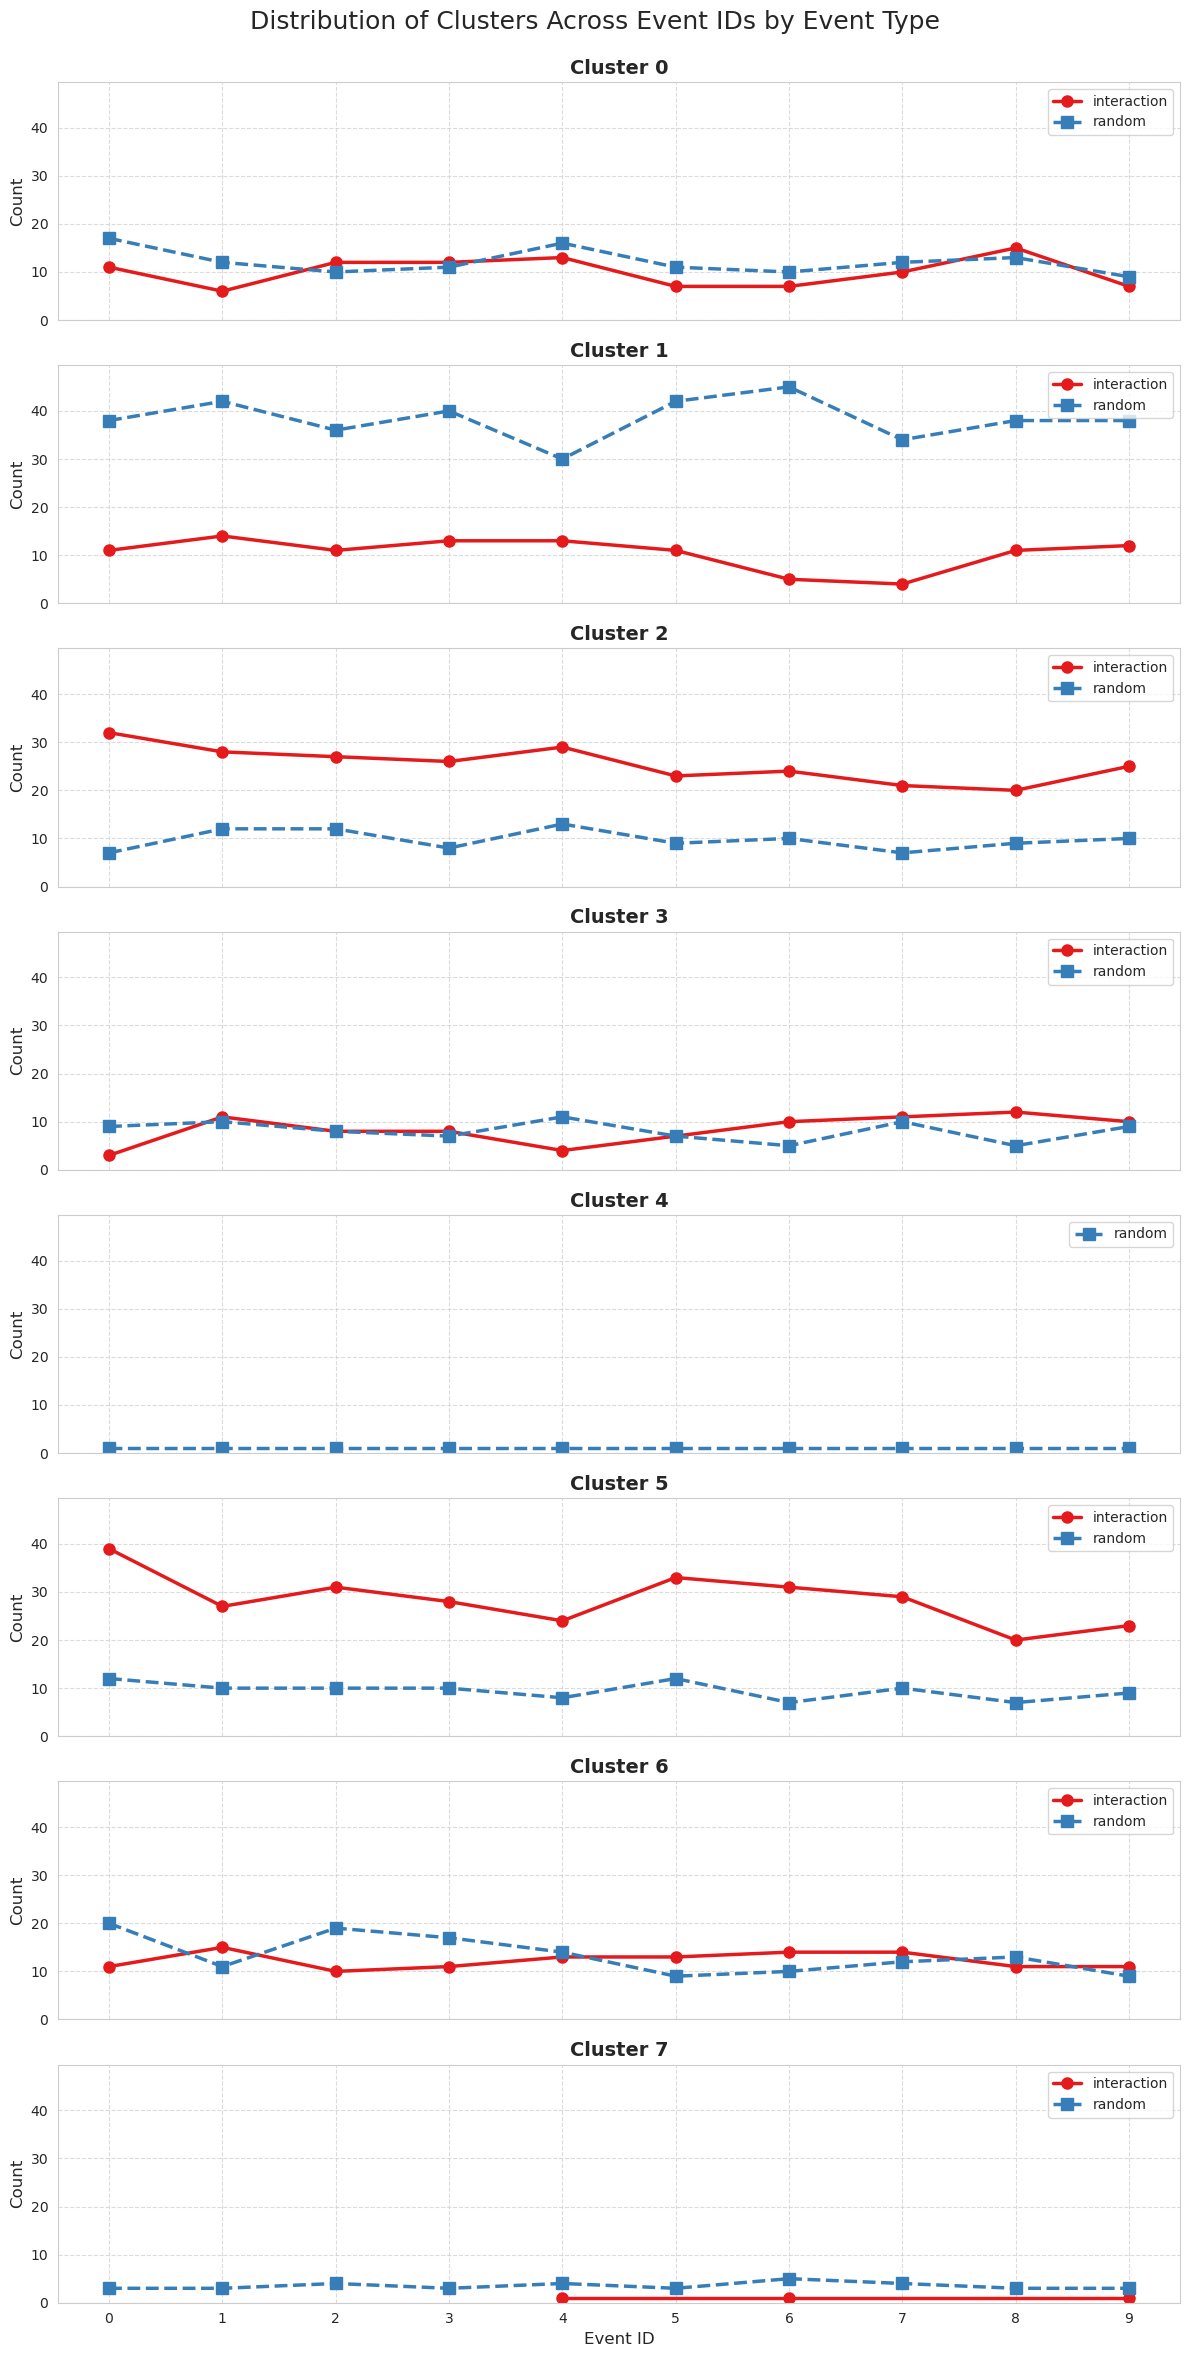

In [74]:
# Get all unique values from your dataset
clusters = sorted(Subset_FirstContacts['cluster'].unique())
event_types = sorted(Subset_FirstContacts['event_type'].unique())

# Count occurrences for each cluster, event_type, event_id combination
counts = Subset_FirstContacts.groupby(['cluster', 'event_type', 'event_id']).size().reset_index(name='count')

# Find global maximum count for consistent y-axis scaling
max_count = counts['count'].max()

# Create a color palette for event types
colors = sns.color_palette("Set1", len(event_types))
event_type_colors = dict(zip(event_types, colors))

# Additional styling options for better differentiation
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D', '*', 'p', 'h']

# Ensure we have enough styles 
if len(event_types) > len(line_styles):
    line_styles = line_styles * (len(event_types) // len(line_styles) + 1)
if len(event_types) > len(markers):
    markers = markers * (len(event_types) // len(markers) + 1)

# Create mappings
event_type_styles = dict(zip(event_types, line_styles[:len(event_types)]))
event_type_markers = dict(zip(event_types, markers[:len(event_types)]))

# Create the figure and axes grid - one subplot per cluster
fig, axes = plt.subplots(len(clusters), 1, 
                       figsize=(12, 3 * len(clusters)),
                       sharex=True, sharey=True)  # Share both axes

# Ensure axes is always an array
if len(clusters) == 1:
    axes = np.array([axes])

# Get all unique event_ids across all event types
all_event_ids = sorted(Subset_FirstContacts['event_id'].unique())

# Plot each cluster
for i, cluster in enumerate(clusters):
    ax = axes[i]
    
    # Loop through each event type and plot on the same axes with different colors and styles
    for j, event_type in enumerate(event_types):
        # Get data for this cluster and event type
        facet_data = counts[(counts['cluster'] == cluster) & 
                         (counts['event_type'] == event_type)]
        
        # Sort by event_id for proper plotting
        facet_data = facet_data.sort_values('event_id')
        
        # Plot if there's data
        if len(facet_data) > 0:
            # Use line plot with markers to show evolution
            ax.plot(facet_data['event_id'], facet_data['count'], 
                   marker=event_type_markers[event_type], markersize=8, 
                   linestyle=event_type_styles[event_type], linewidth=2.5, 
                   color=event_type_colors[event_type],
                   label=f"{event_type}")
    
    # Set labels and title for subplot
    ax.set_title(f"Cluster {cluster}", fontsize=14, fontweight='bold')
    ax.set_ylabel("Count", fontsize=12)
    if i == len(clusters) - 1:
        ax.set_xlabel("Event ID", fontsize=12)
        
    # Add grid for readability
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Set y-axis limits to be the same for all subplots
    ax.set_ylim(0, max(1, max_count * 1.1))  # Add 10% padding
    
    # Set x-axis to include all event IDs
    ax.set_xticks(all_event_ids)
    
    # Add legend to each subplot
    ax.legend(loc='upper right')

# Adjust layout
plt.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle('Distribution of Clusters Across Event IDs by Event Type', fontsize=18)



Text(0.5, 0.98, 'Proportion of Clusters by Event ID and Type (% of total events)')

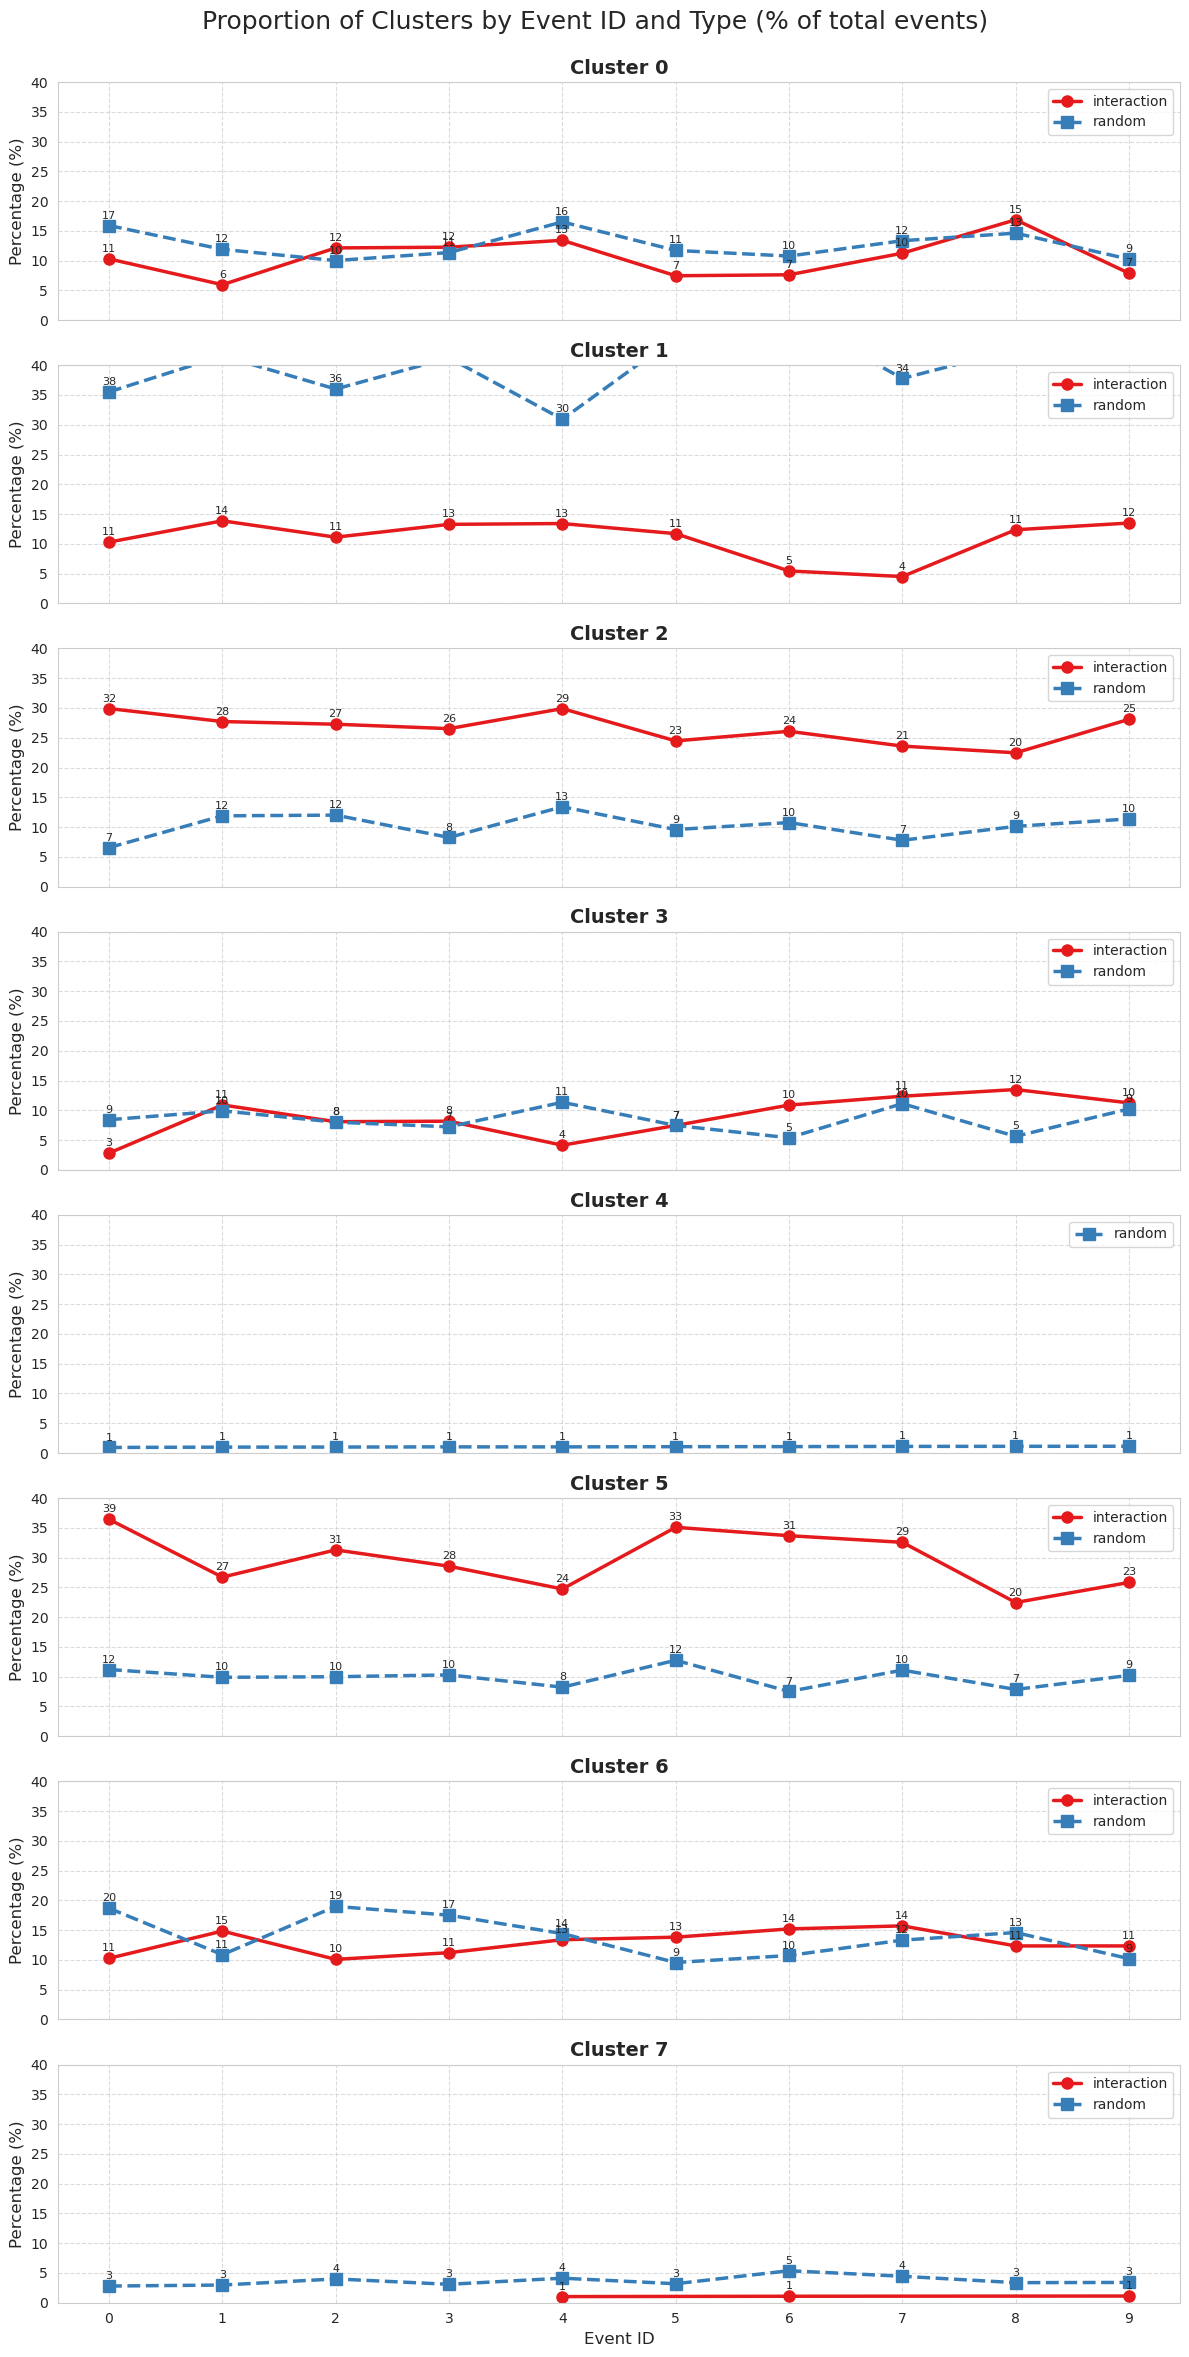

In [77]:
# Get all unique values from your dataset
clusters = sorted(Subset_FirstContacts['cluster'].unique())
event_types = sorted(Subset_FirstContacts['event_type'].unique())

# Count occurrences for each cluster, event_type, event_id combination
counts = Subset_FirstContacts.groupby(['cluster', 'event_type', 'event_id']).size().reset_index(name='count')

# Calculate total events for each event_id and event_type combination
totals = Subset_FirstContacts.groupby(['event_type', 'event_id']).size().reset_index(name='total')

# Merge totals with counts to calculate proportions
counts = counts.merge(totals, on=['event_type', 'event_id'], how='left')
counts['proportion'] = counts['count'] / counts['total'] * 100  # Convert to percentage

# Verify our calculations are correct - for each event_type and event_id, the sum of proportions should be 100%
verification = counts.groupby(['event_type', 'event_id'])['proportion'].sum().reset_index()
# Should be very close to 100 for each group (may have small floating point differences)

# Create a color palette for event types
colors = sns.color_palette("Set1", len(event_types))
event_type_colors = dict(zip(event_types, colors))

# Additional styling options for better differentiation
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D', '*', 'p', 'h']

# Ensure we have enough styles 
if len(event_types) > len(line_styles):
    line_styles = line_styles * (len(event_types) // len(line_styles) + 1)
if len(event_types) > len(markers):
    markers = markers * (len(event_types) // len(markers) + 1)

# Create mappings
event_type_styles = dict(zip(event_types, line_styles[:len(event_types)]))
event_type_markers = dict(zip(event_types, markers[:len(event_types)]))

# Create the figure and axes grid - one subplot per cluster
fig, axes = plt.subplots(len(clusters), 1, 
                       figsize=(12, 3 * len(clusters)),
                       sharex=True, sharey=True)  # Share both axes

# Ensure axes is always an array
if len(clusters) == 1:
    axes = np.array([axes])

# Get all unique event_ids across all event types
all_event_ids = sorted(Subset_FirstContacts['event_id'].unique())

# Plot each cluster
for i, cluster in enumerate(clusters):
    ax = axes[i]
    
    # Loop through each event type and plot on the same axes with different colors and styles
    for j, event_type in enumerate(event_types):
        # Get data for this cluster and event type
        facet_data = counts[(counts['cluster'] == cluster) & 
                         (counts['event_type'] == event_type)]
        
        # Sort by event_id for proper plotting
        facet_data = facet_data.sort_values('event_id')
        
        # Plot if there's data
        if len(facet_data) > 0:
            # Use line plot with markers to show evolution, using the proportion
            ax.plot(facet_data['event_id'], facet_data['proportion'], 
                   marker=event_type_markers[event_type], markersize=8, 
                   linestyle=event_type_styles[event_type], linewidth=2.5, 
                   color=event_type_colors[event_type],
                   label=f"{event_type}")
            
            # Option: Add text labels showing the raw counts for context
            for idx, row in facet_data.iterrows():
                ax.annotate(f"{int(row['count'])}", 
                          (row['event_id'], row['proportion']),
                          textcoords="offset points", 
                          xytext=(0,5), 
                          ha='center',
                          fontsize=8)
    
    # Set labels and title for subplot
    ax.set_title(f"Cluster {cluster}", fontsize=14, fontweight='bold')
    ax.set_ylabel("Percentage (%)", fontsize=12)
    if i == len(clusters) - 1:
        ax.set_xlabel("Event ID", fontsize=12)
        
    # Add grid for readability
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Set y-axis limits to 0-100%
    ax.set_ylim(0, 40)  
    
    # Set x-axis to include all event IDs
    ax.set_xticks(all_event_ids)
    
    # Add legend to each subplot
    ax.legend(loc='upper right')

# Adjust layout
plt.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle('Proportion of Clusters by Event ID and Type (% of total events)', fontsize=18)



Text(0.5, 0.98, 'Distribution of Clusters Across Event IDs by Event Type')

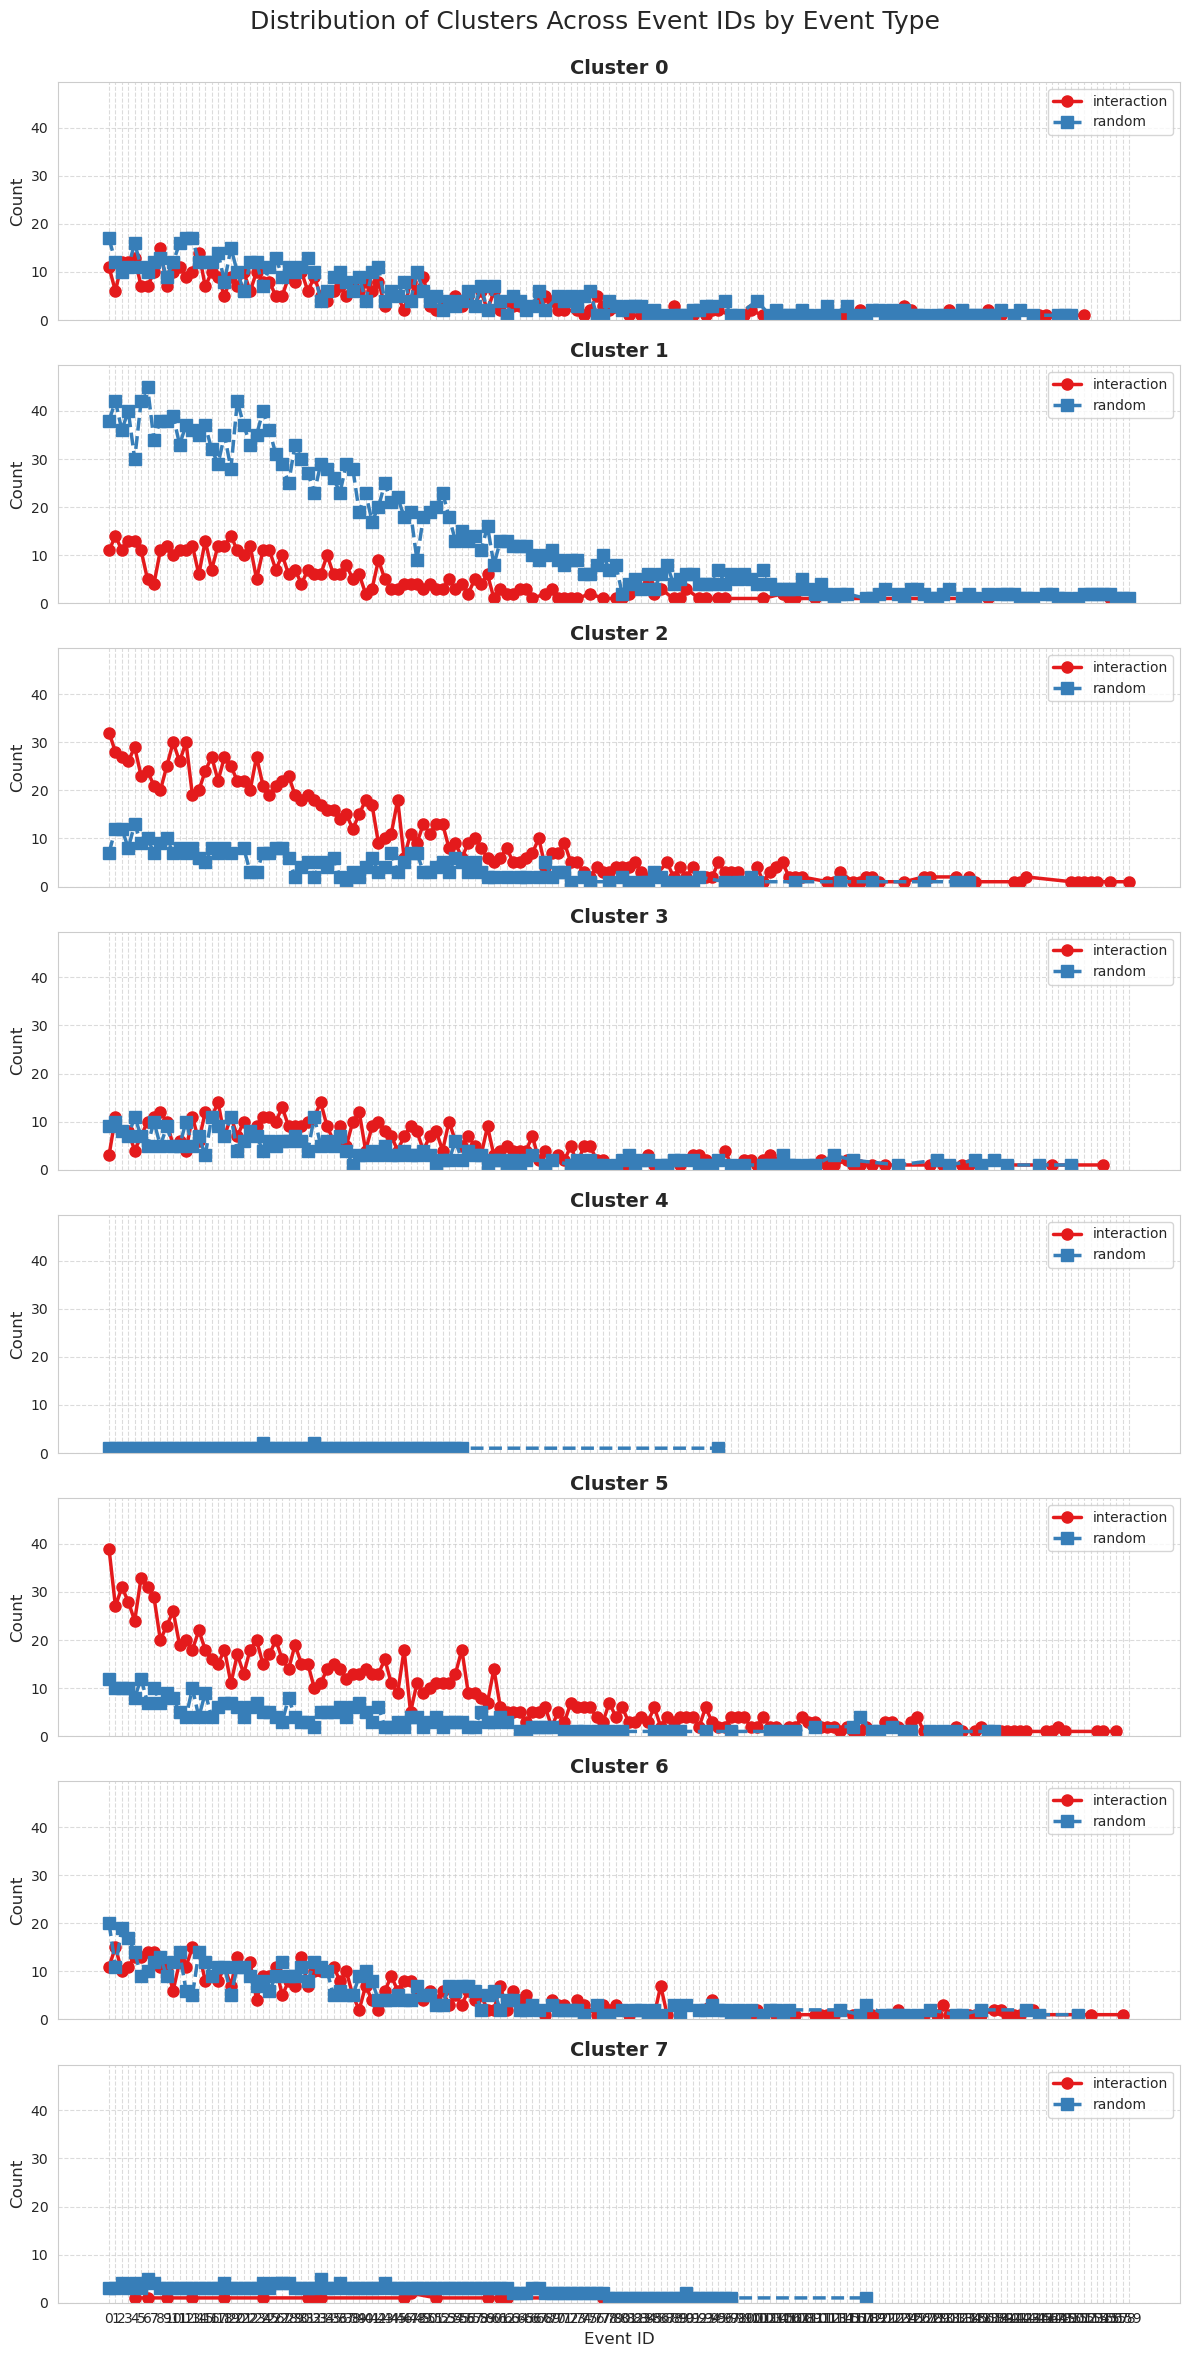

In [78]:
# Get all unique values from your dataset
clusters = sorted(Subset['cluster'].unique())
event_types = sorted(Subset['event_type'].unique())

# Count occurrences for each cluster, event_type, event_id combination
counts = Subset.groupby(['cluster', 'event_type', 'event_id']).size().reset_index(name='count')

# Find global maximum count for consistent y-axis scaling
max_count = counts['count'].max()

# Create a color palette for event types
colors = sns.color_palette("Set1", len(event_types))
event_type_colors = dict(zip(event_types, colors))

# Additional styling options for better differentiation
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D', '*', 'p', 'h']

# Ensure we have enough styles 
if len(event_types) > len(line_styles):
    line_styles = line_styles * (len(event_types) // len(line_styles) + 1)
if len(event_types) > len(markers):
    markers = markers * (len(event_types) // len(markers) + 1)

# Create mappings
event_type_styles = dict(zip(event_types, line_styles[:len(event_types)]))
event_type_markers = dict(zip(event_types, markers[:len(event_types)]))

# Create the figure and axes grid - one subplot per cluster
fig, axes = plt.subplots(len(clusters), 1, 
                       figsize=(12, 3 * len(clusters)),
                       sharex=True, sharey=True)  # Share both axes

# Ensure axes is always an array
if len(clusters) == 1:
    axes = np.array([axes])

# Get all unique event_ids across all event types
all_event_ids = sorted(Subset['event_id'].unique())

# Plot each cluster
for i, cluster in enumerate(clusters):
    ax = axes[i]
    
    # Loop through each event type and plot on the same axes with different colors and styles
    for j, event_type in enumerate(event_types):
        # Get data for this cluster and event type
        facet_data = counts[(counts['cluster'] == cluster) & 
                         (counts['event_type'] == event_type)]
        
        # Sort by event_id for proper plotting
        facet_data = facet_data.sort_values('event_id')
        
        # Plot if there's data
        if len(facet_data) > 0:
            # Use line plot with markers to show evolution
            ax.plot(facet_data['event_id'], facet_data['count'], 
                   marker=event_type_markers[event_type], markersize=8, 
                   linestyle=event_type_styles[event_type], linewidth=2.5, 
                   color=event_type_colors[event_type],
                   label=f"{event_type}")
    
    # Set labels and title for subplot
    ax.set_title(f"Cluster {cluster}", fontsize=14, fontweight='bold')
    ax.set_ylabel("Count", fontsize=12)
    if i == len(clusters) - 1:
        ax.set_xlabel("Event ID", fontsize=12)
        
    # Add grid for readability
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Set y-axis limits to be the same for all subplots
    ax.set_ylim(0, max(1, max_count * 1.1))  # Add 10% padding
    
    # Set x-axis to include all event IDs
    ax.set_xticks(all_event_ids)
    
    # Add legend to each subplot
    ax.legend(loc='upper right')

# Adjust layout
plt.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle('Distribution of Clusters Across Event IDs by Event Type', fontsize=18)

Text(0.5, 0.98, 'Proportion of Clusters by Event ID and Type (% of total events)')

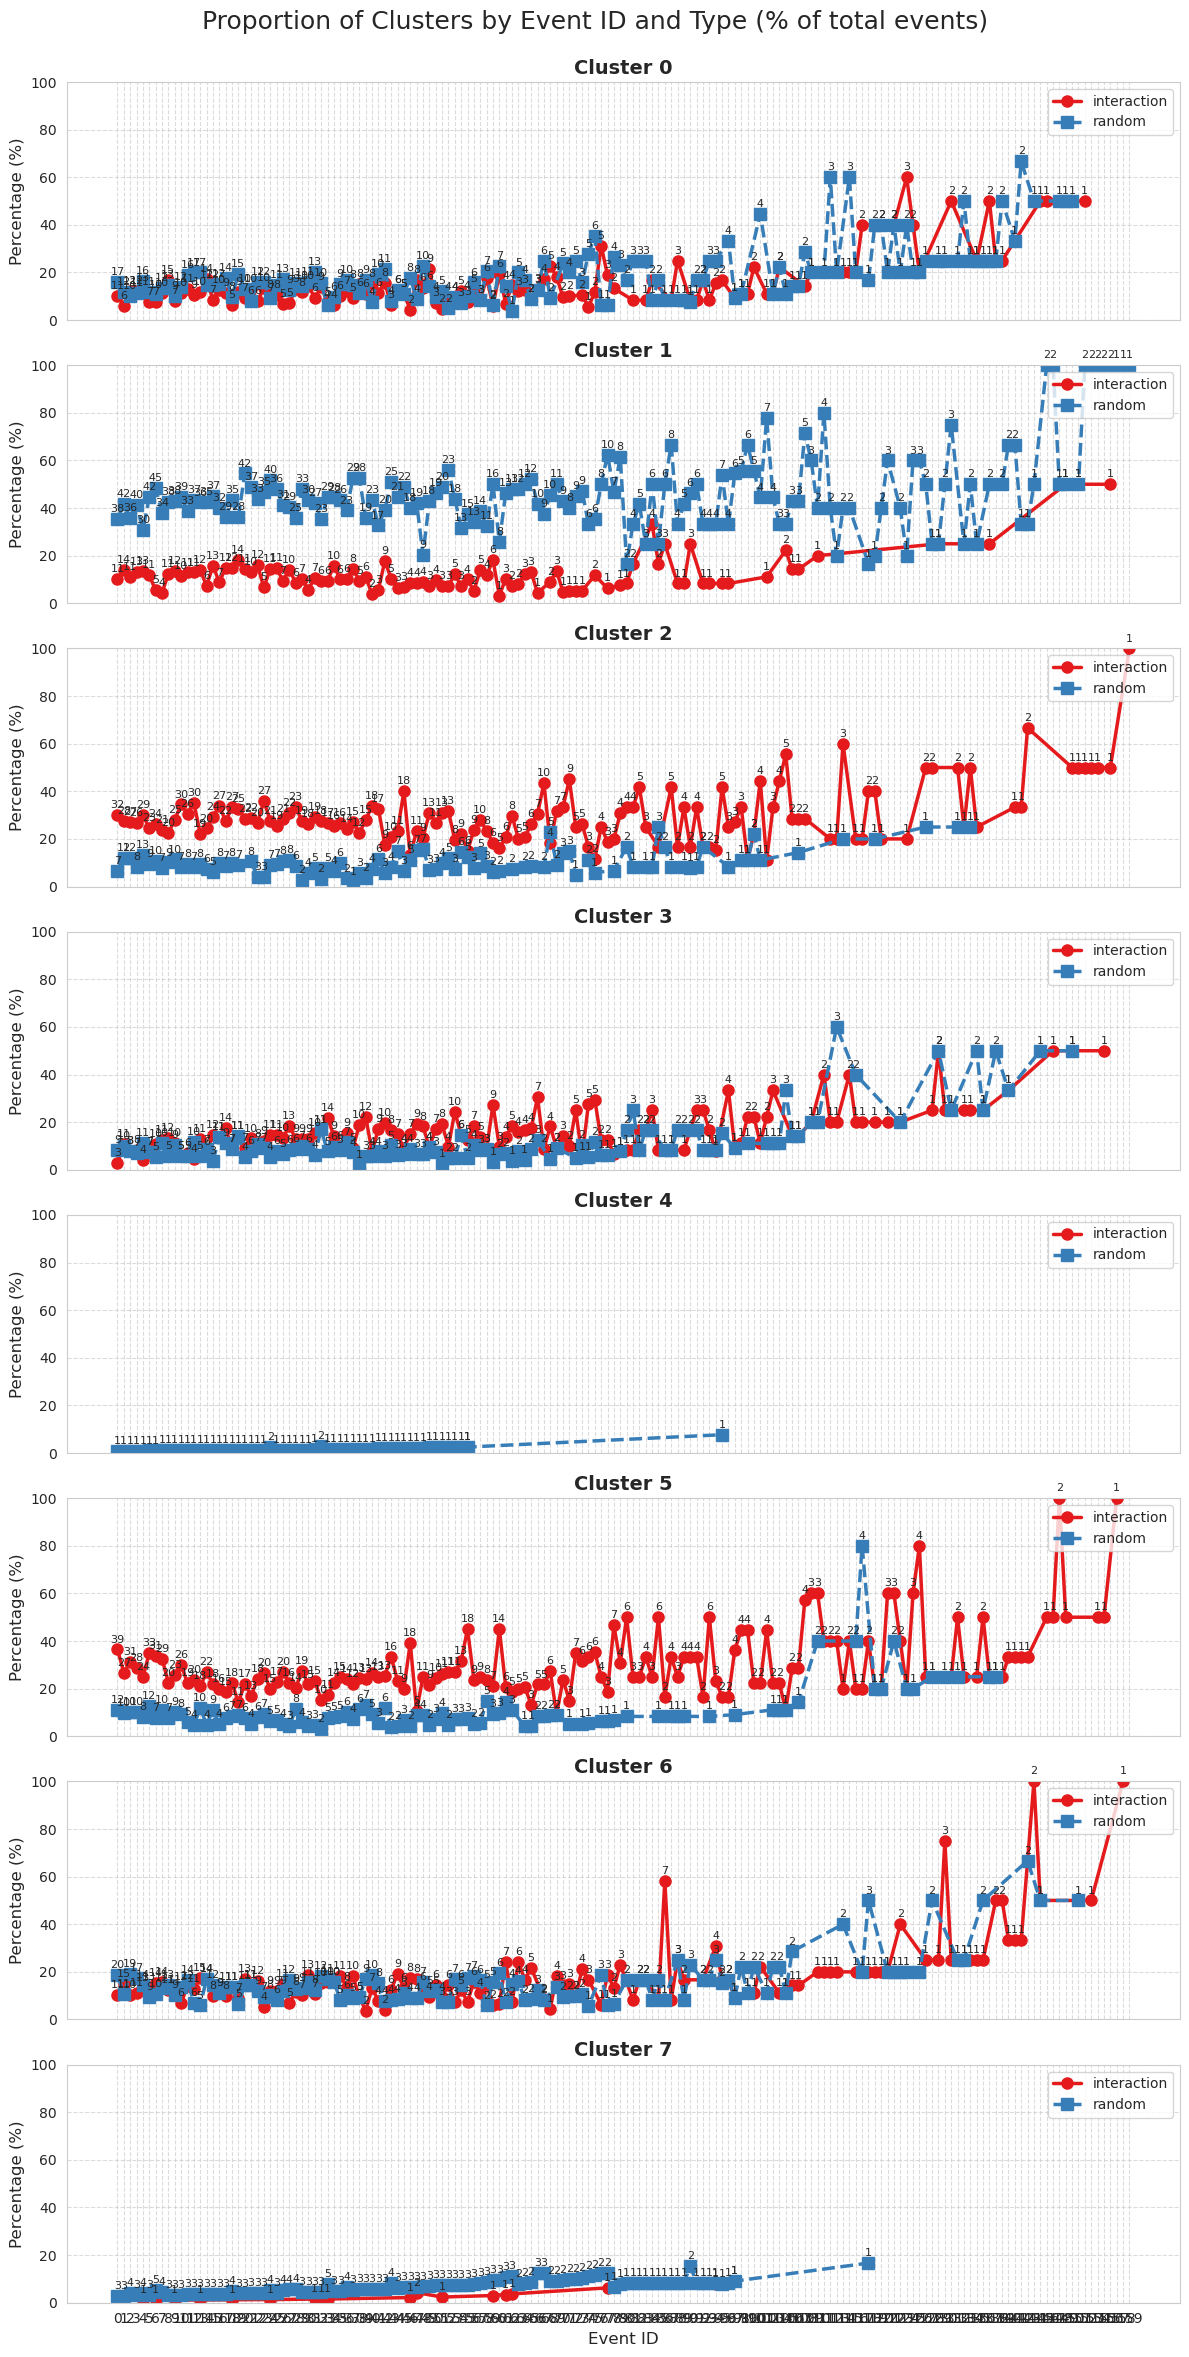

In [79]:
# Get all unique values from your dataset
clusters = sorted(Subset['cluster'].unique())
event_types = sorted(Subset['event_type'].unique())

# Count occurrences for each cluster, event_type, event_id combination
counts = Subset.groupby(['cluster', 'event_type', 'event_id']).size().reset_index(name='count')

# Calculate total events for each event_id and event_type combination
totals = Subset.groupby(['event_type', 'event_id']).size().reset_index(name='total')

# Merge totals with counts to calculate proportions
counts = counts.merge(totals, on=['event_type', 'event_id'], how='left')
counts['proportion'] = counts['count'] / counts['total'] * 100  # Convert to percentage

# Verify our calculations are correct - for each event_type and event_id, the sum of proportions should be 100%
verification = counts.groupby(['event_type', 'event_id'])['proportion'].sum().reset_index()
# Should be very close to 100 for each group (may have small floating point differences)

# Create a color palette for event types
colors = sns.color_palette("Set1", len(event_types))
event_type_colors = dict(zip(event_types, colors))

# Additional styling options for better differentiation
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D', '*', 'p', 'h']

# Ensure we have enough styles 
if len(event_types) > len(line_styles):
    line_styles = line_styles * (len(event_types) // len(line_styles) + 1)
if len(event_types) > len(markers):
    markers = markers * (len(event_types) // len(markers) + 1)

# Create mappings
event_type_styles = dict(zip(event_types, line_styles[:len(event_types)]))
event_type_markers = dict(zip(event_types, markers[:len(event_types)]))

# Create the figure and axes grid - one subplot per cluster
fig, axes = plt.subplots(len(clusters), 1, 
                       figsize=(12, 3 * len(clusters)),
                       sharex=True, sharey=True)  # Share both axes

# Ensure axes is always an array
if len(clusters) == 1:
    axes = np.array([axes])

# Get all unique event_ids across all event types
all_event_ids = sorted(Subset['event_id'].unique())

# Plot each cluster
for i, cluster in enumerate(clusters):
    ax = axes[i]
    
    # Loop through each event type and plot on the same axes with different colors and styles
    for j, event_type in enumerate(event_types):
        # Get data for this cluster and event type
        facet_data = counts[(counts['cluster'] == cluster) & 
                         (counts['event_type'] == event_type)]
        
        # Sort by event_id for proper plotting
        facet_data = facet_data.sort_values('event_id')
        
        # Plot if there's data
        if len(facet_data) > 0:
            # Use line plot with markers to show evolution, using the proportion
            ax.plot(facet_data['event_id'], facet_data['proportion'], 
                   marker=event_type_markers[event_type], markersize=8, 
                   linestyle=event_type_styles[event_type], linewidth=2.5, 
                   color=event_type_colors[event_type],
                   label=f"{event_type}")
            
            # Option: Add text labels showing the raw counts for context
            for idx, row in facet_data.iterrows():
                ax.annotate(f"{int(row['count'])}", 
                          (row['event_id'], row['proportion']),
                          textcoords="offset points", 
                          xytext=(0,5), 
                          ha='center',
                          fontsize=8)
    
    # Set labels and title for subplot
    ax.set_title(f"Cluster {cluster}", fontsize=14, fontweight='bold')
    ax.set_ylabel("Percentage (%)", fontsize=12)
    if i == len(clusters) - 1:
        ax.set_xlabel("Event ID", fontsize=12)
        
    # Add grid for readability
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Set y-axis limits to 0-100%
    ax.set_ylim(0, 100)  
    
    # Set x-axis to include all event IDs
    ax.set_xticks(all_event_ids)
    
    # Add legend to each subplot
    ax.legend(loc='upper right')

# Adjust layout
plt.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle('Proportion of Clusters by Event ID and Type (% of total events)', fontsize=18)

In [81]:
Umap_First = Umap[Umap["event_id"] < 10]

Text(0.5, 0.98, 'Distribution of Clusters Across Event IDs by Event Type')

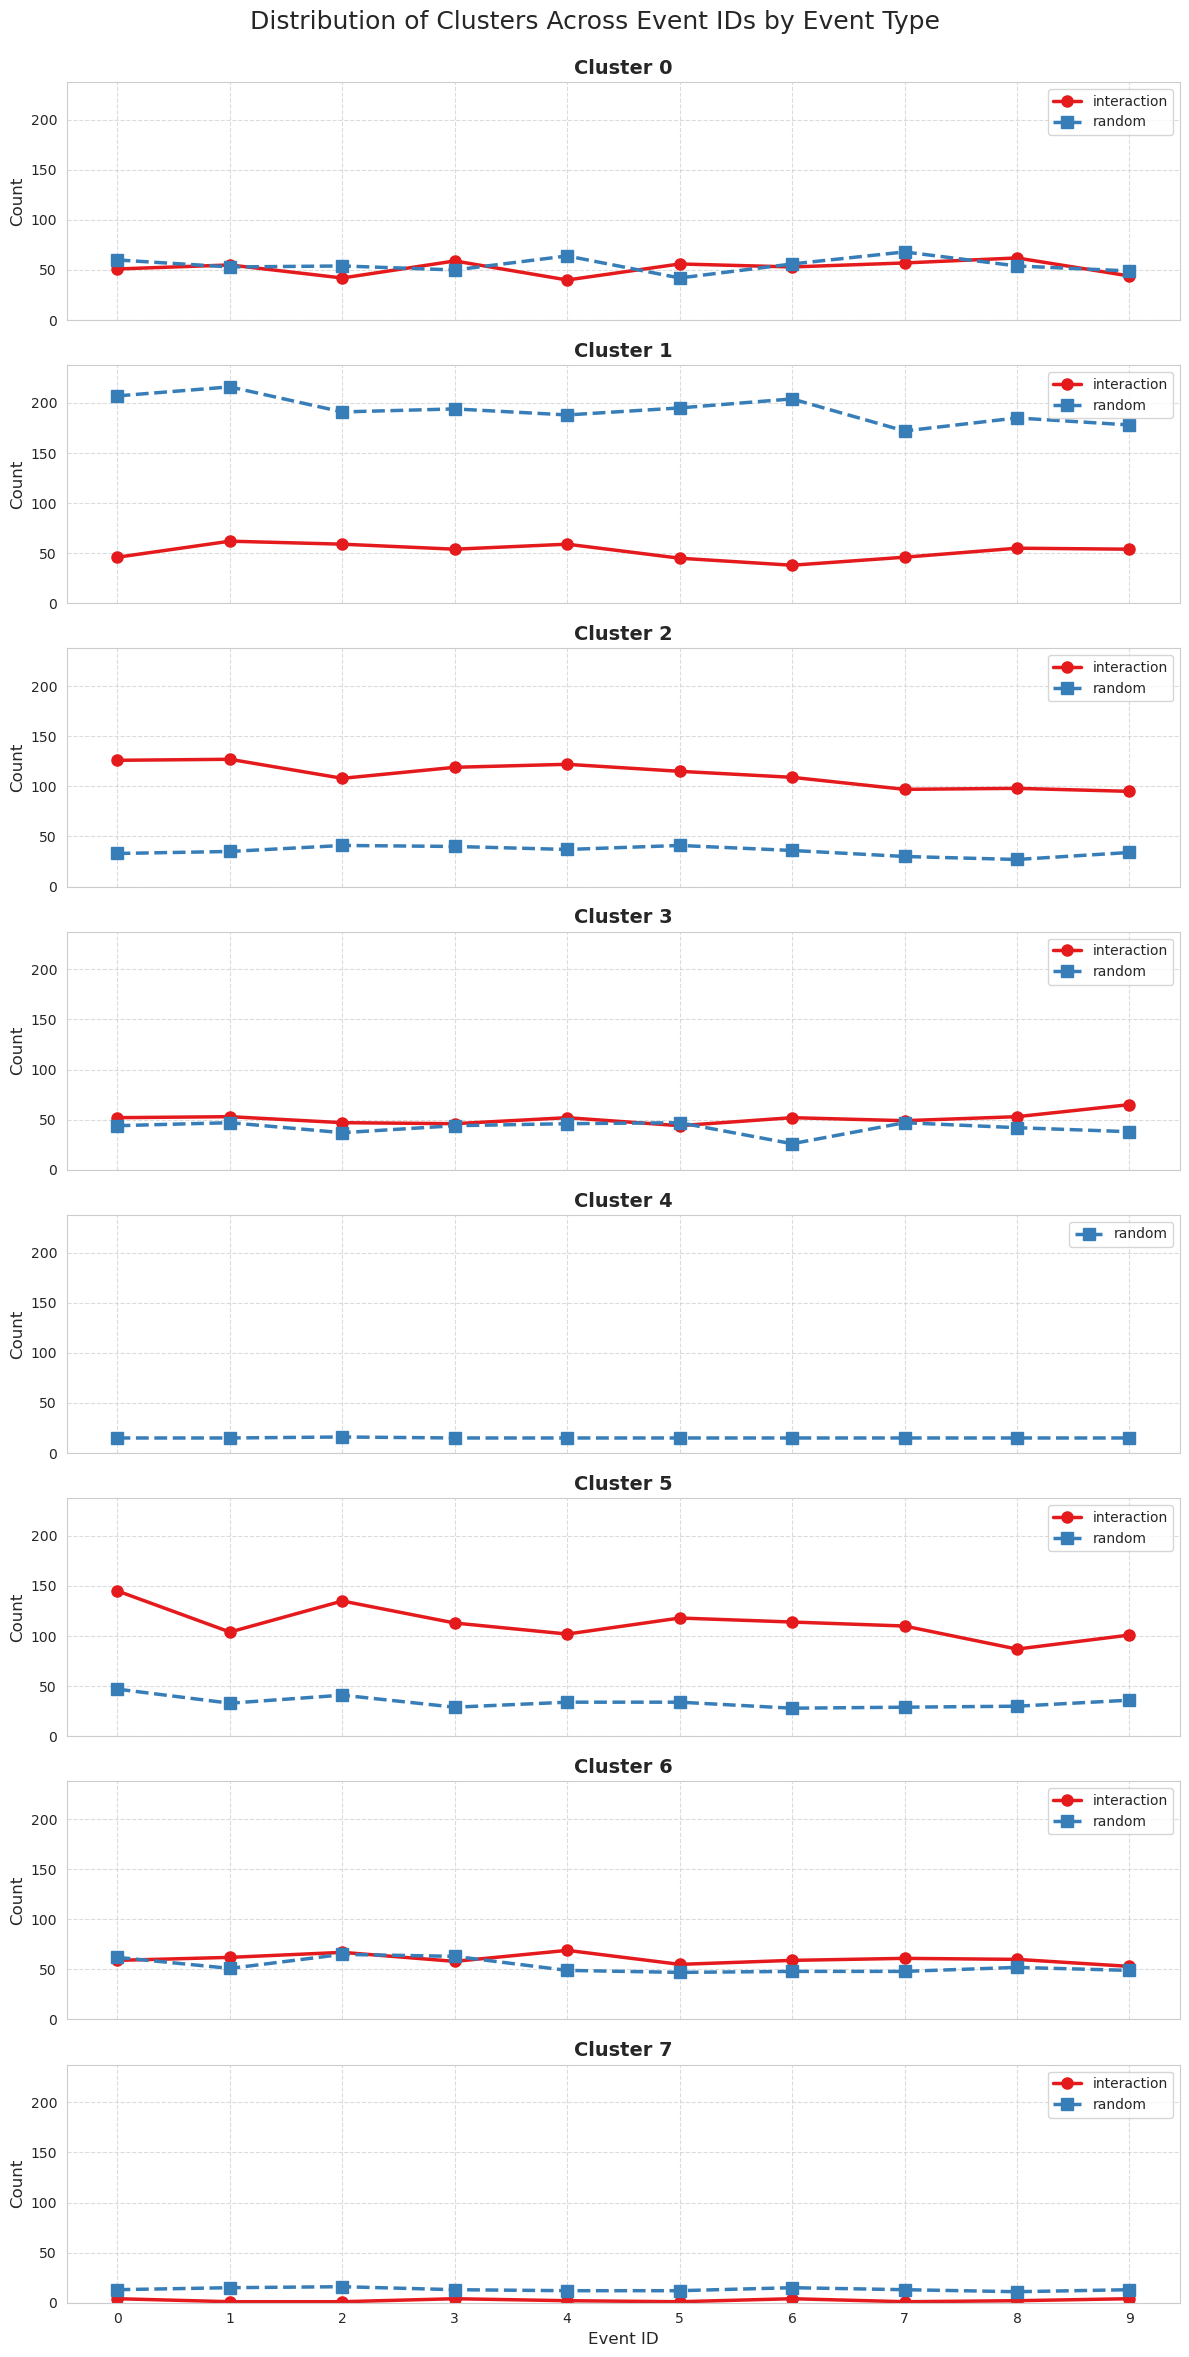

In [82]:
# Get all unique values from your dataset
clusters = sorted(Umap_First['cluster'].unique())
event_types = sorted(Umap_First['event_type'].unique())

# Count occurrences for each cluster, event_type, event_id combination
counts = Umap_First.groupby(['cluster', 'event_type', 'event_id']).size().reset_index(name='count')

# Find global maximum count for consistent y-axis scaling
max_count = counts['count'].max()

# Create a color palette for event types
colors = sns.color_palette("Set1", len(event_types))
event_type_colors = dict(zip(event_types, colors))

# Additional styling options for better differentiation
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D', '*', 'p', 'h']

# Ensure we have enough styles 
if len(event_types) > len(line_styles):
    line_styles = line_styles * (len(event_types) // len(line_styles) + 1)
if len(event_types) > len(markers):
    markers = markers * (len(event_types) // len(markers) + 1)

# Create mappings
event_type_styles = dict(zip(event_types, line_styles[:len(event_types)]))
event_type_markers = dict(zip(event_types, markers[:len(event_types)]))

# Create the figure and axes grid - one subplot per cluster
fig, axes = plt.subplots(len(clusters), 1, 
                       figsize=(12, 3 * len(clusters)),
                       sharex=True, sharey=True)  # Share both axes

# Ensure axes is always an array
if len(clusters) == 1:
    axes = np.array([axes])

# Get all unique event_ids across all event types
all_event_ids = sorted(Umap_First['event_id'].unique())

# Plot each cluster
for i, cluster in enumerate(clusters):
    ax = axes[i]
    
    # Loop through each event type and plot on the same axes with different colors and styles
    for j, event_type in enumerate(event_types):
        # Get data for this cluster and event type
        facet_data = counts[(counts['cluster'] == cluster) & 
                         (counts['event_type'] == event_type)]
        
        # Sort by event_id for proper plotting
        facet_data = facet_data.sort_values('event_id')
        
        # Plot if there's data
        if len(facet_data) > 0:
            # Use line plot with markers to show evolution
            ax.plot(facet_data['event_id'], facet_data['count'], 
                   marker=event_type_markers[event_type], markersize=8, 
                   linestyle=event_type_styles[event_type], linewidth=2.5, 
                   color=event_type_colors[event_type],
                   label=f"{event_type}")
    
    # Set labels and title for subplot
    ax.set_title(f"Cluster {cluster}", fontsize=14, fontweight='bold')
    ax.set_ylabel("Count", fontsize=12)
    if i == len(clusters) - 1:
        ax.set_xlabel("Event ID", fontsize=12)
        
    # Add grid for readability
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Set y-axis limits to be the same for all subplots
    ax.set_ylim(0, max(1, max_count * 1.1))  # Add 10% padding
    
    # Set x-axis to include all event IDs
    ax.set_xticks(all_event_ids)
    
    # Add legend to each subplot
    ax.legend(loc='upper right')

# Adjust layout
plt.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle('Distribution of Clusters Across Event IDs by Event Type', fontsize=18)

<Axes: xlabel='binned_event_id', ylabel='raw_displacement'>

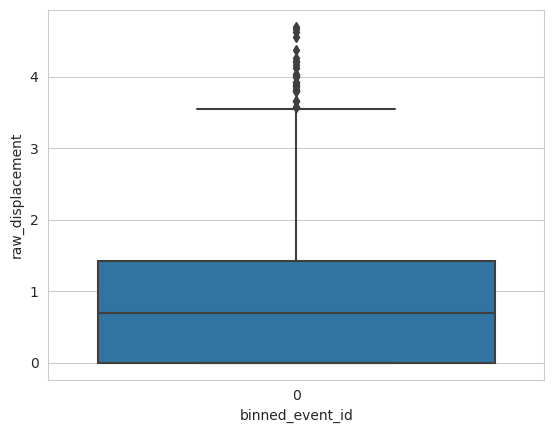

In [83]:
sns.boxplot(data=Subset_Subset_FirstContacts_interaction, x="binned_event_id", y=np.log1p(Subset_Subset_FirstContacts_interaction["raw_displacement"]))

In [84]:
# Find potential column informing about the direction of the displacement

Umap.columns[Umap.columns.str.contains("direction")]

Index(['direction'], dtype='object')

## Ball direction

In [85]:
Umap["direction"].unique()

array([-1,  1])

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

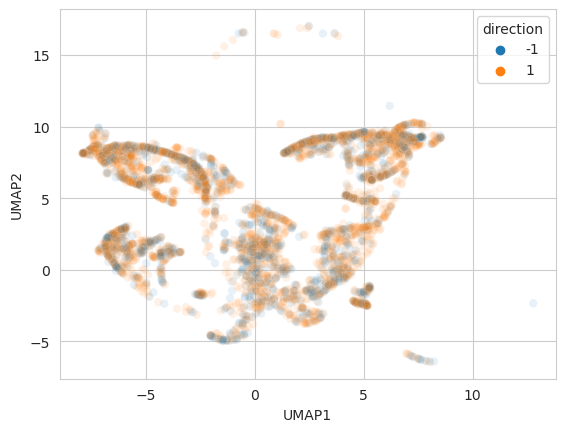

In [86]:
sns.scatterplot(
    data=Subset_interaction, x="UMAP1", y="UMAP2", alpha=0.1, hue="direction", palette="tab10"
)

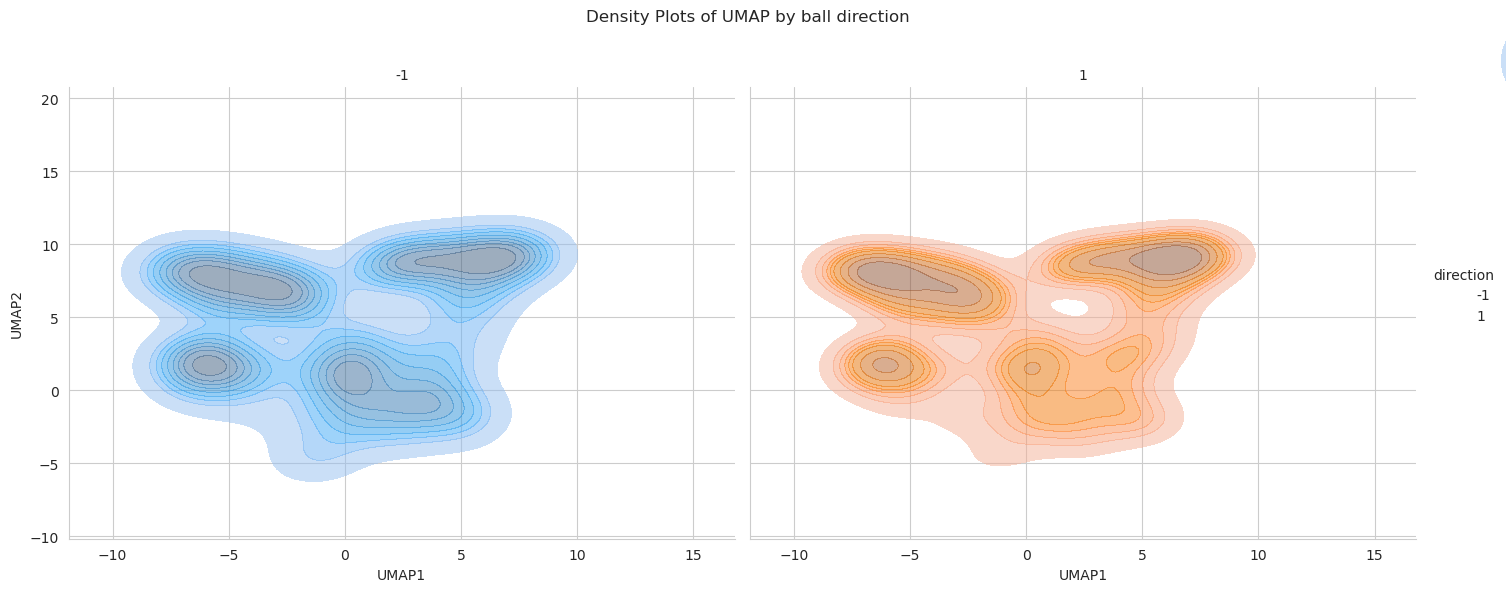

In [87]:
# Create a FacetGrid with two columns, one for each direction
g = sns.FacetGrid(
    Subset_interaction,
    col="direction",
    hue="direction",
    sharex=True,
    sharey=True,
    height=6,
    aspect=1.2,
)

# Map the kdeplot to the FacetGrid
g.map(sns.kdeplot, "UMAP1", "UMAP2", fill=True, alpha=0.5)

# Add titles and adjust layout
g.set_titles(col_template="{col_name}")
g.add_legend()
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Density Plots of UMAP by ball direction")

# Save the plot
plt.savefig(f"{output_dir}/UMAP_Direction_Density.png")
plt.show()
plt.close()



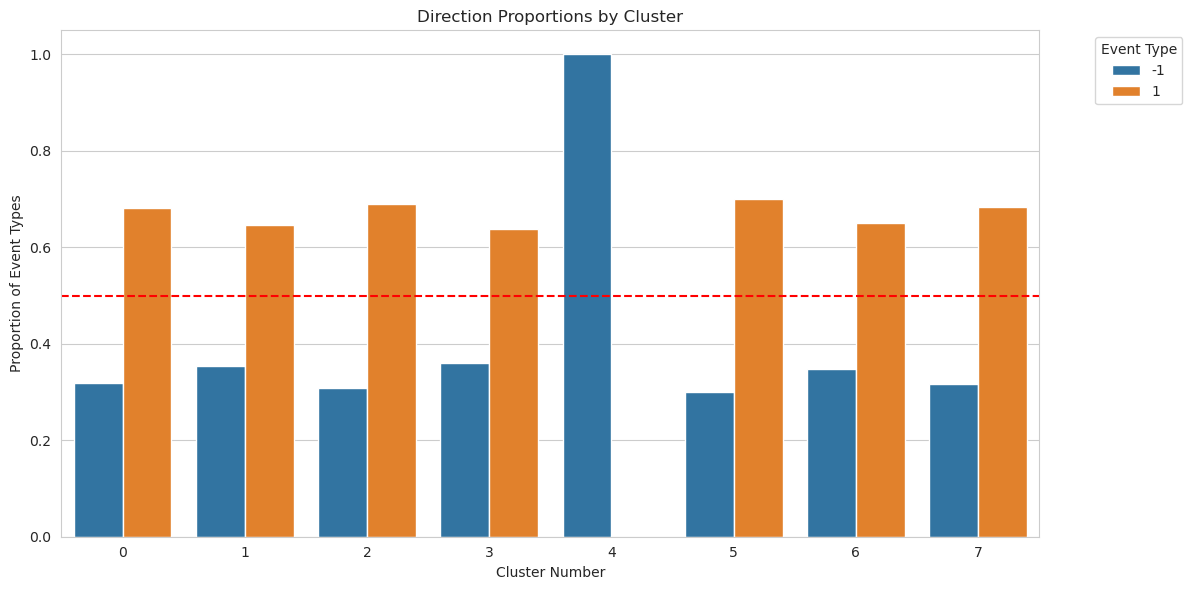

In [88]:
# Get unique clusters
unique_clusters = Subset_interaction["cluster"].unique()

# Initialize a DataFrame to store the proportions
proportions_df = pd.DataFrame()

# Process each cluster
for cluster_id in unique_clusters:
    cluster_data = Subset_interaction[Subset_interaction["cluster"] == cluster_id]
    
    # Count event types and calculate proportions
    event_counts = cluster_data["direction"].value_counts(normalize=True).reset_index()
    event_counts.columns = ["direction", "proportion"]
    event_counts["cluster"] = cluster_id
    
    # Append to the proportions DataFrame
    proportions_df = pd.concat([proportions_df, event_counts], ignore_index=True)

# Plot event type proportions as bar plots
plt.figure(figsize=(12, 6))
sns.barplot(data=proportions_df, x="cluster", y="proportion", hue="direction")
plt.axhline(0.5, color='red', linestyle='--')
plt.title("Direction Proportions by Cluster")
plt.xlabel("Cluster Number")
plt.ylabel("Proportion of Event Types")
plt.legend(title="Event Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot
plt.savefig(f"{output_dir}/direction_proportions_by_cluster.png")
plt.show()
plt.close()

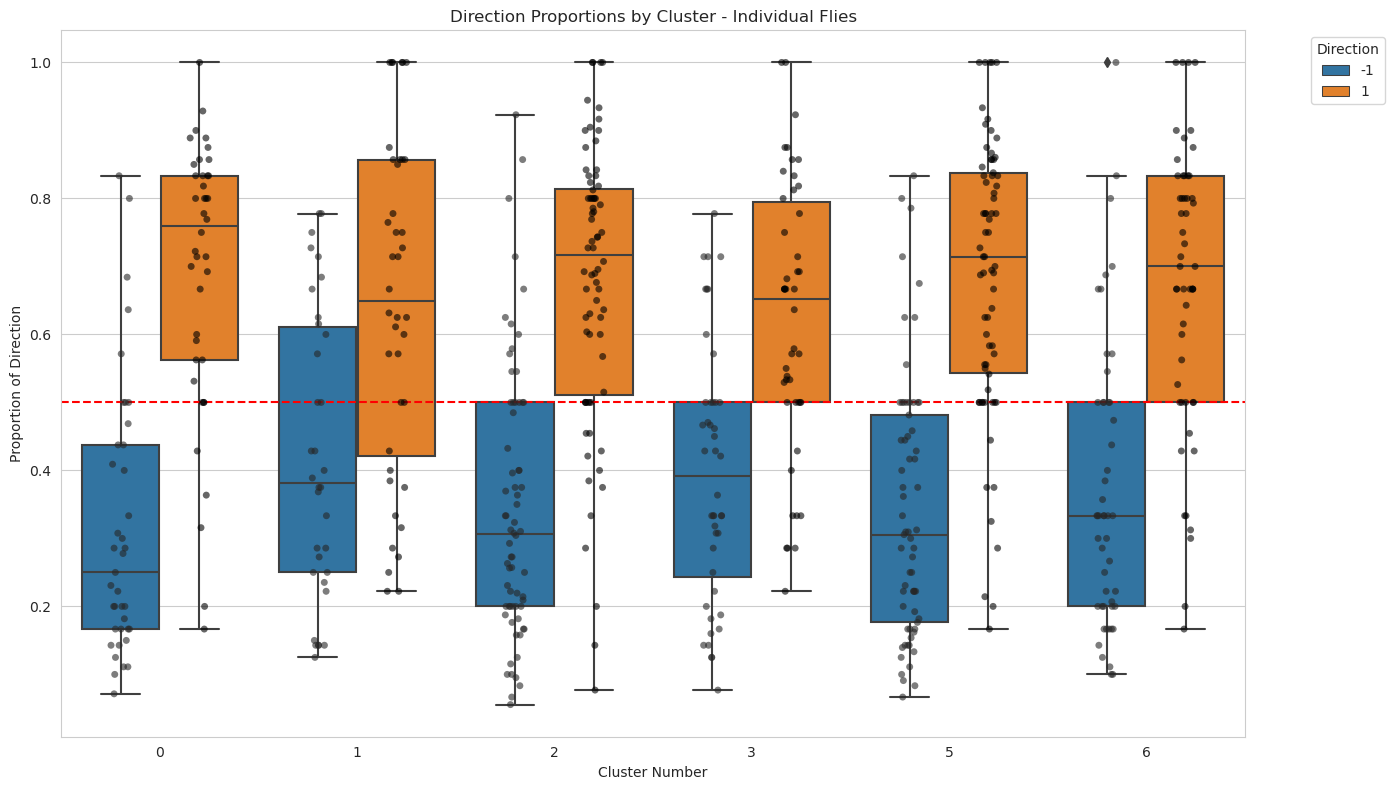

In [89]:
# Get unique clusters
unique_clusters = Subset_interaction["cluster"].unique()

# Initialize a DataFrame to store the individual fly proportions
fly_proportions_df = pd.DataFrame()

# Process each cluster and fly combination
for cluster_id in unique_clusters:
    cluster_data = Subset_interaction[Subset_interaction["cluster"] == cluster_id]
    
    # Get unique flies in this cluster
    unique_flies = cluster_data["fly"].unique()
    
    for fly_id in unique_flies:
        # Get data for this specific fly and cluster
        fly_cluster_data = cluster_data[cluster_data["fly"] == fly_id]
        
        # Only process if we have enough data points for this fly
        if len(fly_cluster_data) >= 5:  # Minimum threshold to calculate meaningful proportion
            # Count direction types and calculate proportions
            direction_counts = fly_cluster_data["direction"].value_counts(normalize=True).reset_index()
            direction_counts.columns = ["direction", "proportion"]
            direction_counts["cluster"] = cluster_id
            direction_counts["fly"] = fly_id
            
            # Append to the proportions DataFrame
            fly_proportions_df = pd.concat([fly_proportions_df, direction_counts], ignore_index=True)

# Plot with individual fly data points
plt.figure(figsize=(14, 8))

# Add individual datapoints as a swarm plot
sns.boxplot(data=fly_proportions_df, x="cluster", y="proportion", hue="direction")

# Add the mean proportion as reference points
sns.stripplot(data=fly_proportions_df, x="cluster", y="proportion", hue="direction",color="black", size=5, alpha=0.6, dodge=True)

plt.axhline(0.5, color='red', linestyle='--', label="Equal proportion")
plt.title("Direction Proportions by Cluster - Individual Flies")
plt.xlabel("Cluster Number")
plt.ylabel("Proportion of Direction")

# Create a better legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title="Direction", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# Save the plot
plt.savefig(f"{output_dir}/direction_proportions_by_cluster_individual_flies.png")
plt.show()
plt.close()

In [ ]:
# Cluster by displacement

# Find columns that contain "displacement" in their name

Disp = Umap.filter(regex="displacement")

Disp

In [ ]:
sns.scatterplot(data=Umap, x="raw_displacement", y="cluster", alpha=0.1)

In [ ]:
# Get columns that have no x or y in their name, nor velocity

Umap.columns[~Umap.columns.str.contains("x|y|velocity")]

In [ ]:
PosPush = Umap[Umap["raw_displacement"] > 1]

In [ ]:
bin_metric(PosPush, "raw_displacement", 5)

In [ ]:
sns.histplot(data=PosPush, x="raw_displacement")

In [ ]:
sns.boxplot(data=Umap, x="cluster", y="raw_displacement")

# Adjust y range
plt.ylim(0, 10)

In [ ]:
Firstcontacts = Umap[Umap["event_id"] <10 ]

Firstcontacts = Firstcontacts[Firstcontacts["event_type"] == "interaction"]

In [ ]:
bin_metric(Firstcontacts, "start_distance", 10)

/home/matthias/miniconda3/envs/trackinganalysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/matthias/miniconda3/envs/trackinganalysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/matthias/miniconda3/envs/trackinganalysis/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/

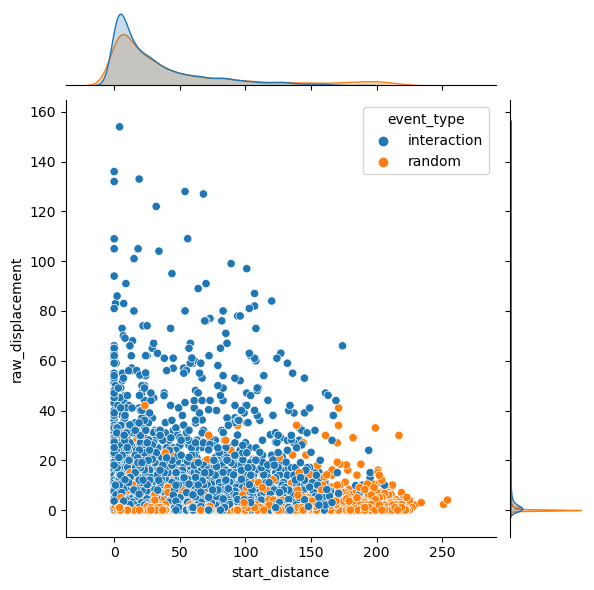

In [11]:
sns.jointplot(data=Umap, x="start_distance", y="raw_displacement", hue="event_type")

# plt.ylim(0, 10)

In [ ]:
# Plot side by side the umap values of event_type interaction and random with hue being the binned_end_distance
# Create a FacetGrid with two columns, one for each event_type
g = sns.FacetGrid(
    PosPush,
    col="event_type",
    sharex=True,
    sharey=True,
    height=6,
    aspect=1.2,
)

# Map the scatterplot to the FacetGrid
g.map_dataframe(
    sns.scatterplot,
    x="UMAP1",
    y="UMAP2",
    hue="cluster",
    alpha=0.5,
    palette="tab10",
)

# Add titles and adjust layout
g.set_titles(col_template="{col_name}")
g.add_legend()
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Density Plots of UMAP by Event Type")

# Save the plot
plt.savefig(f"{output_dir}/UMAP_event_types_efficiency_cluster.png")
plt.show()
plt.close()

In [ ]:
PosPush = Umap[Umap["raw_displacement"] >= 1]

In [ ]:
bin_metric(PosPush, "raw_displacement", 5)

In [ ]:
# Calculate cluster proportions over time by event type
cluster_proportions = (PosPush
                      .groupby(['event_type', 'binned_raw_displacement', 'cluster'])
                      .size()
                      .reset_index(name='count'))

# Calculate totals for proportions
totals = (cluster_proportions
         .groupby(['event_type', 'binned_raw_displacement'])['count']
         .sum()
         .reset_index(name='total'))

# Merge and calculate proportions
cluster_proportions = cluster_proportions.merge(
    totals, on=['event_type', 'binned_raw_displacement'])
cluster_proportions['proportion'] = cluster_proportions['count'] / cluster_proportions['total']

In [ ]:
plt.figure(figsize=(20, 10))

for i, event_type in enumerate(PosPush["event_type"].unique()):
    plt.subplot(1, 2, i + 1)

    # Filter to just this event type
    event_data = cluster_proportions[cluster_proportions["event_type"] == event_type]

    # Plot a line for each cluster
    for cluster in sorted(PosPush["cluster"].unique()):
        cluster_data = event_data[event_data["cluster"] == cluster]
        if not cluster_data.empty:
            plt.plot(
                cluster_data["binned_raw_displacement"],
                cluster_data["proportion"],
                marker="o",
                linewidth=2,
                label=f"Cluster {cluster}",
            )

    plt.title(f"Cluster Efficiency - {event_type}", fontsize=14)
    plt.xlabel("Efficiency", fontsize=12)
    plt.ylabel("Proportion of Events", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.savefig(f"{output_dir}/positive_disps_cluster_efficiency_line_plots.png")
plt.show()

In [ ]:
# Calculate cluster proportions over time by event type
cluster_proportions = (
    Umap.groupby(["binned_raw_displacement", "cluster"])
    .size()
    .reset_index(name="count")
)

# Calculate totals for proportions
totals = (
    cluster_proportions.groupby(["binned_raw_displacement"])["count"]
    .sum()
    .reset_index(name="total")
)

# Merge and calculate proportions
cluster_proportions = cluster_proportions.merge(
    totals, on=["binned_raw_displacement"]
)
cluster_proportions["proportion"] = (
    cluster_proportions["count"] / cluster_proportions["total"]
)
plt.figure(figsize=(20, 10))

# Plot a line for each cluster
for cluster in sorted(Umap["cluster"].unique()):
    cluster_data = event_data[event_data["cluster"] == cluster]
    if not cluster_data.empty:
        plt.plot(
            cluster_data["binned_raw_displacement"],
            cluster_data["proportion"],
            marker="o",
            linewidth=2,
            label=f"Cluster {cluster}",
        )

plt.title(f"Cluster Efficiency", fontsize=14)
plt.xlabel("Efficiency", fontsize=12)
plt.ylabel("Proportion of Events", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.savefig(f"{output_dir}/cluster_efficiency_line_plots_pooled.png")
plt.show()

In [ ]:
# Calculate cluster proportions over time by event type AND fly
fly_cluster_proportions = (
    Umap.groupby(["fly", "event_type", "binned_raw_displacement", "cluster"])
    .size()
    .reset_index(name="count")
)

# Calculate totals for proportions (per fly and time bin)
fly_totals = (
    fly_cluster_proportions.groupby(["fly", "event_type", "binned_raw_displacement"])["count"]
    .sum()
    .reset_index(name="total")
)

# Merge and calculate proportions
fly_cluster_proportions = fly_cluster_proportions.merge(
    fly_totals, on=["fly", "event_type", "binned_raw_displacement"]
)
fly_cluster_proportions["proportion"] = (
    fly_cluster_proportions["count"] / fly_cluster_proportions["total"]
)

In [ ]:
# Create a facet grid of box plots
g = sns.FacetGrid(
    fly_cluster_proportions,
    col="event_type",
    row="cluster",
    margin_titles=True,
    height=3,
    aspect=1.5,
)

# Map the box plot
g.map_dataframe(sns.boxplot, x="binned_raw_displacement", y="proportion", color="skyblue")

# Add strip plot to show individual fly points
g.map_dataframe(
    sns.stripplot,
    x="binned_raw_displacement",
    y="proportion",
    color="black",
    size=2,
    alpha=0.5,
    jitter=True,
)

# Add titles and labels
g.set_axis_labels("Time Bin", "Proportion")
g.set_titles(col_template="{col_name}", row_template="Cluster {row_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Cluster Distribution by Efficiency", fontsize=16)

plt.savefig(f"{output_dir}/cluster_evolution_by_efficiency_box_plots.png")
plt.show()

# UMAP only with interaction data

In [ ]:
Interaction_UMAP = pd.read_feather("/mnt/upramdya_data/MD/Ballpushing_Exploration/Datasets/250312_StdContacts_Ctrl_noRandom_cutoff_300frames_Data/UMAP/250312_pooled_standardized_contacts.feather")

In [ ]:
# Define and create if not exist output directory

output_dir = Path("/mnt/upramdya_data/MD/Ballpushing_Exploration/Behavior_classification/UMAP/250311_Pooled_FeedingState_InteractionsOnly_300Frames")

output_dir.mkdir(parents=True, exist_ok=True)


In [ ]:

# Scatter plot of UMAP1 vs UMAP2

sns.scatterplot(data=Interaction_UMAP, x="UMAP1", y="UMAP2", alpha = 0.1)

# save the plot

plt.savefig(f"{output_dir}/UMAP.png")


In [ ]:
# Same with density

plt.figure(figsize=(8, 6))

sns.kdeplot(data=Interaction_UMAP, x="UMAP1", y="UMAP2", fill=True, alpha=0.5)

plt.savefig(f"{output_dir}/UMAP_density.png")

plt.show()

# Cluster detection

In [ ]:
# Identify clusters based on KMeans

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=12, random_state=0).fit(Interaction_UMAP[["UMAP1", "UMAP2"]])

Interaction_UMAP["cluster"] = kmeans.labels_

plt.figure(figsize=(8, 6))

sns.scatterplot(data=Interaction_UMAP, x="UMAP1", y="UMAP2", alpha = 0.1, hue="cluster", palette="tab10")

# Save the plot

plt.savefig(f"{output_dir}/UMAP_Clusters.png")

plt.show()

# Looking at metrics of time / progress

In [ ]:
bin_metric(Interaction_UMAP, "event_id", 50)

# Event ID

In [ ]:
sns.scatterplot(data=Interaction_UMAP, x="UMAP1", y="UMAP2", hue="binned_event_id", alpha = 0.4, palette="viridis")

In [ ]:
# Look at distribution of event id

sns.histplot(data=Interaction_UMAP, x="event_id", bins=50)

In [ ]:
# Create the FacetGrid with multiple columns
g = sns.FacetGrid(Interaction_UMAP, col="binned_event_id", hue="binned_event_id", sharex=True, sharey=True, height=10, aspect=1.2, col_wrap=5)

# Map the kdeplot to the FacetGrid
g.map(sns.kdeplot, "UMAP1", "UMAP2", fill=True, alpha=0.5)

# Standardize x and y range for all subplots
g.set(xlim=(Interaction_UMAP["UMAP1"].min()-3, Interaction_UMAP["UMAP1"].max()+3), ylim=(Interaction_UMAP["UMAP2"].min()-3, Interaction_UMAP["UMAP2"].max()+3))

# Add titles and adjust layout
g.set_titles(col_template="{col_name}")
g.add_legend()
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Density Plots of UMAP by Event ID")

# Save the plot
plt.savefig(f"{output_dir}/UMAP_event_id_density.png")
plt.show()

In [ ]:
# Create the FacetGrid with multiple columns
g = sns.FacetGrid(Interaction_UMAP, col="binned_event_id", hue="binned_event_id", sharex=True, sharey=True, height=10, aspect=1.2, col_wrap=5)

# Map the kdeplot to the FacetGrid
g.map(sns.scatterplot, "UMAP1", "UMAP2", alpha=0.5)

# Standardize x and y range for all subplots
g.set(xlim=(Interaction_UMAP["UMAP1"].min()-3, Interaction_UMAP["UMAP1"].max()+3), ylim=(Interaction_UMAP["UMAP2"].min()-3, Interaction_UMAP["UMAP2"].max()+3))

# Add titles and adjust layout
g.set_titles(col_template="{col_name}")
g.add_legend()
plt.subplots_adjust(top=0.85)
g.fig.suptitle("UMAP by Event ID")

# Save the plot
plt.savefig(f"{output_dir}/UMAP_event_id.png")
plt.show()

In [ ]:
# Get unique event_ids
unique_event_ids = Interaction_UMAP["binned_event_id"].unique()

# Initialize a DataFrame to store the proportions
proportions_df = pd.DataFrame()

# Process each event_id
for event_id in unique_event_ids:
    event_data = Interaction_UMAP[Interaction_UMAP["binned_event_id"] == event_id]
    
    # Count clusters and calculate proportions within the event_id
    cluster_counts = event_data["cluster"].value_counts(normalize=True).reset_index()
    cluster_counts.columns = ["cluster", "proportion"]
    cluster_counts["binned_event_id"] = event_id
    
    # Append to the proportions DataFrame
    proportions_df = pd.concat([proportions_df, cluster_counts], ignore_index=True)

# Plot cluster proportions as bar plots
plt.figure(figsize=(30, 30))
sns.lineplot(data=proportions_df, x="binned_event_id", y="proportion", hue="cluster", palette="tab10", linewidth=2)
plt.title("Cluster Proportions by Event ID")
plt.xlabel("Event ID (Binned)")
plt.ylabel("Proportion of Clusters")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot
plt.savefig(f"{output_dir}/cluster_proportions_by_binned_event_id.png")
plt.show()
plt.close()

In [ ]:
# Group the data by fly and binned_event_id and calculate proportions
grouped = Interaction_UMAP.groupby(["fly", "binned_event_id", "cluster"]).size().reset_index(name="count")
total_counts = grouped.groupby(["fly", "binned_event_id"])["count"].transform("sum")
grouped["proportion"] = grouped["count"] / total_counts

# Plot cluster proportions as box plots with jittered strip plots
plt.figure(figsize=(14, 8))
sns.boxplot(data=grouped, x="binned_event_id", y="proportion", hue="cluster", palette="tab10")
#sns.stripplot(data=grouped, x="binned_event_id", y="proportion", hue="cluster", dodge=True, color="black", alpha=0.5, jitter=False)

# Adjust plot aesthetics
plt.title("Cluster Proportions by Event ID (Grouped by Fly)")
plt.xlabel("Event ID (Binned)")
plt.ylabel("Proportion of Clusters")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot
plt.savefig(f"{output_dir}/jitterbp_cluster_proportions_by_binned_event_id_grouped_by_fly.png")
plt.show()
plt.close()

# With event id subset

In [ ]:
FirstIDs = Interaction_UMAP[Interaction_UMAP["event_id"] < 30]

In [ ]:
sns.scatterplot(data=FirstIDs, x="UMAP1", y="UMAP2", hue="event_id", alpha = 0.4, palette="viridis")

In [ ]:
# Create the FacetGrid with multiple columns
g = sns.FacetGrid(FirstIDs, col="event_id", hue="event_id", sharex=True, sharey=True, height=10, aspect=1.2, col_wrap=5)

# Map the kdeplot to the FacetGrid
g.map(sns.kdeplot, "UMAP1", "UMAP2", fill=True, alpha=0.5)

# Standardize x and y range for all subplots
g.set(xlim=(FirstIDs["UMAP1"].min()-3, FirstIDs["UMAP1"].max()+3), ylim=(FirstIDs["UMAP2"].min()-3, FirstIDs["UMAP2"].max()+3))

# Add titles and adjust layout
g.set_titles(col_template="{col_name}")
g.add_legend()
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Density Plots of UMAP by Event ID")

# Save the plot
plt.savefig(f"{output_dir}/UMAP_event_id_subset_density.png")
plt.show()

In [ ]:
# Get unique event_ids
unique_event_ids = FirstIDs["event_id"].unique()

# Initialize a DataFrame to store the proportions
proportions_df = pd.DataFrame()

# Process each event_id
for event_id in unique_event_ids:
    event_data = FirstIDs[FirstIDs["event_id"] == event_id]
    
    # Count clusters and calculate proportions within the event_id
    cluster_counts = event_data["cluster"].value_counts(normalize=True).reset_index()
    cluster_counts.columns = ["cluster", "proportion"]
    cluster_counts["event_id"] = event_id
    
    # Append to the proportions DataFrame
    proportions_df = pd.concat([proportions_df, cluster_counts], ignore_index=True)

# Plot cluster proportions as bar plots
plt.figure(figsize=(30, 30))
sns.lineplot(data=proportions_df, x="event_id", y="proportion", hue="cluster", palette="tab10", linewidth=2)
plt.title("Cluster Proportions by Event ID")
plt.xlabel("Event ID (Binned)")
plt.ylabel("Proportion of Clusters")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot
plt.savefig(f"{output_dir}/cluster_proportions_by_event_id.png")
plt.show()
plt.close()

In [ ]:
# Group the data by fly and binned_event_id and calculate proportions
grouped = FirstIDs.groupby(["fly", "event_id", "cluster"]).size().reset_index(name="count")
total_counts = grouped.groupby(["fly", "event_id"])["count"].transform("sum")
grouped["proportion"] = grouped["count"] / total_counts

# Plot cluster proportions as box plots with jittered strip plots
plt.figure(figsize=(14, 8))
sns.boxplot(data=grouped, x="event_id", y="proportion", hue="cluster", palette="tab10")
#sns.stripplot(data=grouped, x="binned_event_id", y="proportion", hue="cluster", dodge=True, color="black", alpha=0.5, jitter=False)

# Adjust plot aesthetics
plt.title("Cluster Proportions by Event ID (Grouped by Fly)")
plt.xlabel("Event ID (Binned)")
plt.ylabel("Proportion of Clusters")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot
plt.savefig(f"{output_dir}/jitterbp_cluster_proportions_by_event_id_grouped_by_fly.png")
plt.show()
plt.close()

# Test with time

In [ ]:
# Lets generate a binned time

bin_metric(Interaction_UMAP, "start", 20)

In [ ]:
sns.scatterplot(data=Interaction_UMAP, x="UMAP1", y="UMAP2", hue="binned_start", alpha = 0.4, palette="viridis")

In [ ]:
# Create the FacetGrid with multiple columns
g = sns.FacetGrid(Interaction_UMAP, col="binned_start", hue="binned_start", sharex=True, sharey=True, height=10, aspect=1.2, col_wrap=5)

# Map the kdeplot to the FacetGrid
g.map(sns.kdeplot, "UMAP1", "UMAP2", fill=True, alpha=0.5)

# Standardize x and y range for all subplots
g.set(xlim=(Interaction_UMAP["UMAP1"].min()-3, Interaction_UMAP["UMAP1"].max()+3), ylim=(Interaction_UMAP["UMAP2"].min()-3, Interaction_UMAP["UMAP2"].max()+3))

# Add titles and adjust layout
g.set_titles(col_template="{col_name}")
g.add_legend()
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Density Plots of UMAP by Event ID")

# Save the plot
plt.savefig(f"{output_dir}/UMAP_time_density.png")
plt.show()

In [ ]:
# Create the FacetGrid with multiple columns
g = sns.FacetGrid(Interaction_UMAP, col="binned_start", hue="binned_start", sharex=True, sharey=True, height=10, aspect=1.2, col_wrap=5)

# Map the kdeplot to the FacetGrid
g.map(sns.scatterplot, "UMAP1", "UMAP2", alpha=0.5)

# Standardize x and y range for all subplots
g.set(xlim=(Interaction_UMAP["UMAP1"].min()-3, Interaction_UMAP["UMAP1"].max()+3), ylim=(Interaction_UMAP["UMAP2"].min()-3, Interaction_UMAP["UMAP2"].max()+3))

# Add titles and adjust layout
g.set_titles(col_template="{col_name}")
g.add_legend()
plt.subplots_adjust(top=0.85)
g.fig.suptitle("UMAP by Event ID")

# Save the plot
plt.savefig(f"{output_dir}/UMAP_time.png")
plt.show()

In [ ]:
# Get unique event_ids
unique_event_ids = Interaction_UMAP["binned_start"].unique()

# Initialize a DataFrame to store the proportions
proportions_df = pd.DataFrame()

# Process each event_id
for event_id in unique_event_ids:
    event_data = Interaction_UMAP[Interaction_UMAP["binned_start"] == event_id]
    
    # Count clusters and calculate proportions within the event_id
    cluster_counts = event_data["cluster"].value_counts(normalize=True).reset_index()
    cluster_counts.columns = ["cluster", "proportion"]
    cluster_counts["binned_start"] = event_id
    
    # Append to the proportions DataFrame
    proportions_df = pd.concat([proportions_df, cluster_counts], ignore_index=True)

# Plot cluster proportions as bar plots
plt.figure(figsize=(30, 30))
sns.lineplot(data=proportions_df, x="binned_start", y="proportion", hue="cluster", palette="tab10", linewidth=2)
plt.title("Cluster Proportions by Event ID")
plt.xlabel("Event ID (Binned)")
plt.ylabel("Proportion of Clusters")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot
plt.savefig(f"{output_dir}/cluster_proportions_by_binned_start.png")
plt.show()
plt.close()

In [ ]:
# Group the data by fly and binned_event_id and calculate proportions
grouped = Interaction_UMAP.groupby(["fly", "binned_start", "cluster"]).size().reset_index(name="count")
total_counts = grouped.groupby(["fly", "binned_start"])["count"].transform("sum")
grouped["proportion"] = grouped["count"] / total_counts

# Plot cluster proportions as box plots with jittered strip plots
plt.figure(figsize=(14, 8))
sns.boxplot(data=grouped, x="binned_start", y="proportion", hue="cluster", palette="tab10")
#sns.stripplot(data=grouped, x="binned_start", y="proportion", hue="cluster", dodge=True, color="black", alpha=0.5, jitter=False)

# Adjust plot aesthetics
plt.title("Cluster Proportions by Event ID (Grouped by Fly)")
plt.xlabel("Event ID (Binned)")
plt.ylabel("Proportion of Clusters")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot
plt.savefig(f"{output_dir}/jitterbp_cluster_proportions_by_binned_start_grouped_by_fly.png")
plt.show()
plt.close()

In [ ]:
# Keep only first and last binned_start values

Subset = Interaction_UMAP[Interaction_UMAP["binned_start"].isin([0, 19])]

# Group the data by fly and binned_event_id and calculate proportions
grouped = Subset.groupby(["fly", "binned_start", "cluster"]).size().reset_index(name="count")
total_counts = grouped.groupby(["fly", "binned_start"])["count"].transform("sum")
grouped["proportion"] = grouped["count"] / total_counts

# Plot cluster proportions as box plots with jittered strip plots
plt.figure(figsize=(14, 8))
sns.boxplot(data=grouped, x="binned_start", y="proportion", hue="cluster", palette="tab10")
#sns.stripplot(data=grouped, x="binned_start", y="proportion", hue="cluster", dodge=True, color="black", alpha=0.5, jitter=False)

# Adjust plot aesthetics
plt.title("Cluster Proportions by Event ID (Grouped by Fly)")
plt.xlabel("Event ID (Binned)")
plt.ylabel("Proportion of Clusters")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot
plt.savefig(f"{output_dir}/jitterbp_cluster_proportions_by_binned_start_grouped_by_fly_subset.png")
plt.show()
plt.close()

# By ball position



In [ ]:
# Lets generate a binned time

bin_metric(Interaction_UMAP, "median_euclidean_distance", 20)

In [ ]:
Interaction_UMAP.columns[Interaction_UMAP.columns.str.contains("displacement")]

In [ ]:
sns.histplot(data=Interaction_UMAP, x="y_centre_preprocessed_disp_mean", bins=20)

In [ ]:
sns.scatterplot(data=Interaction_UMAP, x="UMAP1", y="UMAP2", hue="binned_median_euclidean_distance", alpha = 0.4, palette="viridis")

In [ ]:
# Create the FacetGrid with multiple columns
g = sns.FacetGrid(Interaction_UMAP, col="binned_median_euclidean_distance", hue="binned_median_euclidean_distance", sharex=True, sharey=True, height=10, aspect=1.2, col_wrap=5)

# Map the kdeplot to the FacetGrid
g.map(sns.kdeplot, "UMAP1", "UMAP2", fill=True, alpha=0.5)

# Standardize x and y range for all subplots
g.set(xlim=(Interaction_UMAP["UMAP1"].min()-3, Interaction_UMAP["UMAP1"].max()+3), ylim=(Interaction_UMAP["UMAP2"].min()-3, Interaction_UMAP["UMAP2"].max()+3))

# Add titles and adjust layout
g.set_titles(col_template="{col_name}")
g.add_legend()
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Density Plots of UMAP by Event ID")

# Save the plot
plt.savefig(f"{output_dir}/UMAP_distance_density.png")
plt.show()

In [ ]:
# Create the FacetGrid with multiple columns
g = sns.FacetGrid(Interaction_UMAP, col="binned_median_euclidean_distance", hue="binned_median_euclidean_distance", sharex=True, sharey=True, height=10, aspect=1.2, col_wrap=5)

# Map the kdeplot to the FacetGrid
g.map(sns.scatterplot, "UMAP1", "UMAP2", alpha=0.5)

# Standardize x and y range for all subplots
g.set(xlim=(Interaction_UMAP["UMAP1"].min()-3, Interaction_UMAP["UMAP1"].max()+3), ylim=(Interaction_UMAP["UMAP2"].min()-3, Interaction_UMAP["UMAP2"].max()+3))

# Add titles and adjust layout
g.set_titles(col_template="{col_name}")
g.add_legend()
plt.subplots_adjust(top=0.85)
g.fig.suptitle("UMAP by Event ID")

# Save the plot
plt.savefig(f"{output_dir}/UMAP_distance.png")
plt.show()

In [ ]:
# Get unique event_ids
unique_event_ids = Interaction_UMAP["binned_start"].unique()

# Initialize a DataFrame to store the proportions
proportions_df = pd.DataFrame()

# Process each event_id
for event_id in unique_event_ids:
    event_data = Interaction_UMAP[Interaction_UMAP["binned_start"] == event_id]
    
    # Count clusters and calculate proportions within the event_id
    cluster_counts = event_data["cluster"].value_counts(normalize=True).reset_index()
    cluster_counts.columns = ["cluster", "proportion"]
    cluster_counts["binned_start"] = event_id
    
    # Append to the proportions DataFrame
    proportions_df = pd.concat([proportions_df, cluster_counts], ignore_index=True)

# Plot cluster proportions as bar plots
plt.figure(figsize=(30, 30))
sns.lineplot(data=proportions_df, x="binned_start", y="proportion", hue="cluster", palette="tab10", linewidth=2)
plt.title("Cluster Proportions by Event ID")
plt.xlabel("Event ID (Binned)")
plt.ylabel("Proportion of Clusters")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot
plt.savefig(f"{output_dir}/cluster_proportions_by_binned_start.png")
plt.show()
plt.close()

In [ ]:
# Group the data by fly and binned_event_id and calculate proportions
grouped = Interaction_UMAP.groupby(["fly", "binned_start", "cluster"]).size().reset_index(name="count")
total_counts = grouped.groupby(["fly", "binned_start"])["count"].transform("sum")
grouped["proportion"] = grouped["count"] / total_counts

# Plot cluster proportions as box plots with jittered strip plots
plt.figure(figsize=(14, 8))
sns.boxplot(data=grouped, x="binned_start", y="proportion", hue="cluster", palette="tab10")
#sns.stripplot(data=grouped, x="binned_start", y="proportion", hue="cluster", dodge=True, color="black", alpha=0.5, jitter=False)

# Adjust plot aesthetics
plt.title("Cluster Proportions by Event ID (Grouped by Fly)")
plt.xlabel("Event ID (Binned)")
plt.ylabel("Proportion of Clusters")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot
plt.savefig(f"{output_dir}/jitterbp_cluster_proportions_by_binned_start_grouped_by_fly.png")
plt.show()
plt.close()

In [ ]:
# Keep only first and last binned_start values

Subset = Interaction_UMAP[Interaction_UMAP["binned_start"].isin([0, 19])]

# Group the data by fly and binned_event_id and calculate proportions
grouped = Subset.groupby(["fly", "binned_start", "cluster"]).size().reset_index(name="count")
total_counts = grouped.groupby(["fly", "binned_start"])["count"].transform("sum")
grouped["proportion"] = grouped["count"] / total_counts

# Plot cluster proportions as box plots with jittered strip plots
plt.figure(figsize=(14, 8))
sns.boxplot(data=grouped, x="binned_start", y="proportion", hue="cluster", palette="tab10")
#sns.stripplot(data=grouped, x="binned_start", y="proportion", hue="cluster", dodge=True, color="black", alpha=0.5, jitter=False)

# Adjust plot aesthetics
plt.title("Cluster Proportions by Event ID (Grouped by Fly)")
plt.xlabel("Event ID (Binned)")
plt.ylabel("Proportion of Clusters")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot
plt.savefig(f"{output_dir}/jitterbp_cluster_proportions_by_binned_start_grouped_by_fly_subset.png")
plt.show()
plt.close()

# Check whether some clusters are associated with more or less efficiency

In [ ]:
sns.histplot(Interaction_UMAP["raw_displacement"])

In [ ]:
# Positive push 

PosPush = Interaction_UMAP[Interaction_UMAP["raw_displacement"] > 0]

In [ ]:
sns.scatterplot(data=PosPush, x="UMAP1", y="UMAP2", hue="raw_displacement", alpha = 0.4, palette="viridis")

In [ ]:
bin_metric(PosPush, "raw_displacement", 10)

In [ ]:
# Create the FacetGrid with multiple columns
g = sns.FacetGrid(PosPush, col="binned_raw_displacement", hue="binned_raw_displacement", sharex=True, sharey=True, height=10, aspect=1.2, col_wrap=5)

# Map the kdeplot to the FacetGrid
g.map(sns.kdeplot, "UMAP1", "UMAP2", fill=True, alpha=0.5)

# Standardize x and y range for all subplots
g.set(xlim=(PosPush["UMAP1"].min()-3, PosPush["UMAP1"].max()+3), ylim=(PosPush["UMAP2"].min()-3, PosPush["UMAP2"].max()+3))

# Add titles and adjust layout
g.set_titles(col_template="{col_name}")
g.add_legend()
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Density Plots of UMAP by Event ID")

# Save the plot
plt.savefig(f"{output_dir}/UMAP_disp_density.png")
plt.show()

In [ ]:
# Get unique event_ids
unique_event_ids = PosPush["binned_raw_displacement"].unique()

# Initialize a DataFrame to store the proportions
proportions_df = pd.DataFrame()

# Process each event_id
for event_id in unique_event_ids:
    event_data = PosPush[PosPush["binned_raw_displacement"] == event_id]
    
    # Count clusters and calculate proportions within the event_id
    cluster_counts = event_data["cluster"].value_counts(normalize=True).reset_index()
    cluster_counts.columns = ["cluster", "proportion"]
    cluster_counts["binned_raw_displacement"] = event_id
    
    # Append to the proportions DataFrame
    proportions_df = pd.concat([proportions_df, cluster_counts], ignore_index=True)

# Plot cluster proportions as bar plots
plt.figure(figsize=(30, 30))
sns.lineplot(data=proportions_df, x="binned_raw_displacement", y="proportion", hue="cluster", palette="tab20", linewidth=2)
plt.title("Cluster Proportions by Event ID")
plt.xlabel("Event ID (Binned)")
plt.ylabel("Proportion of Clusters")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot
plt.savefig(f"{output_dir}/cluster_proportions_by_binned_raw_displacement.png")
plt.show()
plt.close()

In [ ]:
# Get unique values for fly, binned_raw_displacement, and cluster
unique_flies = PosPush["fly"].unique()
unique_binned_raw_displacement = PosPush["binned_raw_displacement"].unique()
unique_clusters = PosPush["cluster"].unique()

# Create a MultiIndex with all combinations of fly, binned_raw_displacement, and cluster
index = pd.MultiIndex.from_product([unique_flies, unique_binned_raw_displacement, unique_clusters], names=["fly", "binned_raw_displacement", "cluster"])

# Group the data by fly, binned_raw_displacement, and cluster, and calculate counts
grouped = PosPush.groupby(["fly", "binned_raw_displacement", "cluster"]).size().reset_index(name="count")

# Reindex the grouped data to include all combinations, filling missing values with zero
grouped = grouped.set_index(["fly", "binned_raw_displacement", "cluster"]).reindex(index, fill_value=0).reset_index()

# Calculate proportions within each fly and binned_raw_displacement
total_counts = grouped.groupby(["fly", "binned_raw_displacement"])["count"].transform("sum")
grouped["proportion"] = grouped["count"] / total_counts

# Plot cluster proportions as box plots with jittered strip plots
plt.figure(figsize=(14, 8))
sns.boxplot(data=grouped, x="binned_raw_displacement", y="proportion", hue="cluster", palette="tab10")
sns.stripplot(data=grouped, x="binned_raw_displacement", y="proportion", hue="cluster", dodge=True, color="black", alpha=0.5, jitter=True)

# Adjust plot aesthetics
plt.title("Cluster Proportions by Event ID (Grouped by Fly)")
plt.xlabel("Event ID (Binned)")
plt.ylabel("Proportion of Clusters")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the plot
plt.savefig(f"{output_dir}/jitterbp_cluster_proportions_by_binned_raw_displacement_grouped_by_fly.png")
plt.show()
plt.close()